# **Artsy classification model**

##using the pre-trained Resnet50 classification model, and a combinatiob of HOG (Histogram of Oriented Gradients), and color histograms, we will extract images features from these 3 diffrent angels then combine and train them using a neural network l classifier.

##In this notebook, we will walk you through the process of extracting the features, and creating our models to compare the performance of adding HOG and color histograms features to the training process

##the dataset in this notebook is wiki-art dataset, we extracted (Nouveau art, Rocco, Post Impressionism, Fauvism, Minimalisim) labels from the dataset and down sampled them to 5000 samples overall, 1000 image from each class.

# **Dataset, transformers, and dataloaders**

in this section we extract the dataset from the images folder, transform and normalize the images, then visualise them.

In [ ]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import zipfile
import torchvision
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#extracting the zipfile
zip_file = zipfile.ZipFile('/content/drive/My Drive/TheDataset.zip')
zip_file.extractall()

In [ ]:
# Set path to the folder containing multiple subfolders of images
data_dir = 'TheDataset'

In [ ]:
# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
import os

data_dir = "TheDataset"  # Replace with your data directory
expected_extensions = {'.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'}

for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if os.path.splitext(f)[1].lower() in expected_extensions]
        if not image_files:
            print(f"No valid images in {class_path}")

In [ ]:
# Load the dataset and use the folder name as the label
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
len(dataset)

5138

In [ ]:
img, _ = dataset[0]
img

tensor([[[0.9373, 0.9373, 0.9373,  ..., 0.9373, 0.9333, 0.9333],
         [0.9373, 0.9373, 0.9373,  ..., 0.9333, 0.9373, 0.9373],
         [0.9333, 0.9333, 0.9373,  ..., 0.8667, 0.9373, 0.9373],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.7373, 0.8000, 0.9451],
         [0.9412, 0.9412, 0.9451,  ..., 0.9412, 0.9451, 0.9490],
         [0.9412, 0.9412, 0.9451,  ..., 0.9490, 0.9490, 0.9490]],

        [[0.9333, 0.9333, 0.9333,  ..., 0.9294, 0.9255, 0.9255],
         [0.9333, 0.9333, 0.9333,  ..., 0.9255, 0.9294, 0.9294],
         [0.9294, 0.9294, 0.9333,  ..., 0.8588, 0.9294, 0.9294],
         ...,
         [0.9451, 0.9451, 0.9451,  ..., 0.7373, 0.8000, 0.9412],
         [0.9412, 0.9412, 0.9451,  ..., 0.9373, 0.9373, 0.9412],
         [0.9412, 0.9412, 0.9451,  ..., 0.9412, 0.9412, 0.9412]],

        [[0.9255, 0.9255, 0.9255,  ..., 0.9333, 0.9294, 0.9294],
         [0.9255, 0.9255, 0.9255,  ..., 0.9294, 0.9333, 0.9333],
         [0.9216, 0.9216, 0.9255,  ..., 0.8627, 0.9333, 0.

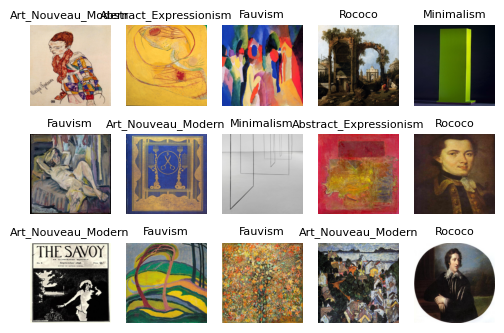

In [ ]:
import matplotlib.pyplot as plt


# Visualizing some sample images
figure = plt.figure(figsize=(6, 4))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label_idx = dataset[sample_idx]
    img = (img)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    label = dataset.classes[label_idx]
    plt.title(label, fontsize = 8)
    import numpy as np
    plt.imshow((img.permute(1, 2, 0)))
plt.show()

# **Get and combine HOG, images, and color histograms features, then predict with Resnet50**

in this section we introduce our FeatureExtractor class, to help us implement the functionalities of extracting the hog, color histogram, and resnet features.

In [ ]:
import torch
import numpy as np
import torchvision.models as models
from torchvision import transforms
from skimage.feature import hog

class FeatureExtractor:
    def __init__(self):
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = torch.nn.Sequential(*list(self.resnet50.children())[:-1])
        self.resnet50.eval()

    def tensor_to_numpy(self, image_tensor):
        img = transforms.ToPILImage()(image_tensor).convert("RGB")
        return np.array(img)

    def numpy_to_tensor(self, image_np):
        return transforms.ToTensor()(image_np)

    def extract_hog(self, image_np):
        features, _ = hog(image_np, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=True, multichannel=True)
        return features

    def extract_color_histogram(self, image_np, bins=32):
        hist_features = []
        for i in range(3):
            hist, _ = np.histogram(image_np[:, :, i], bins=bins, range=(0, 255))
            hist_features.extend(hist)
        return hist_features

    def extract_resnet50(self, image_tensor):
        with torch.no_grad():
            features = self.resnet50(image_tensor.unsqueeze(0))
        return features.squeeze().numpy()

    def extract_all_features(self, image_tensor):
        image_np = self.tensor_to_numpy(image_tensor)
        hog_features = self.extract_hog(image_np)
        color_hist_features = self.extract_color_histogram(image_np)
        resnet_features = self.extract_resnet50(image_tensor)
        return np.concatenate([hog_features, color_hist_features, resnet_features])

feature_extractor = FeatureExtractor()

if os.path.exists('/content/drive/MyDrive/art_styles_features.npy') and os.path.exists('/content/drive/MyDrive/art_styles_labels.npy'):
    combined_features_dataset = list(np.load('/content/drive/MyDrive/art_styles_features.npy', allow_pickle=True))
    labels_dataset = list(np.load('/content/drive/MyDrive/art_styles_labels.npy', allow_pickle=True))
    last_index = len(combined_features_dataset) - 1
    # sliced_data = [dataset[i] for i in range(last_index+1, len(dataset))]
    indices = range(last_index+1, len(dataset))
    sliced_data = Subset(dataset, indices)
else:
    combined_features_dataset = []
    labels_dataset = []
    last_index = -1
    sliced_data = dataset

for img, label in tqdm(sliced_data, desc="Extracting features"):
    combined_features = feature_extractor.extract_all_features(img)
    combined_features_dataset.append(combined_features)
    labels_dataset.append(label)

    # Periodically save the data to avoid losing progress
    np.save('/content/drive/MyDrive/art_styles_features.npy', combined_features_dataset)
    np.save('/content/drive/MyDrive/art_styles_labels.npy', labels_dataset)

# Save any remaining data after loop completion
np.save('/content/drive/MyDrive/art_styles_features.npy', combined_features_dataset)
np.save('/content/drive/MyDrive/art_styles_labels.npy', labels_dataset)


Extracting features:   0%|          | 0/5138 [00:00<?, ?it/s]<ipython-input-13-123a3d1a4350>:21: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, _ = hog(image_np, orientations=8, pixels_per_cell=(16, 16),
Extracting features: 100%|██████████| 5138/5138 [26:19<00:00,  3.25it/s]


In [ ]:
import numpy as np
#load the data, this is used if the features are extracted and if potential runtime loss happened
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features.npy', allow_pickle=True)
art_styles_features_hog = np.load('/content/drive/MyDrive/art_styles_features_hog.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels.npy', allow_pickle=True)

In [ ]:
#pringting the shapes of our datasets
print(art_styles_features.shape)
print(art_styles_features_hog.shape)
combined_features_dataset = np.concatenate((art_styles_features, art_styles_features_hog), axis=1)

(5138, 2144)
(5138, 1568)


In [ ]:
combined_features_dataset.shape

(5138, 3712)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(combined_features_dataset, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
len(full_dataset)

5138

# **Split the dataset**

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Define the classifier model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
        super(DeepNN, self).__init__()
        # Create a list of fully connected layers
        self.fc_layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for layer in self.fc_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

# **the Artsy full model (Resnet + HOG + color histograms features)**

in this section we use the combined features (resnet + hog + resnet) to train the model, then we observe the outcomes.

## **Training (artsy full)**

We progressed the training expermint, we started with 50 epochs and tried diffrent learning rates, Adam and SGD optimizers, and then progressed to 100 and 200 epochs.

we begin with 0.5 drop rate, then decrease it a little to 0.3, we tried diffrent learning rates, we adjusted according to our graphs observations and what we think will work best from out experience.

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256, 128]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.5  # Dropout rate

# Initialize the model
model = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)

    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

Validating Epoch 1/30: 100%|██████████| 17/17 [00:00<00:00, 123.26it/s, valid_loss=26.5]


Epoch 1/30, Training Loss: 0.3888, Validation Loss: 0.0517, Training Accuracy: 24.79%, Validation Accuracy: 26.12%


Validating Epoch 2/30: 100%|██████████| 17/17 [00:00<00:00, 133.55it/s, valid_loss=26.5]


Epoch 2/30, Training Loss: 0.0671, Validation Loss: 0.0516, Training Accuracy: 26.01%, Validation Accuracy: 25.93%


Validating Epoch 3/30: 100%|██████████| 17/17 [00:00<00:00, 127.06it/s, valid_loss=26.2]


Epoch 3/30, Training Loss: 0.0525, Validation Loss: 0.0511, Training Accuracy: 25.89%, Validation Accuracy: 24.76%


Validating Epoch 4/30: 100%|██████████| 17/17 [00:00<00:00, 121.14it/s, valid_loss=25.6]


Epoch 4/30, Training Loss: 0.0516, Validation Loss: 0.0499, Training Accuracy: 26.59%, Validation Accuracy: 32.36%


Validating Epoch 5/30: 100%|██████████| 17/17 [00:00<00:00, 124.44it/s, valid_loss=26.2]


Epoch 5/30, Training Loss: 0.0504, Validation Loss: 0.0510, Training Accuracy: 28.18%, Validation Accuracy: 29.43%


Validating Epoch 6/30: 100%|██████████| 17/17 [00:00<00:00, 125.89it/s, valid_loss=25.1]


Epoch 6/30, Training Loss: 0.0485, Validation Loss: 0.0490, Training Accuracy: 28.73%, Validation Accuracy: 36.65%


Validating Epoch 7/30: 100%|██████████| 17/17 [00:00<00:00, 122.48it/s, valid_loss=24.9]


Epoch 7/30, Training Loss: 0.0481, Validation Loss: 0.0485, Training Accuracy: 30.88%, Validation Accuracy: 33.53%


Validating Epoch 8/30: 100%|██████████| 17/17 [00:00<00:00, 118.41it/s, valid_loss=24.9]


Epoch 8/30, Training Loss: 0.0483, Validation Loss: 0.0484, Training Accuracy: 30.44%, Validation Accuracy: 36.45%


Validating Epoch 9/30: 100%|██████████| 17/17 [00:00<00:00, 103.74it/s, valid_loss=24.7]


Epoch 9/30, Training Loss: 0.0478, Validation Loss: 0.0482, Training Accuracy: 31.07%, Validation Accuracy: 32.55%


Validating Epoch 10/30: 100%|██████████| 17/17 [00:00<00:00, 119.58it/s, valid_loss=25.1]


Epoch 10/30, Training Loss: 0.0476, Validation Loss: 0.0489, Training Accuracy: 31.46%, Validation Accuracy: 32.75%


Validating Epoch 11/30: 100%|██████████| 17/17 [00:00<00:00, 122.47it/s, valid_loss=24.3]


Epoch 11/30, Training Loss: 0.0470, Validation Loss: 0.0474, Training Accuracy: 31.29%, Validation Accuracy: 36.26%


Validating Epoch 12/30: 100%|██████████| 17/17 [00:00<00:00, 123.69it/s, valid_loss=23.7]


Epoch 12/30, Training Loss: 0.0460, Validation Loss: 0.0461, Training Accuracy: 32.60%, Validation Accuracy: 38.99%


Validating Epoch 13/30: 100%|██████████| 17/17 [00:00<00:00, 105.77it/s, valid_loss=24.1]


Epoch 13/30, Training Loss: 0.0468, Validation Loss: 0.0469, Training Accuracy: 31.41%, Validation Accuracy: 39.57%


Validating Epoch 14/30: 100%|██████████| 17/17 [00:00<00:00, 115.31it/s, valid_loss=23.8]


Epoch 14/30, Training Loss: 0.0471, Validation Loss: 0.0465, Training Accuracy: 30.24%, Validation Accuracy: 38.01%


Validating Epoch 15/30: 100%|██████████| 17/17 [00:00<00:00, 122.12it/s, valid_loss=24.1]


Epoch 15/30, Training Loss: 0.0467, Validation Loss: 0.0469, Training Accuracy: 31.65%, Validation Accuracy: 37.62%


Validating Epoch 16/30: 100%|██████████| 17/17 [00:00<00:00, 119.14it/s, valid_loss=24.3]


Epoch 16/30, Training Loss: 0.0463, Validation Loss: 0.0474, Training Accuracy: 33.33%, Validation Accuracy: 38.01%


Validating Epoch 17/30: 100%|██████████| 17/17 [00:00<00:00, 111.74it/s, valid_loss=24.2]


Epoch 17/30, Training Loss: 0.0461, Validation Loss: 0.0471, Training Accuracy: 33.43%, Validation Accuracy: 42.69%


Validating Epoch 18/30: 100%|██████████| 17/17 [00:00<00:00, 115.35it/s, valid_loss=24]


Epoch 18/30, Training Loss: 0.0466, Validation Loss: 0.0469, Training Accuracy: 33.53%, Validation Accuracy: 39.77%


Validating Epoch 19/30: 100%|██████████| 17/17 [00:00<00:00, 130.13it/s, valid_loss=24.2]


Epoch 19/30, Training Loss: 0.0462, Validation Loss: 0.0472, Training Accuracy: 34.26%, Validation Accuracy: 38.60%


Validating Epoch 20/30: 100%|██████████| 17/17 [00:00<00:00, 117.25it/s, valid_loss=23.9]


Epoch 20/30, Training Loss: 0.0469, Validation Loss: 0.0465, Training Accuracy: 33.72%, Validation Accuracy: 39.57%


Validating Epoch 21/30: 100%|██████████| 17/17 [00:00<00:00, 100.24it/s, valid_loss=24.7]


Epoch 21/30, Training Loss: 0.0470, Validation Loss: 0.0481, Training Accuracy: 34.62%, Validation Accuracy: 36.84%


Validating Epoch 22/30: 100%|██████████| 17/17 [00:00<00:00, 115.07it/s, valid_loss=23.6]


Epoch 22/30, Training Loss: 0.0466, Validation Loss: 0.0460, Training Accuracy: 33.41%, Validation Accuracy: 41.52%


Validating Epoch 23/30: 100%|██████████| 17/17 [00:00<00:00, 115.98it/s, valid_loss=23.1]


Epoch 23/30, Training Loss: 0.0459, Validation Loss: 0.0450, Training Accuracy: 34.26%, Validation Accuracy: 38.60%


Validating Epoch 24/30: 100%|██████████| 17/17 [00:00<00:00, 120.37it/s, valid_loss=23.8]


Epoch 24/30, Training Loss: 0.0456, Validation Loss: 0.0464, Training Accuracy: 33.94%, Validation Accuracy: 41.52%


Validating Epoch 25/30: 100%|██████████| 17/17 [00:00<00:00, 103.86it/s, valid_loss=23.6]


Epoch 25/30, Training Loss: 0.0460, Validation Loss: 0.0461, Training Accuracy: 35.04%, Validation Accuracy: 43.27%


Validating Epoch 26/30: 100%|██████████| 17/17 [00:00<00:00, 100.32it/s, valid_loss=23.5]


Epoch 26/30, Training Loss: 0.0454, Validation Loss: 0.0458, Training Accuracy: 33.80%, Validation Accuracy: 41.52%


Validating Epoch 27/30: 100%|██████████| 17/17 [00:00<00:00, 109.10it/s, valid_loss=23.7]


Epoch 27/30, Training Loss: 0.0455, Validation Loss: 0.0462, Training Accuracy: 34.96%, Validation Accuracy: 39.57%


Validating Epoch 28/30: 100%|██████████| 17/17 [00:00<00:00, 118.11it/s, valid_loss=24]


Epoch 28/30, Training Loss: 0.0458, Validation Loss: 0.0467, Training Accuracy: 34.55%, Validation Accuracy: 39.57%


Validating Epoch 29/30: 100%|██████████| 17/17 [00:00<00:00, 94.05it/s, valid_loss=24]


Epoch 29/30, Training Loss: 0.0461, Validation Loss: 0.0468, Training Accuracy: 34.84%, Validation Accuracy: 40.74%


Validating Epoch 30/30: 100%|██████████| 17/17 [00:00<00:00, 106.10it/s, valid_loss=23.4]

Epoch 30/30, Training Loss: 0.0455, Validation Loss: 0.0457, Training Accuracy: 34.72%, Validation Accuracy: 41.52%


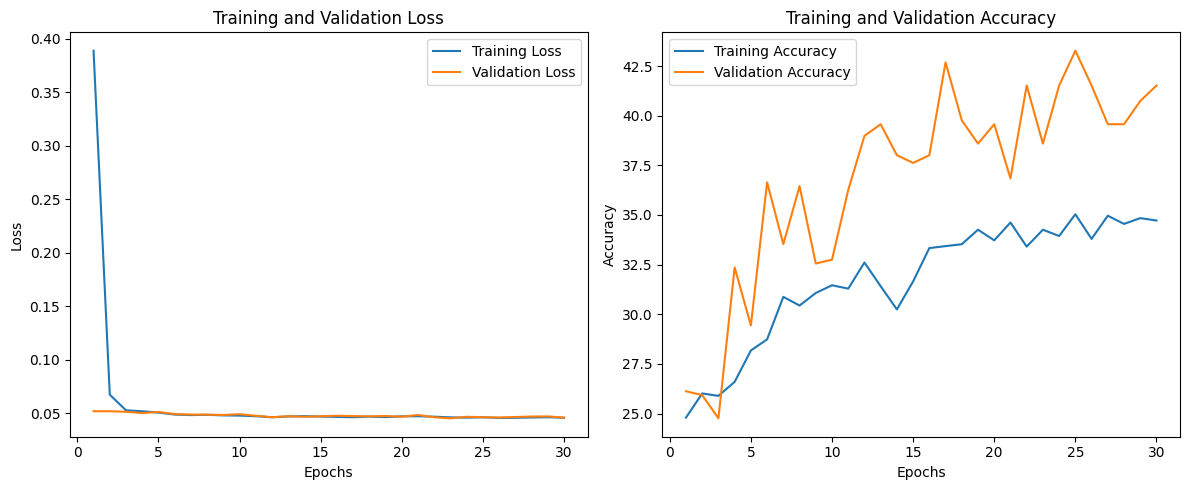

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Here we try just 2 hidden layers, and less drop out rate

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_2 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 50

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_2.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_2.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_2(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state = model_2.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state, 'best_model.pth')

Validating Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 96.80it/s, valid_loss=83.9]


Epoch 1/50, Training Loss: 0.3933, Validation Loss: 0.1635, Training Accuracy: 36.30%, Validation Accuracy: 38.99%


Validating Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 111.16it/s, valid_loss=50.8]


Epoch 2/50, Training Loss: 0.2423, Validation Loss: 0.0990, Training Accuracy: 37.01%, Validation Accuracy: 42.69%


Validating Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 126.61it/s, valid_loss=41.1]


Epoch 3/50, Training Loss: 0.1620, Validation Loss: 0.0802, Training Accuracy: 35.96%, Validation Accuracy: 36.45%


Validating Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 129.46it/s, valid_loss=31.4]


Epoch 4/50, Training Loss: 0.1073, Validation Loss: 0.0611, Training Accuracy: 36.18%, Validation Accuracy: 29.24%


Validating Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 126.65it/s, valid_loss=28.5]


Epoch 5/50, Training Loss: 0.0803, Validation Loss: 0.0555, Training Accuracy: 33.80%, Validation Accuracy: 28.46%


Validating Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 99.08it/s, valid_loss=27] 


Epoch 6/50, Training Loss: 0.0719, Validation Loss: 0.0526, Training Accuracy: 32.58%, Validation Accuracy: 25.73%


Validating Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 106.39it/s, valid_loss=26.4]


Epoch 7/50, Training Loss: 0.0644, Validation Loss: 0.0514, Training Accuracy: 29.37%, Validation Accuracy: 27.29%


Validating Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 108.24it/s, valid_loss=26.3]


Epoch 8/50, Training Loss: 0.0583, Validation Loss: 0.0512, Training Accuracy: 30.71%, Validation Accuracy: 26.32%


Validating Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 114.34it/s, valid_loss=25.1]


Epoch 9/50, Training Loss: 0.0540, Validation Loss: 0.0490, Training Accuracy: 31.05%, Validation Accuracy: 36.65%


Validating Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 114.51it/s, valid_loss=25]


Epoch 10/50, Training Loss: 0.0517, Validation Loss: 0.0487, Training Accuracy: 33.11%, Validation Accuracy: 38.21%


Validating Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 105.54it/s, valid_loss=24.6]


Epoch 11/50, Training Loss: 0.0507, Validation Loss: 0.0480, Training Accuracy: 33.28%, Validation Accuracy: 38.40%


Validating Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 101.34it/s, valid_loss=24.5]


Epoch 12/50, Training Loss: 0.0482, Validation Loss: 0.0477, Training Accuracy: 35.60%, Validation Accuracy: 38.60%


Validating Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 113.48it/s, valid_loss=24.5]


Epoch 13/50, Training Loss: 0.0469, Validation Loss: 0.0478, Training Accuracy: 37.20%, Validation Accuracy: 38.21%


Validating Epoch 14/50: 100%|██████████| 17/17 [00:00<00:00, 109.85it/s, valid_loss=24.3]


Epoch 14/50, Training Loss: 0.0477, Validation Loss: 0.0473, Training Accuracy: 37.01%, Validation Accuracy: 38.01%


Validating Epoch 15/50: 100%|██████████| 17/17 [00:00<00:00, 112.62it/s, valid_loss=24.1]


Epoch 15/50, Training Loss: 0.0465, Validation Loss: 0.0469, Training Accuracy: 38.83%, Validation Accuracy: 38.79%


Validating Epoch 16/50: 100%|██████████| 17/17 [00:00<00:00, 114.05it/s, valid_loss=24.1]


Epoch 16/50, Training Loss: 0.0462, Validation Loss: 0.0470, Training Accuracy: 37.71%, Validation Accuracy: 38.01%


Validating Epoch 17/50: 100%|██████████| 17/17 [00:00<00:00, 89.28it/s, valid_loss=24]


Epoch 17/50, Training Loss: 0.0453, Validation Loss: 0.0468, Training Accuracy: 38.27%, Validation Accuracy: 39.38%


Validating Epoch 18/50: 100%|██████████| 17/17 [00:00<00:00, 100.46it/s, valid_loss=23.7]


Epoch 18/50, Training Loss: 0.0453, Validation Loss: 0.0462, Training Accuracy: 39.05%, Validation Accuracy: 40.74%


Validating Epoch 19/50: 100%|██████████| 17/17 [00:00<00:00, 102.92it/s, valid_loss=23.4]


Epoch 19/50, Training Loss: 0.0448, Validation Loss: 0.0456, Training Accuracy: 40.32%, Validation Accuracy: 39.96%


Validating Epoch 20/50: 100%|██████████| 17/17 [00:00<00:00, 122.57it/s, valid_loss=23.6]


Epoch 20/50, Training Loss: 0.0451, Validation Loss: 0.0459, Training Accuracy: 39.49%, Validation Accuracy: 40.94%


Validating Epoch 21/50: 100%|██████████| 17/17 [00:00<00:00, 108.88it/s, valid_loss=23.5]


Epoch 21/50, Training Loss: 0.0438, Validation Loss: 0.0458, Training Accuracy: 41.09%, Validation Accuracy: 41.91%


Validating Epoch 22/50: 100%|██████████| 17/17 [00:00<00:00, 102.68it/s, valid_loss=23]


Epoch 22/50, Training Loss: 0.0439, Validation Loss: 0.0449, Training Accuracy: 39.15%, Validation Accuracy: 43.47%


Validating Epoch 23/50: 100%|██████████| 17/17 [00:00<00:00, 102.27it/s, valid_loss=23.1]


Epoch 23/50, Training Loss: 0.0435, Validation Loss: 0.0450, Training Accuracy: 40.41%, Validation Accuracy: 42.88%


Validating Epoch 24/50: 100%|██████████| 17/17 [00:00<00:00, 107.39it/s, valid_loss=23]


Epoch 24/50, Training Loss: 0.0435, Validation Loss: 0.0448, Training Accuracy: 40.71%, Validation Accuracy: 40.74%


Validating Epoch 25/50: 100%|██████████| 17/17 [00:00<00:00, 116.24it/s, valid_loss=23.1]


Epoch 25/50, Training Loss: 0.0428, Validation Loss: 0.0450, Training Accuracy: 41.53%, Validation Accuracy: 42.50%


Validating Epoch 26/50: 100%|██████████| 17/17 [00:00<00:00, 119.52it/s, valid_loss=22.7]


Epoch 26/50, Training Loss: 0.0432, Validation Loss: 0.0443, Training Accuracy: 40.24%, Validation Accuracy: 44.25%


Validating Epoch 27/50: 100%|██████████| 17/17 [00:00<00:00, 123.07it/s, valid_loss=22.9]


Epoch 27/50, Training Loss: 0.0424, Validation Loss: 0.0446, Training Accuracy: 41.97%, Validation Accuracy: 43.27%


Validating Epoch 28/50: 100%|██████████| 17/17 [00:00<00:00, 111.18it/s, valid_loss=23]


Epoch 28/50, Training Loss: 0.0426, Validation Loss: 0.0449, Training Accuracy: 41.65%, Validation Accuracy: 43.08%


Validating Epoch 29/50: 100%|██████████| 17/17 [00:00<00:00, 105.15it/s, valid_loss=22.9]


Epoch 29/50, Training Loss: 0.0418, Validation Loss: 0.0446, Training Accuracy: 42.04%, Validation Accuracy: 44.05%


Validating Epoch 30/50: 100%|██████████| 17/17 [00:00<00:00, 122.04it/s, valid_loss=22.5]


Epoch 30/50, Training Loss: 0.0420, Validation Loss: 0.0438, Training Accuracy: 41.85%, Validation Accuracy: 44.05%


Validating Epoch 31/50: 100%|██████████| 17/17 [00:00<00:00, 133.27it/s, valid_loss=22.7]


Epoch 31/50, Training Loss: 0.0417, Validation Loss: 0.0443, Training Accuracy: 41.97%, Validation Accuracy: 45.22%


Validating Epoch 32/50: 100%|██████████| 17/17 [00:00<00:00, 126.24it/s, valid_loss=22.5]


Epoch 32/50, Training Loss: 0.0414, Validation Loss: 0.0439, Training Accuracy: 42.14%, Validation Accuracy: 45.22%


Validating Epoch 33/50: 100%|██████████| 17/17 [00:00<00:00, 113.14it/s, valid_loss=22.5]


Epoch 33/50, Training Loss: 0.0412, Validation Loss: 0.0439, Training Accuracy: 43.14%, Validation Accuracy: 45.61%


Validating Epoch 34/50: 100%|██████████| 17/17 [00:00<00:00, 117.87it/s, valid_loss=22.5]


Epoch 34/50, Training Loss: 0.0412, Validation Loss: 0.0438, Training Accuracy: 44.16%, Validation Accuracy: 46.00%


Validating Epoch 35/50: 100%|██████████| 17/17 [00:00<00:00, 140.27it/s, valid_loss=22.7]


Epoch 35/50, Training Loss: 0.0404, Validation Loss: 0.0442, Training Accuracy: 45.43%, Validation Accuracy: 44.83%


Validating Epoch 36/50: 100%|██████████| 17/17 [00:00<00:00, 104.17it/s, valid_loss=22.1]


Epoch 36/50, Training Loss: 0.0398, Validation Loss: 0.0431, Training Accuracy: 45.28%, Validation Accuracy: 45.22%


Validating Epoch 37/50: 100%|██████████| 17/17 [00:00<00:00, 112.01it/s, valid_loss=22.2]


Epoch 37/50, Training Loss: 0.0400, Validation Loss: 0.0432, Training Accuracy: 45.11%, Validation Accuracy: 47.56%


Validating Epoch 38/50: 100%|██████████| 17/17 [00:00<00:00, 111.28it/s, valid_loss=22]


Epoch 38/50, Training Loss: 0.0394, Validation Loss: 0.0428, Training Accuracy: 45.84%, Validation Accuracy: 46.98%


Validating Epoch 39/50: 100%|██████████| 17/17 [00:00<00:00, 110.76it/s, valid_loss=22.1]


Epoch 39/50, Training Loss: 0.0399, Validation Loss: 0.0430, Training Accuracy: 45.28%, Validation Accuracy: 47.95%


Validating Epoch 40/50: 100%|██████████| 17/17 [00:00<00:00, 121.29it/s, valid_loss=22.2]


Epoch 40/50, Training Loss: 0.0394, Validation Loss: 0.0433, Training Accuracy: 46.30%, Validation Accuracy: 48.34%


Validating Epoch 41/50: 100%|██████████| 17/17 [00:00<00:00, 109.70it/s, valid_loss=22.4]


Epoch 41/50, Training Loss: 0.0390, Validation Loss: 0.0436, Training Accuracy: 46.06%, Validation Accuracy: 47.95%


Validating Epoch 42/50: 100%|██████████| 17/17 [00:00<00:00, 98.13it/s, valid_loss=22]


Epoch 42/50, Training Loss: 0.0388, Validation Loss: 0.0430, Training Accuracy: 46.81%, Validation Accuracy: 48.73%


Validating Epoch 43/50: 100%|██████████| 17/17 [00:00<00:00, 116.43it/s, valid_loss=22.1]


Epoch 43/50, Training Loss: 0.0388, Validation Loss: 0.0430, Training Accuracy: 46.93%, Validation Accuracy: 48.15%


Validating Epoch 44/50: 100%|██████████| 17/17 [00:00<00:00, 120.54it/s, valid_loss=22]


Epoch 44/50, Training Loss: 0.0385, Validation Loss: 0.0429, Training Accuracy: 47.59%, Validation Accuracy: 49.71%


Validating Epoch 45/50: 100%|██████████| 17/17 [00:00<00:00, 89.11it/s, valid_loss=22.1]


Epoch 45/50, Training Loss: 0.0385, Validation Loss: 0.0431, Training Accuracy: 47.59%, Validation Accuracy: 48.73%


Validating Epoch 46/50: 100%|██████████| 17/17 [00:00<00:00, 104.41it/s, valid_loss=21.7]


Epoch 46/50, Training Loss: 0.0380, Validation Loss: 0.0422, Training Accuracy: 48.05%, Validation Accuracy: 48.93%


Validating Epoch 47/50: 100%|██████████| 17/17 [00:00<00:00, 122.58it/s, valid_loss=21.7]


Epoch 47/50, Training Loss: 0.0381, Validation Loss: 0.0423, Training Accuracy: 48.56%, Validation Accuracy: 49.90%


Validating Epoch 48/50: 100%|██████████| 17/17 [00:00<00:00, 120.32it/s, valid_loss=21.7]


Epoch 48/50, Training Loss: 0.0378, Validation Loss: 0.0423, Training Accuracy: 48.69%, Validation Accuracy: 49.90%


Validating Epoch 49/50: 100%|██████████| 17/17 [00:00<00:00, 114.44it/s, valid_loss=21.7]


Epoch 49/50, Training Loss: 0.0376, Validation Loss: 0.0424, Training Accuracy: 48.47%, Validation Accuracy: 50.49%


Validating Epoch 50/50: 100%|██████████| 17/17 [00:00<00:00, 109.48it/s, valid_loss=22.3]


Epoch 50/50, Training Loss: 0.0371, Validation Loss: 0.0434, Training Accuracy: 49.66%, Validation Accuracy: 47.95%


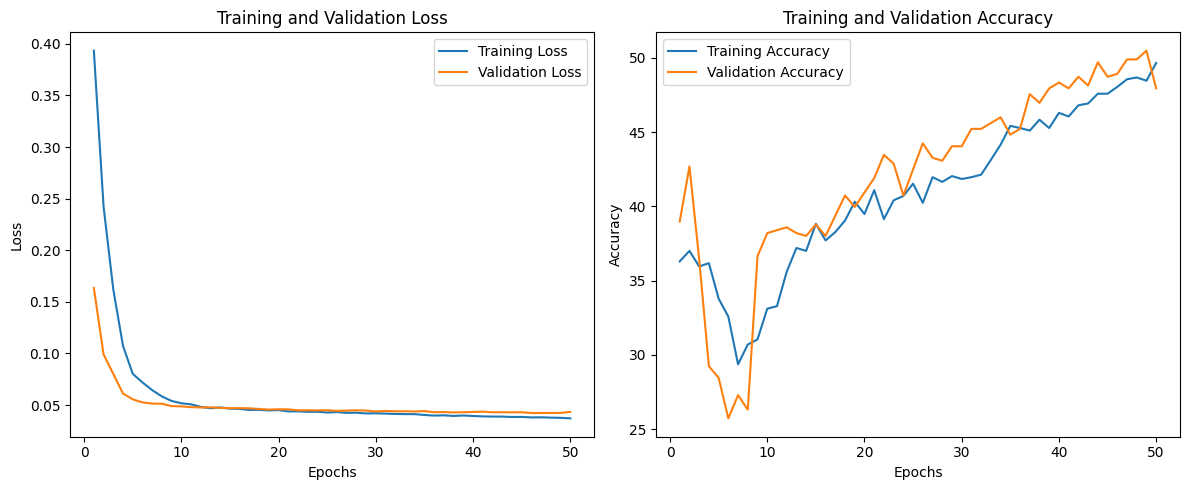

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

We moved to 100 epochs, to see if the accuracy will improve with more epochs (as we notice in the previous graphs the accuracy in increasing and the loss is dcreasing so we expect it will continue this way.

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 132.94it/s, valid_loss=159]


Epoch 1/100, Training Loss: 0.9769, Validation Loss: 0.3098, Training Accuracy: 30.39%, Validation Accuracy: 41.52%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 123.02it/s, valid_loss=74.9]


Epoch 2/100, Training Loss: 0.3842, Validation Loss: 0.1461, Training Accuracy: 36.23%, Validation Accuracy: 39.38%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 116.39it/s, valid_loss=42.2]


Epoch 3/100, Training Loss: 0.2328, Validation Loss: 0.0824, Training Accuracy: 36.62%, Validation Accuracy: 41.52%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 120.60it/s, valid_loss=32.8]


Epoch 4/100, Training Loss: 0.1530, Validation Loss: 0.0640, Training Accuracy: 36.18%, Validation Accuracy: 38.60%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 93.80it/s, valid_loss=28.3]


Epoch 5/100, Training Loss: 0.1032, Validation Loss: 0.0551, Training Accuracy: 34.53%, Validation Accuracy: 34.11%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 114.65it/s, valid_loss=26.4]


Epoch 6/100, Training Loss: 0.0817, Validation Loss: 0.0516, Training Accuracy: 33.43%, Validation Accuracy: 30.80%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 109.16it/s, valid_loss=26.1]


Epoch 7/100, Training Loss: 0.0671, Validation Loss: 0.0509, Training Accuracy: 32.63%, Validation Accuracy: 30.60%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 114.21it/s, valid_loss=25.6]


Epoch 8/100, Training Loss: 0.0601, Validation Loss: 0.0500, Training Accuracy: 34.23%, Validation Accuracy: 30.99%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 119.14it/s, valid_loss=25.9]


Epoch 9/100, Training Loss: 0.0563, Validation Loss: 0.0505, Training Accuracy: 34.48%, Validation Accuracy: 30.41%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 108.74it/s, valid_loss=24.7]


Epoch 10/100, Training Loss: 0.0530, Validation Loss: 0.0481, Training Accuracy: 34.26%, Validation Accuracy: 38.01%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 113.31it/s, valid_loss=24.9]


Epoch 11/100, Training Loss: 0.0501, Validation Loss: 0.0486, Training Accuracy: 34.50%, Validation Accuracy: 35.28%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 112.77it/s, valid_loss=24.3]


Epoch 12/100, Training Loss: 0.0499, Validation Loss: 0.0474, Training Accuracy: 34.91%, Validation Accuracy: 39.57%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 106.86it/s, valid_loss=23.8]


Epoch 13/100, Training Loss: 0.0479, Validation Loss: 0.0463, Training Accuracy: 36.42%, Validation Accuracy: 40.74%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 120.35it/s, valid_loss=23.9]


Epoch 14/100, Training Loss: 0.0484, Validation Loss: 0.0466, Training Accuracy: 36.30%, Validation Accuracy: 38.21%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 102.33it/s, valid_loss=23.8]


Epoch 15/100, Training Loss: 0.0468, Validation Loss: 0.0464, Training Accuracy: 35.69%, Validation Accuracy: 39.96%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 110.02it/s, valid_loss=23.7]


Epoch 16/100, Training Loss: 0.0468, Validation Loss: 0.0462, Training Accuracy: 36.79%, Validation Accuracy: 42.30%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 113.52it/s, valid_loss=23.6]


Epoch 17/100, Training Loss: 0.0455, Validation Loss: 0.0460, Training Accuracy: 36.81%, Validation Accuracy: 42.11%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 102.99it/s, valid_loss=23.4]


Epoch 18/100, Training Loss: 0.0459, Validation Loss: 0.0457, Training Accuracy: 36.52%, Validation Accuracy: 42.88%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 127.27it/s, valid_loss=23.2]


Epoch 19/100, Training Loss: 0.0445, Validation Loss: 0.0452, Training Accuracy: 37.59%, Validation Accuracy: 44.44%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 120.09it/s, valid_loss=23.2]


Epoch 20/100, Training Loss: 0.0440, Validation Loss: 0.0453, Training Accuracy: 38.42%, Validation Accuracy: 41.13%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 116.18it/s, valid_loss=23.3]


Epoch 21/100, Training Loss: 0.0445, Validation Loss: 0.0454, Training Accuracy: 38.39%, Validation Accuracy: 42.88%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 116.32it/s, valid_loss=23.5]


Epoch 22/100, Training Loss: 0.0434, Validation Loss: 0.0458, Training Accuracy: 38.71%, Validation Accuracy: 41.72%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 52.16it/s, valid_loss=22.9]


Epoch 23/100, Training Loss: 0.0437, Validation Loss: 0.0447, Training Accuracy: 39.49%, Validation Accuracy: 41.91%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 135.26it/s, valid_loss=23.3]


Epoch 24/100, Training Loss: 0.0428, Validation Loss: 0.0455, Training Accuracy: 37.88%, Validation Accuracy: 42.88%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 130.12it/s, valid_loss=22.7]


Epoch 25/100, Training Loss: 0.0432, Validation Loss: 0.0442, Training Accuracy: 38.66%, Validation Accuracy: 43.47%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 63.12it/s, valid_loss=22.6]


Epoch 26/100, Training Loss: 0.0419, Validation Loss: 0.0440, Training Accuracy: 40.78%, Validation Accuracy: 42.11%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 60.84it/s, valid_loss=22.8]


Epoch 27/100, Training Loss: 0.0431, Validation Loss: 0.0444, Training Accuracy: 39.61%, Validation Accuracy: 41.52%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 105.95it/s, valid_loss=22.5]


Epoch 28/100, Training Loss: 0.0419, Validation Loss: 0.0439, Training Accuracy: 41.17%, Validation Accuracy: 41.72%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 92.48it/s, valid_loss=22.1]


Epoch 29/100, Training Loss: 0.0425, Validation Loss: 0.0431, Training Accuracy: 41.34%, Validation Accuracy: 42.50%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 74.90it/s, valid_loss=22.3]


Epoch 30/100, Training Loss: 0.0420, Validation Loss: 0.0434, Training Accuracy: 41.09%, Validation Accuracy: 44.25%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 39.17it/s, valid_loss=22]


Epoch 31/100, Training Loss: 0.0411, Validation Loss: 0.0429, Training Accuracy: 42.21%, Validation Accuracy: 44.05%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 75.19it/s, valid_loss=22]


Epoch 32/100, Training Loss: 0.0414, Validation Loss: 0.0429, Training Accuracy: 41.14%, Validation Accuracy: 43.08%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 119.13it/s, valid_loss=22]


Epoch 33/100, Training Loss: 0.0418, Validation Loss: 0.0429, Training Accuracy: 42.04%, Validation Accuracy: 45.61%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 61.70it/s, valid_loss=21.8]


Epoch 34/100, Training Loss: 0.0411, Validation Loss: 0.0424, Training Accuracy: 42.00%, Validation Accuracy: 43.27%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 66.42it/s, valid_loss=22]


Epoch 35/100, Training Loss: 0.0416, Validation Loss: 0.0428, Training Accuracy: 43.04%, Validation Accuracy: 44.64%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 124.71it/s, valid_loss=21.7]


Epoch 36/100, Training Loss: 0.0402, Validation Loss: 0.0422, Training Accuracy: 44.21%, Validation Accuracy: 46.00%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 116.10it/s, valid_loss=21.7]


Epoch 37/100, Training Loss: 0.0401, Validation Loss: 0.0423, Training Accuracy: 42.46%, Validation Accuracy: 46.39%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 128.46it/s, valid_loss=22.1]


Epoch 38/100, Training Loss: 0.0403, Validation Loss: 0.0430, Training Accuracy: 43.11%, Validation Accuracy: 45.22%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 124.60it/s, valid_loss=21.6]


Epoch 39/100, Training Loss: 0.0406, Validation Loss: 0.0420, Training Accuracy: 44.33%, Validation Accuracy: 46.59%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 125.71it/s, valid_loss=21.9]


Epoch 40/100, Training Loss: 0.0400, Validation Loss: 0.0428, Training Accuracy: 44.21%, Validation Accuracy: 46.78%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 112.24it/s, valid_loss=21.4]


Epoch 41/100, Training Loss: 0.0396, Validation Loss: 0.0417, Training Accuracy: 44.11%, Validation Accuracy: 46.20%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 114.79it/s, valid_loss=21.8]


Epoch 42/100, Training Loss: 0.0395, Validation Loss: 0.0424, Training Accuracy: 44.96%, Validation Accuracy: 46.00%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 111.55it/s, valid_loss=21.9]


Epoch 43/100, Training Loss: 0.0394, Validation Loss: 0.0427, Training Accuracy: 45.74%, Validation Accuracy: 46.98%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 105.16it/s, valid_loss=22.1]


Epoch 44/100, Training Loss: 0.0386, Validation Loss: 0.0430, Training Accuracy: 45.16%, Validation Accuracy: 47.17%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 116.89it/s, valid_loss=22.2]


Epoch 45/100, Training Loss: 0.0387, Validation Loss: 0.0433, Training Accuracy: 45.38%, Validation Accuracy: 46.20%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 119.87it/s, valid_loss=21.9]


Epoch 46/100, Training Loss: 0.0384, Validation Loss: 0.0427, Training Accuracy: 46.86%, Validation Accuracy: 48.54%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 117.42it/s, valid_loss=21.1]


Epoch 47/100, Training Loss: 0.0383, Validation Loss: 0.0412, Training Accuracy: 47.32%, Validation Accuracy: 48.15%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 122.51it/s, valid_loss=20.9]


Epoch 48/100, Training Loss: 0.0383, Validation Loss: 0.0408, Training Accuracy: 47.15%, Validation Accuracy: 48.93%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 107.47it/s, valid_loss=20.8]


Epoch 49/100, Training Loss: 0.0384, Validation Loss: 0.0406, Training Accuracy: 48.27%, Validation Accuracy: 49.90%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 124.87it/s, valid_loss=21.6]


Epoch 50/100, Training Loss: 0.0385, Validation Loss: 0.0421, Training Accuracy: 46.84%, Validation Accuracy: 49.90%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 126.62it/s, valid_loss=21.6]


Epoch 51/100, Training Loss: 0.0375, Validation Loss: 0.0421, Training Accuracy: 47.74%, Validation Accuracy: 48.54%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 114.71it/s, valid_loss=20.6]


Epoch 52/100, Training Loss: 0.0376, Validation Loss: 0.0402, Training Accuracy: 49.27%, Validation Accuracy: 49.32%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 111.01it/s, valid_loss=20.9]


Epoch 53/100, Training Loss: 0.0371, Validation Loss: 0.0407, Training Accuracy: 48.52%, Validation Accuracy: 49.71%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 110.31it/s, valid_loss=21]


Epoch 54/100, Training Loss: 0.0365, Validation Loss: 0.0409, Training Accuracy: 49.44%, Validation Accuracy: 49.71%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 118.18it/s, valid_loss=21.6]


Epoch 55/100, Training Loss: 0.0368, Validation Loss: 0.0421, Training Accuracy: 49.78%, Validation Accuracy: 51.46%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 126.18it/s, valid_loss=20.8]


Epoch 56/100, Training Loss: 0.0363, Validation Loss: 0.0406, Training Accuracy: 49.93%, Validation Accuracy: 48.34%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 108.48it/s, valid_loss=21.9]


Epoch 57/100, Training Loss: 0.0362, Validation Loss: 0.0427, Training Accuracy: 50.29%, Validation Accuracy: 50.10%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 116.31it/s, valid_loss=20.5]


Epoch 58/100, Training Loss: 0.0360, Validation Loss: 0.0400, Training Accuracy: 49.88%, Validation Accuracy: 49.90%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 109.33it/s, valid_loss=20.4]


Epoch 59/100, Training Loss: 0.0362, Validation Loss: 0.0397, Training Accuracy: 50.73%, Validation Accuracy: 52.44%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 130.41it/s, valid_loss=20.8]


Epoch 60/100, Training Loss: 0.0357, Validation Loss: 0.0405, Training Accuracy: 51.87%, Validation Accuracy: 50.10%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 139.34it/s, valid_loss=20.3]


Epoch 61/100, Training Loss: 0.0356, Validation Loss: 0.0396, Training Accuracy: 51.48%, Validation Accuracy: 52.05%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 137.31it/s, valid_loss=20.3]


Epoch 62/100, Training Loss: 0.0349, Validation Loss: 0.0395, Training Accuracy: 51.70%, Validation Accuracy: 50.29%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 125.92it/s, valid_loss=20]


Epoch 63/100, Training Loss: 0.0346, Validation Loss: 0.0391, Training Accuracy: 51.14%, Validation Accuracy: 49.32%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 123.89it/s, valid_loss=20]


Epoch 64/100, Training Loss: 0.0348, Validation Loss: 0.0390, Training Accuracy: 52.53%, Validation Accuracy: 49.51%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 116.17it/s, valid_loss=20.4]


Epoch 65/100, Training Loss: 0.0344, Validation Loss: 0.0398, Training Accuracy: 53.24%, Validation Accuracy: 52.63%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 128.90it/s, valid_loss=20.2]


Epoch 66/100, Training Loss: 0.0338, Validation Loss: 0.0393, Training Accuracy: 54.70%, Validation Accuracy: 50.49%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 128.19it/s, valid_loss=19.5]


Epoch 67/100, Training Loss: 0.0340, Validation Loss: 0.0381, Training Accuracy: 53.31%, Validation Accuracy: 51.27%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 129.53it/s, valid_loss=20.2]


Epoch 68/100, Training Loss: 0.0333, Validation Loss: 0.0394, Training Accuracy: 54.72%, Validation Accuracy: 51.66%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 101.23it/s, valid_loss=20]


Epoch 69/100, Training Loss: 0.0341, Validation Loss: 0.0389, Training Accuracy: 54.55%, Validation Accuracy: 52.44%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 108.62it/s, valid_loss=19.6]


Epoch 70/100, Training Loss: 0.0336, Validation Loss: 0.0381, Training Accuracy: 54.82%, Validation Accuracy: 53.61%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 99.93it/s, valid_loss=20]


Epoch 71/100, Training Loss: 0.0326, Validation Loss: 0.0390, Training Accuracy: 56.18%, Validation Accuracy: 52.44%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 120.50it/s, valid_loss=20.4]


Epoch 72/100, Training Loss: 0.0327, Validation Loss: 0.0397, Training Accuracy: 56.30%, Validation Accuracy: 51.66%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 53.83it/s, valid_loss=19.5]


Epoch 73/100, Training Loss: 0.0321, Validation Loss: 0.0380, Training Accuracy: 56.01%, Validation Accuracy: 51.07%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 99.16it/s, valid_loss=19.4]


Epoch 74/100, Training Loss: 0.0319, Validation Loss: 0.0377, Training Accuracy: 56.67%, Validation Accuracy: 53.41%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 103.07it/s, valid_loss=19.1]


Epoch 75/100, Training Loss: 0.0315, Validation Loss: 0.0373, Training Accuracy: 57.23%, Validation Accuracy: 53.41%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 37.03it/s, valid_loss=19.3]


Epoch 76/100, Training Loss: 0.0318, Validation Loss: 0.0377, Training Accuracy: 57.15%, Validation Accuracy: 51.85%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 75.63it/s, valid_loss=18.9]


Epoch 77/100, Training Loss: 0.0314, Validation Loss: 0.0368, Training Accuracy: 58.52%, Validation Accuracy: 52.63%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 121.22it/s, valid_loss=19]


Epoch 78/100, Training Loss: 0.0303, Validation Loss: 0.0371, Training Accuracy: 58.37%, Validation Accuracy: 54.78%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 52.25it/s, valid_loss=18.9]


Epoch 79/100, Training Loss: 0.0310, Validation Loss: 0.0368, Training Accuracy: 58.93%, Validation Accuracy: 55.36%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 64.27it/s, valid_loss=18.8]


Epoch 80/100, Training Loss: 0.0305, Validation Loss: 0.0367, Training Accuracy: 59.10%, Validation Accuracy: 55.95%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 103.94it/s, valid_loss=18.7]


Epoch 81/100, Training Loss: 0.0298, Validation Loss: 0.0365, Training Accuracy: 59.81%, Validation Accuracy: 54.97%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 114.45it/s, valid_loss=18.7]


Epoch 82/100, Training Loss: 0.0296, Validation Loss: 0.0364, Training Accuracy: 60.27%, Validation Accuracy: 54.58%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 126.41it/s, valid_loss=19.2]


Epoch 83/100, Training Loss: 0.0295, Validation Loss: 0.0375, Training Accuracy: 59.85%, Validation Accuracy: 56.92%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 112.63it/s, valid_loss=18.8]


Epoch 84/100, Training Loss: 0.0295, Validation Loss: 0.0367, Training Accuracy: 60.66%, Validation Accuracy: 56.53%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 134.93it/s, valid_loss=18.6]


Epoch 85/100, Training Loss: 0.0289, Validation Loss: 0.0362, Training Accuracy: 60.92%, Validation Accuracy: 56.34%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 116.69it/s, valid_loss=19.4]


Epoch 86/100, Training Loss: 0.0283, Validation Loss: 0.0379, Training Accuracy: 61.39%, Validation Accuracy: 55.36%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 120.53it/s, valid_loss=19]


Epoch 87/100, Training Loss: 0.0282, Validation Loss: 0.0371, Training Accuracy: 62.19%, Validation Accuracy: 54.78%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 119.93it/s, valid_loss=18.3]


Epoch 88/100, Training Loss: 0.0288, Validation Loss: 0.0358, Training Accuracy: 61.39%, Validation Accuracy: 54.78%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 129.05it/s, valid_loss=18.5]


Epoch 89/100, Training Loss: 0.0287, Validation Loss: 0.0361, Training Accuracy: 61.95%, Validation Accuracy: 55.95%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 121.27it/s, valid_loss=18]


Epoch 90/100, Training Loss: 0.0277, Validation Loss: 0.0350, Training Accuracy: 62.41%, Validation Accuracy: 55.75%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 135.84it/s, valid_loss=18.9]


Epoch 91/100, Training Loss: 0.0275, Validation Loss: 0.0369, Training Accuracy: 62.51%, Validation Accuracy: 57.70%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 118.89it/s, valid_loss=18.8]


Epoch 92/100, Training Loss: 0.0280, Validation Loss: 0.0367, Training Accuracy: 63.02%, Validation Accuracy: 54.97%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 121.62it/s, valid_loss=19.5]


Epoch 93/100, Training Loss: 0.0268, Validation Loss: 0.0380, Training Accuracy: 64.23%, Validation Accuracy: 55.75%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 124.93it/s, valid_loss=19]


Epoch 94/100, Training Loss: 0.0273, Validation Loss: 0.0369, Training Accuracy: 63.33%, Validation Accuracy: 55.36%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 110.42it/s, valid_loss=19.7]


Epoch 95/100, Training Loss: 0.0266, Validation Loss: 0.0383, Training Accuracy: 65.04%, Validation Accuracy: 54.78%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 132.68it/s, valid_loss=19.5]


Epoch 96/100, Training Loss: 0.0268, Validation Loss: 0.0381, Training Accuracy: 64.70%, Validation Accuracy: 56.14%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 93.71it/s, valid_loss=18.5]


Epoch 97/100, Training Loss: 0.0261, Validation Loss: 0.0360, Training Accuracy: 64.50%, Validation Accuracy: 56.73%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 101.08it/s, valid_loss=19.5]


Epoch 98/100, Training Loss: 0.0258, Validation Loss: 0.0380, Training Accuracy: 65.06%, Validation Accuracy: 56.53%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 122.34it/s, valid_loss=19.7]


Epoch 99/100, Training Loss: 0.0254, Validation Loss: 0.0384, Training Accuracy: 66.42%, Validation Accuracy: 55.56%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 123.56it/s, valid_loss=19]


Epoch 100/100, Training Loss: 0.0251, Validation Loss: 0.0371, Training Accuracy: 66.79%, Validation Accuracy: 58.67%


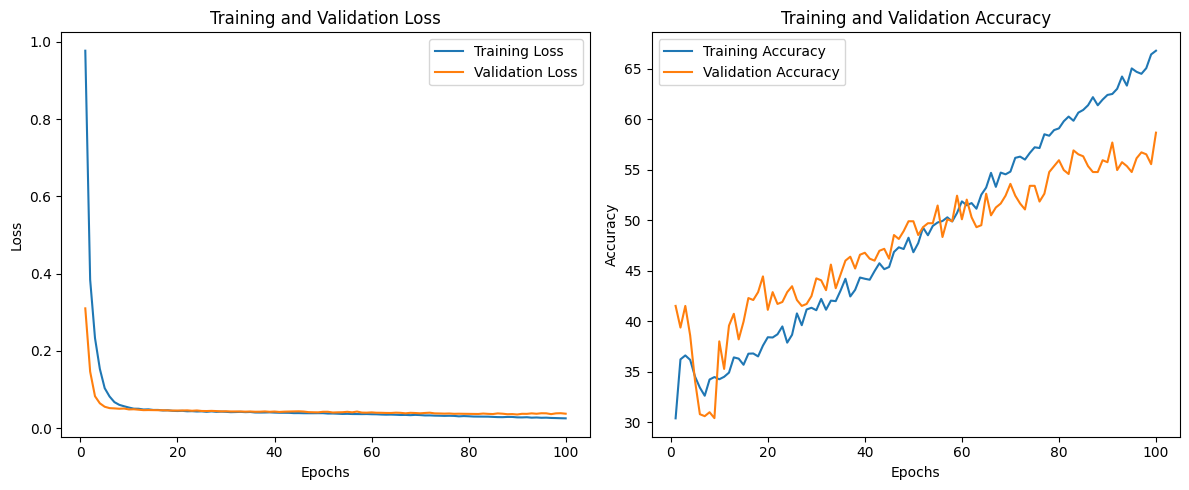

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Additional 100 epochs on the same model (the graphs here are a contiuation for the previous graphs)**

In [ ]:
model_4 = model_3

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state_4 = None

for epoch in range(num_epochs):
    # Training
    model_4.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_4(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_4.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_4(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_4 = model_4.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_4, 'best_model_4.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 131.82it/s, valid_loss=19.1]


Epoch 1/100, Training Loss: 0.0252, Validation Loss: 0.0372, Training Accuracy: 66.06%, Validation Accuracy: 56.34%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 84.23it/s, valid_loss=19.5]


Epoch 2/100, Training Loss: 0.0252, Validation Loss: 0.0380, Training Accuracy: 67.30%, Validation Accuracy: 57.89%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 118.02it/s, valid_loss=17.9]


Epoch 3/100, Training Loss: 0.0247, Validation Loss: 0.0348, Training Accuracy: 67.45%, Validation Accuracy: 58.67%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 102.24it/s, valid_loss=20]


Epoch 4/100, Training Loss: 0.0241, Validation Loss: 0.0389, Training Accuracy: 66.98%, Validation Accuracy: 57.70%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 98.46it/s, valid_loss=19.8]


Epoch 5/100, Training Loss: 0.0241, Validation Loss: 0.0386, Training Accuracy: 67.52%, Validation Accuracy: 57.12%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 122.28it/s, valid_loss=19.4]


Epoch 6/100, Training Loss: 0.0250, Validation Loss: 0.0377, Training Accuracy: 67.45%, Validation Accuracy: 59.45%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 119.75it/s, valid_loss=19.5]


Epoch 7/100, Training Loss: 0.0237, Validation Loss: 0.0379, Training Accuracy: 67.76%, Validation Accuracy: 55.56%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 118.35it/s, valid_loss=19.3]


Epoch 8/100, Training Loss: 0.0243, Validation Loss: 0.0376, Training Accuracy: 68.25%, Validation Accuracy: 58.67%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 116.59it/s, valid_loss=18.4]


Epoch 9/100, Training Loss: 0.0235, Validation Loss: 0.0358, Training Accuracy: 68.61%, Validation Accuracy: 57.89%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 112.99it/s, valid_loss=19.1]


Epoch 10/100, Training Loss: 0.0237, Validation Loss: 0.0372, Training Accuracy: 68.25%, Validation Accuracy: 60.23%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 127.28it/s, valid_loss=20.2]


Epoch 11/100, Training Loss: 0.0232, Validation Loss: 0.0393, Training Accuracy: 69.88%, Validation Accuracy: 58.67%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 119.82it/s, valid_loss=21.3]


Epoch 12/100, Training Loss: 0.0225, Validation Loss: 0.0415, Training Accuracy: 70.95%, Validation Accuracy: 58.48%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 128.11it/s, valid_loss=20.4]


Epoch 13/100, Training Loss: 0.0228, Validation Loss: 0.0397, Training Accuracy: 70.17%, Validation Accuracy: 58.09%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 112.87it/s, valid_loss=21.4]


Epoch 14/100, Training Loss: 0.0224, Validation Loss: 0.0418, Training Accuracy: 71.07%, Validation Accuracy: 58.87%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 111.66it/s, valid_loss=19.7]


Epoch 15/100, Training Loss: 0.0220, Validation Loss: 0.0385, Training Accuracy: 71.68%, Validation Accuracy: 56.73%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 122.71it/s, valid_loss=19.1]


Epoch 16/100, Training Loss: 0.0216, Validation Loss: 0.0372, Training Accuracy: 71.27%, Validation Accuracy: 60.04%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 112.34it/s, valid_loss=20.2]


Epoch 17/100, Training Loss: 0.0222, Validation Loss: 0.0394, Training Accuracy: 70.92%, Validation Accuracy: 59.26%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 122.66it/s, valid_loss=20.8]


Epoch 18/100, Training Loss: 0.0213, Validation Loss: 0.0406, Training Accuracy: 71.44%, Validation Accuracy: 58.87%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 118.54it/s, valid_loss=20.2]


Epoch 19/100, Training Loss: 0.0215, Validation Loss: 0.0393, Training Accuracy: 71.78%, Validation Accuracy: 58.87%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 124.40it/s, valid_loss=20.3]


Epoch 20/100, Training Loss: 0.0221, Validation Loss: 0.0396, Training Accuracy: 71.78%, Validation Accuracy: 57.70%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 107.22it/s, valid_loss=20.2]


Epoch 21/100, Training Loss: 0.0216, Validation Loss: 0.0394, Training Accuracy: 71.46%, Validation Accuracy: 59.45%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 135.35it/s, valid_loss=20.2]


Epoch 22/100, Training Loss: 0.0210, Validation Loss: 0.0393, Training Accuracy: 72.55%, Validation Accuracy: 56.92%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 125.02it/s, valid_loss=21.8]


Epoch 23/100, Training Loss: 0.0210, Validation Loss: 0.0426, Training Accuracy: 72.85%, Validation Accuracy: 57.50%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 129.35it/s, valid_loss=20.2]


Epoch 24/100, Training Loss: 0.0208, Validation Loss: 0.0394, Training Accuracy: 72.94%, Validation Accuracy: 60.04%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 114.68it/s, valid_loss=20.7]


Epoch 25/100, Training Loss: 0.0201, Validation Loss: 0.0403, Training Accuracy: 74.14%, Validation Accuracy: 60.04%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 109.41it/s, valid_loss=21.9]


Epoch 26/100, Training Loss: 0.0194, Validation Loss: 0.0427, Training Accuracy: 75.28%, Validation Accuracy: 59.45%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 133.33it/s, valid_loss=21.8]


Epoch 27/100, Training Loss: 0.0196, Validation Loss: 0.0425, Training Accuracy: 74.38%, Validation Accuracy: 59.26%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 121.00it/s, valid_loss=21.3]


Epoch 28/100, Training Loss: 0.0202, Validation Loss: 0.0415, Training Accuracy: 74.74%, Validation Accuracy: 59.65%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 119.05it/s, valid_loss=22.5]


Epoch 29/100, Training Loss: 0.0197, Validation Loss: 0.0439, Training Accuracy: 74.79%, Validation Accuracy: 60.82%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 112.59it/s, valid_loss=20.4]


Epoch 30/100, Training Loss: 0.0197, Validation Loss: 0.0398, Training Accuracy: 74.33%, Validation Accuracy: 61.60%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 106.60it/s, valid_loss=21.7]


Epoch 31/100, Training Loss: 0.0189, Validation Loss: 0.0423, Training Accuracy: 75.89%, Validation Accuracy: 60.04%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 116.51it/s, valid_loss=21.7]


Epoch 32/100, Training Loss: 0.0190, Validation Loss: 0.0424, Training Accuracy: 75.57%, Validation Accuracy: 61.79%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 117.41it/s, valid_loss=21.2]


Epoch 33/100, Training Loss: 0.0191, Validation Loss: 0.0413, Training Accuracy: 76.01%, Validation Accuracy: 58.67%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 120.42it/s, valid_loss=22.1]


Epoch 34/100, Training Loss: 0.0193, Validation Loss: 0.0431, Training Accuracy: 74.48%, Validation Accuracy: 58.28%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 123.45it/s, valid_loss=21.9]


Epoch 35/100, Training Loss: 0.0185, Validation Loss: 0.0427, Training Accuracy: 76.89%, Validation Accuracy: 59.45%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 113.33it/s, valid_loss=22.3]


Epoch 36/100, Training Loss: 0.0179, Validation Loss: 0.0435, Training Accuracy: 76.89%, Validation Accuracy: 59.45%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 121.45it/s, valid_loss=22.2]


Epoch 37/100, Training Loss: 0.0182, Validation Loss: 0.0432, Training Accuracy: 77.42%, Validation Accuracy: 59.45%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 109.59it/s, valid_loss=22.2]


Epoch 38/100, Training Loss: 0.0179, Validation Loss: 0.0433, Training Accuracy: 76.64%, Validation Accuracy: 58.48%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 111.29it/s, valid_loss=21.3]


Epoch 39/100, Training Loss: 0.0185, Validation Loss: 0.0415, Training Accuracy: 77.03%, Validation Accuracy: 60.23%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 117.67it/s, valid_loss=21.9]


Epoch 40/100, Training Loss: 0.0184, Validation Loss: 0.0427, Training Accuracy: 76.25%, Validation Accuracy: 59.84%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 116.34it/s, valid_loss=22.2]


Epoch 41/100, Training Loss: 0.0192, Validation Loss: 0.0433, Training Accuracy: 76.03%, Validation Accuracy: 60.62%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 114.64it/s, valid_loss=22.6]


Epoch 42/100, Training Loss: 0.0170, Validation Loss: 0.0441, Training Accuracy: 78.27%, Validation Accuracy: 59.45%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 105.44it/s, valid_loss=20.5]


Epoch 43/100, Training Loss: 0.0174, Validation Loss: 0.0400, Training Accuracy: 77.74%, Validation Accuracy: 58.67%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 114.46it/s, valid_loss=20.5]


Epoch 44/100, Training Loss: 0.0166, Validation Loss: 0.0400, Training Accuracy: 78.71%, Validation Accuracy: 61.21%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 122.67it/s, valid_loss=20.6]


Epoch 45/100, Training Loss: 0.0167, Validation Loss: 0.0401, Training Accuracy: 78.76%, Validation Accuracy: 60.23%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 131.06it/s, valid_loss=20.5]


Epoch 46/100, Training Loss: 0.0168, Validation Loss: 0.0399, Training Accuracy: 78.78%, Validation Accuracy: 62.57%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 118.69it/s, valid_loss=19.7]


Epoch 47/100, Training Loss: 0.0167, Validation Loss: 0.0384, Training Accuracy: 78.78%, Validation Accuracy: 62.77%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 112.93it/s, valid_loss=22]


Epoch 48/100, Training Loss: 0.0164, Validation Loss: 0.0429, Training Accuracy: 79.76%, Validation Accuracy: 60.62%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 97.12it/s, valid_loss=21.9]


Epoch 49/100, Training Loss: 0.0162, Validation Loss: 0.0427, Training Accuracy: 80.02%, Validation Accuracy: 60.43%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 98.79it/s, valid_loss=22.2]


Epoch 50/100, Training Loss: 0.0167, Validation Loss: 0.0434, Training Accuracy: 79.39%, Validation Accuracy: 60.04%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 116.31it/s, valid_loss=21.3]


Epoch 51/100, Training Loss: 0.0169, Validation Loss: 0.0415, Training Accuracy: 78.54%, Validation Accuracy: 59.06%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 126.51it/s, valid_loss=22.1]


Epoch 52/100, Training Loss: 0.0159, Validation Loss: 0.0430, Training Accuracy: 80.27%, Validation Accuracy: 60.04%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 132.13it/s, valid_loss=22.6]


Epoch 53/100, Training Loss: 0.0154, Validation Loss: 0.0440, Training Accuracy: 80.71%, Validation Accuracy: 60.82%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 103.45it/s, valid_loss=22.4]


Epoch 54/100, Training Loss: 0.0154, Validation Loss: 0.0437, Training Accuracy: 80.05%, Validation Accuracy: 61.01%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 119.60it/s, valid_loss=23.7]


Epoch 55/100, Training Loss: 0.0157, Validation Loss: 0.0461, Training Accuracy: 80.71%, Validation Accuracy: 58.28%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 100.01it/s, valid_loss=22.3]


Epoch 56/100, Training Loss: 0.0158, Validation Loss: 0.0435, Training Accuracy: 79.76%, Validation Accuracy: 61.99%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 121.83it/s, valid_loss=21.6]


Epoch 57/100, Training Loss: 0.0161, Validation Loss: 0.0421, Training Accuracy: 80.61%, Validation Accuracy: 61.99%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 104.96it/s, valid_loss=22.9]


Epoch 58/100, Training Loss: 0.0154, Validation Loss: 0.0446, Training Accuracy: 81.34%, Validation Accuracy: 62.96%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 117.84it/s, valid_loss=23.3]


Epoch 59/100, Training Loss: 0.0152, Validation Loss: 0.0455, Training Accuracy: 80.66%, Validation Accuracy: 60.23%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 118.94it/s, valid_loss=22.3]


Epoch 60/100, Training Loss: 0.0156, Validation Loss: 0.0435, Training Accuracy: 80.73%, Validation Accuracy: 62.57%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 127.54it/s, valid_loss=23.6]


Epoch 61/100, Training Loss: 0.0157, Validation Loss: 0.0461, Training Accuracy: 81.46%, Validation Accuracy: 59.26%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 108.93it/s, valid_loss=22.1]


Epoch 62/100, Training Loss: 0.0147, Validation Loss: 0.0432, Training Accuracy: 81.56%, Validation Accuracy: 63.94%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 121.07it/s, valid_loss=24]


Epoch 63/100, Training Loss: 0.0143, Validation Loss: 0.0468, Training Accuracy: 81.85%, Validation Accuracy: 62.77%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 119.84it/s, valid_loss=23.5]


Epoch 64/100, Training Loss: 0.0143, Validation Loss: 0.0458, Training Accuracy: 82.00%, Validation Accuracy: 60.62%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 110.94it/s, valid_loss=23.7]


Epoch 65/100, Training Loss: 0.0142, Validation Loss: 0.0462, Training Accuracy: 82.97%, Validation Accuracy: 61.01%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 122.76it/s, valid_loss=23.3]


Epoch 66/100, Training Loss: 0.0148, Validation Loss: 0.0454, Training Accuracy: 82.51%, Validation Accuracy: 60.04%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 125.87it/s, valid_loss=24.5]


Epoch 67/100, Training Loss: 0.0137, Validation Loss: 0.0478, Training Accuracy: 82.90%, Validation Accuracy: 61.99%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 116.82it/s, valid_loss=24]


Epoch 68/100, Training Loss: 0.0138, Validation Loss: 0.0468, Training Accuracy: 83.38%, Validation Accuracy: 60.82%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 117.86it/s, valid_loss=26.3]


Epoch 69/100, Training Loss: 0.0147, Validation Loss: 0.0512, Training Accuracy: 82.14%, Validation Accuracy: 62.77%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 115.78it/s, valid_loss=25.9]


Epoch 70/100, Training Loss: 0.0139, Validation Loss: 0.0504, Training Accuracy: 82.80%, Validation Accuracy: 61.21%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 138.46it/s, valid_loss=25.7]


Epoch 71/100, Training Loss: 0.0138, Validation Loss: 0.0501, Training Accuracy: 82.77%, Validation Accuracy: 62.18%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 23.80it/s, valid_loss=23.4]


Epoch 72/100, Training Loss: 0.0135, Validation Loss: 0.0456, Training Accuracy: 83.63%, Validation Accuracy: 62.38%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 116.70it/s, valid_loss=24.4]


Epoch 73/100, Training Loss: 0.0135, Validation Loss: 0.0475, Training Accuracy: 83.36%, Validation Accuracy: 59.84%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 129.46it/s, valid_loss=25.8]


Epoch 74/100, Training Loss: 0.0135, Validation Loss: 0.0503, Training Accuracy: 83.48%, Validation Accuracy: 63.16%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 118.92it/s, valid_loss=24.9]


Epoch 75/100, Training Loss: 0.0134, Validation Loss: 0.0485, Training Accuracy: 83.87%, Validation Accuracy: 60.62%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 124.15it/s, valid_loss=25.2]


Epoch 76/100, Training Loss: 0.0138, Validation Loss: 0.0492, Training Accuracy: 83.28%, Validation Accuracy: 62.18%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 115.09it/s, valid_loss=24.3]


Epoch 77/100, Training Loss: 0.0135, Validation Loss: 0.0474, Training Accuracy: 83.43%, Validation Accuracy: 60.43%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 127.15it/s, valid_loss=24.8]


Epoch 78/100, Training Loss: 0.0135, Validation Loss: 0.0484, Training Accuracy: 83.50%, Validation Accuracy: 62.38%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 134.08it/s, valid_loss=25.2]


Epoch 79/100, Training Loss: 0.0120, Validation Loss: 0.0492, Training Accuracy: 84.40%, Validation Accuracy: 60.23%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 117.27it/s, valid_loss=26.5]


Epoch 80/100, Training Loss: 0.0125, Validation Loss: 0.0517, Training Accuracy: 85.04%, Validation Accuracy: 62.57%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 130.28it/s, valid_loss=25.2]


Epoch 81/100, Training Loss: 0.0126, Validation Loss: 0.0492, Training Accuracy: 84.84%, Validation Accuracy: 62.18%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 118.88it/s, valid_loss=26.1]


Epoch 82/100, Training Loss: 0.0125, Validation Loss: 0.0508, Training Accuracy: 84.38%, Validation Accuracy: 64.33%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 113.92it/s, valid_loss=23.2]


Epoch 83/100, Training Loss: 0.0133, Validation Loss: 0.0453, Training Accuracy: 84.14%, Validation Accuracy: 63.55%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 123.53it/s, valid_loss=22.6]


Epoch 84/100, Training Loss: 0.0135, Validation Loss: 0.0440, Training Accuracy: 83.53%, Validation Accuracy: 62.77%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 119.76it/s, valid_loss=24.4]


Epoch 85/100, Training Loss: 0.0129, Validation Loss: 0.0476, Training Accuracy: 84.28%, Validation Accuracy: 62.18%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 128.09it/s, valid_loss=25.5]


Epoch 86/100, Training Loss: 0.0119, Validation Loss: 0.0497, Training Accuracy: 85.67%, Validation Accuracy: 63.16%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 123.51it/s, valid_loss=24.4]


Epoch 87/100, Training Loss: 0.0126, Validation Loss: 0.0476, Training Accuracy: 84.55%, Validation Accuracy: 65.50%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 122.11it/s, valid_loss=25.4]


Epoch 88/100, Training Loss: 0.0120, Validation Loss: 0.0495, Training Accuracy: 85.26%, Validation Accuracy: 61.40%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 128.32it/s, valid_loss=25.7]


Epoch 89/100, Training Loss: 0.0118, Validation Loss: 0.0502, Training Accuracy: 86.40%, Validation Accuracy: 64.13%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 128.84it/s, valid_loss=26.5]


Epoch 90/100, Training Loss: 0.0123, Validation Loss: 0.0516, Training Accuracy: 85.16%, Validation Accuracy: 60.43%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 136.14it/s, valid_loss=25.6]


Epoch 91/100, Training Loss: 0.0123, Validation Loss: 0.0500, Training Accuracy: 85.04%, Validation Accuracy: 62.57%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 116.16it/s, valid_loss=24.1]


Epoch 92/100, Training Loss: 0.0119, Validation Loss: 0.0470, Training Accuracy: 85.60%, Validation Accuracy: 65.30%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 130.77it/s, valid_loss=25.8]


Epoch 93/100, Training Loss: 0.0120, Validation Loss: 0.0504, Training Accuracy: 85.89%, Validation Accuracy: 62.57%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 116.85it/s, valid_loss=26.5]


Epoch 94/100, Training Loss: 0.0120, Validation Loss: 0.0516, Training Accuracy: 85.62%, Validation Accuracy: 60.62%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 108.56it/s, valid_loss=26]


Epoch 95/100, Training Loss: 0.0114, Validation Loss: 0.0506, Training Accuracy: 85.99%, Validation Accuracy: 63.35%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 105.64it/s, valid_loss=25.5]


Epoch 96/100, Training Loss: 0.0118, Validation Loss: 0.0496, Training Accuracy: 85.33%, Validation Accuracy: 63.74%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 113.40it/s, valid_loss=25.5]


Epoch 97/100, Training Loss: 0.0115, Validation Loss: 0.0498, Training Accuracy: 86.42%, Validation Accuracy: 61.01%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 120.82it/s, valid_loss=24.5]


Epoch 98/100, Training Loss: 0.0117, Validation Loss: 0.0478, Training Accuracy: 85.91%, Validation Accuracy: 63.16%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 119.37it/s, valid_loss=24.6]


Epoch 99/100, Training Loss: 0.0112, Validation Loss: 0.0480, Training Accuracy: 86.20%, Validation Accuracy: 64.13%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 103.25it/s, valid_loss=25.3]


Epoch 100/100, Training Loss: 0.0115, Validation Loss: 0.0494, Training Accuracy: 86.81%, Validation Accuracy: 62.77%


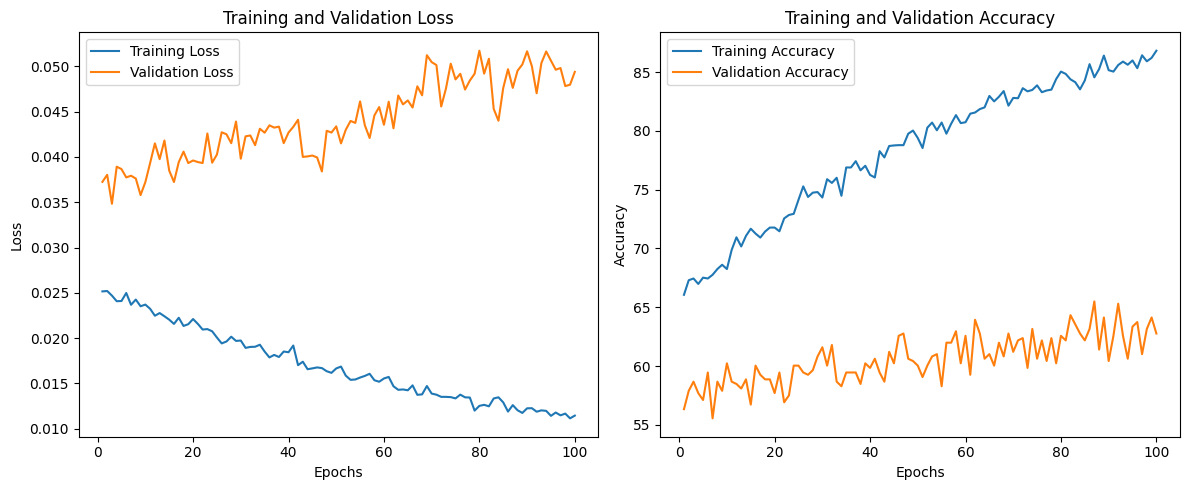

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (artsy full)**

We tested then using the last most promising model.



In [ ]:
model_4.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_4(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0458, Test Accuracy: 65.63%


### **Plotting the confusion matrix**

In [ ]:
import seaborn as sns

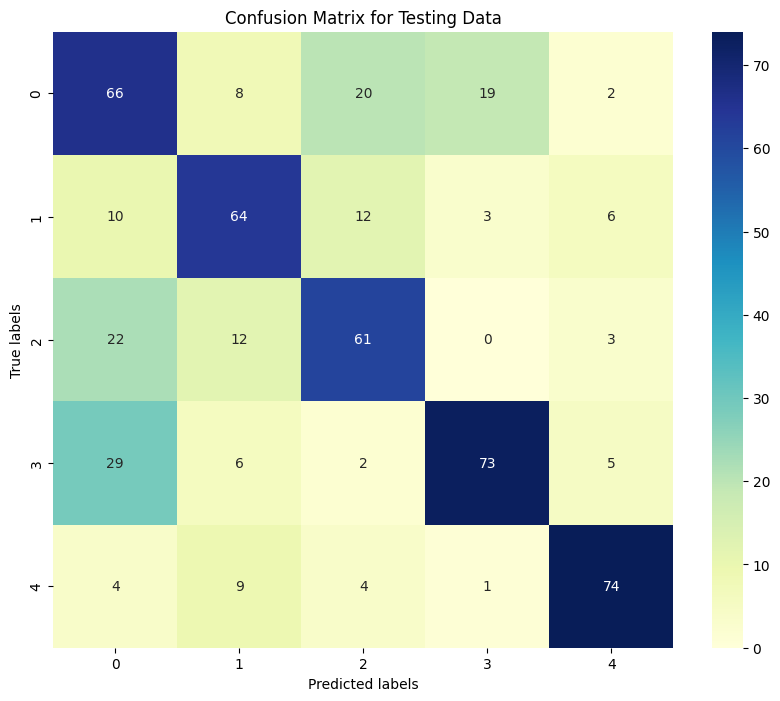

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 0.6656879071976715
Recall: 0.6563106796116505
F1 Score: 0.6591548180642341



# After being done with the Artsy full model, we noticed that the accuracy isn't as high as expected, so we tried to examine the problem creating 3 more models, one with resnet only, one with renset + color histograms, one with resnet + hog

# **Using Resnet only**

## **slicing up resnet features**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels.npy', allow_pickle=True)

In [ ]:
num_bins = 32  # Number of bins used in the color histogram
length_of_color_hist = 3 * num_bins  # Length of color histogram features
# Extracting just the resnet features
resnet_features_only = np.array([features[length_of_color_hist:] for features in art_styles_features])

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(resnet_features_only, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

## **Split the resnet features dataset**

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (resnet only)**

We progressed the training expermint, we started with 100 epochs and tried diffrent learning rates, Adam and SGD optimizers.

we begin with 0.3 drop rate, then increased to 0.5 after noticing some overfitting happening, we tried diffrent learning rates, we adjusted according to our graphs observations and what we think will work best from out experience.

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 107.03it/s, valid_loss=11.6]


Epoch 1/100, Training Loss: 0.0330, Validation Loss: 0.0227, Training Accuracy: 63.53%, Validation Accuracy: 75.24%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 106.74it/s, valid_loss=9.74]


Epoch 2/100, Training Loss: 0.0188, Validation Loss: 0.0190, Training Accuracy: 76.91%, Validation Accuracy: 78.36%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 97.99it/s, valid_loss=8.4]


Epoch 3/100, Training Loss: 0.0163, Validation Loss: 0.0164, Training Accuracy: 80.07%, Validation Accuracy: 78.95%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 92.49it/s, valid_loss=9.26]


Epoch 4/100, Training Loss: 0.0148, Validation Loss: 0.0181, Training Accuracy: 82.58%, Validation Accuracy: 80.70%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 87.60it/s, valid_loss=7.7]


Epoch 5/100, Training Loss: 0.0140, Validation Loss: 0.0150, Training Accuracy: 83.50%, Validation Accuracy: 80.90%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 107.94it/s, valid_loss=8.64]


Epoch 6/100, Training Loss: 0.0130, Validation Loss: 0.0168, Training Accuracy: 84.65%, Validation Accuracy: 81.68%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 108.13it/s, valid_loss=9.49]


Epoch 7/100, Training Loss: 0.0126, Validation Loss: 0.0185, Training Accuracy: 84.89%, Validation Accuracy: 79.73%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 91.72it/s, valid_loss=8.59]


Epoch 8/100, Training Loss: 0.0119, Validation Loss: 0.0167, Training Accuracy: 85.23%, Validation Accuracy: 80.51%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 109.87it/s, valid_loss=7.64]


Epoch 9/100, Training Loss: 0.0115, Validation Loss: 0.0149, Training Accuracy: 85.69%, Validation Accuracy: 81.87%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 94.55it/s, valid_loss=7.5]


Epoch 10/100, Training Loss: 0.0109, Validation Loss: 0.0146, Training Accuracy: 86.98%, Validation Accuracy: 82.26%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 80.03it/s, valid_loss=8.38]


Epoch 11/100, Training Loss: 0.0105, Validation Loss: 0.0163, Training Accuracy: 87.62%, Validation Accuracy: 81.68%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 101.58it/s, valid_loss=8.61]


Epoch 12/100, Training Loss: 0.0098, Validation Loss: 0.0168, Training Accuracy: 88.49%, Validation Accuracy: 82.46%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 98.97it/s, valid_loss=7.83]


Epoch 13/100, Training Loss: 0.0096, Validation Loss: 0.0153, Training Accuracy: 88.69%, Validation Accuracy: 83.04%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 96.34it/s, valid_loss=8.69]


Epoch 14/100, Training Loss: 0.0091, Validation Loss: 0.0169, Training Accuracy: 89.00%, Validation Accuracy: 81.48%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 94.70it/s, valid_loss=8.12] 


Epoch 15/100, Training Loss: 0.0089, Validation Loss: 0.0158, Training Accuracy: 89.46%, Validation Accuracy: 82.65%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 88.48it/s, valid_loss=7.96]


Epoch 16/100, Training Loss: 0.0078, Validation Loss: 0.0155, Training Accuracy: 90.88%, Validation Accuracy: 80.12%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 68.86it/s, valid_loss=8.86]


Epoch 17/100, Training Loss: 0.0079, Validation Loss: 0.0173, Training Accuracy: 90.24%, Validation Accuracy: 82.07%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 101.97it/s, valid_loss=7.99]


Epoch 18/100, Training Loss: 0.0075, Validation Loss: 0.0156, Training Accuracy: 91.58%, Validation Accuracy: 81.29%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 104.10it/s, valid_loss=7.33]


Epoch 19/100, Training Loss: 0.0069, Validation Loss: 0.0143, Training Accuracy: 91.97%, Validation Accuracy: 82.26%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 106.01it/s, valid_loss=9.73]


Epoch 20/100, Training Loss: 0.0068, Validation Loss: 0.0190, Training Accuracy: 92.00%, Validation Accuracy: 82.26%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 102.17it/s, valid_loss=9.18]


Epoch 21/100, Training Loss: 0.0062, Validation Loss: 0.0179, Training Accuracy: 92.90%, Validation Accuracy: 82.85%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 76.54it/s, valid_loss=9.14]


Epoch 22/100, Training Loss: 0.0057, Validation Loss: 0.0178, Training Accuracy: 93.11%, Validation Accuracy: 82.65%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 94.24it/s, valid_loss=9.42]


Epoch 23/100, Training Loss: 0.0053, Validation Loss: 0.0184, Training Accuracy: 94.11%, Validation Accuracy: 83.04%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 103.38it/s, valid_loss=8.16]


Epoch 24/100, Training Loss: 0.0051, Validation Loss: 0.0159, Training Accuracy: 94.18%, Validation Accuracy: 82.65%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 96.95it/s, valid_loss=7.93]


Epoch 25/100, Training Loss: 0.0047, Validation Loss: 0.0155, Training Accuracy: 94.67%, Validation Accuracy: 83.82%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 98.07it/s, valid_loss=8.89]


Epoch 26/100, Training Loss: 0.0046, Validation Loss: 0.0173, Training Accuracy: 95.21%, Validation Accuracy: 83.43%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 90.65it/s, valid_loss=8.26]


Epoch 27/100, Training Loss: 0.0044, Validation Loss: 0.0161, Training Accuracy: 94.96%, Validation Accuracy: 84.02%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 95.90it/s, valid_loss=8.96]


Epoch 28/100, Training Loss: 0.0040, Validation Loss: 0.0175, Training Accuracy: 95.94%, Validation Accuracy: 82.85%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 88.32it/s, valid_loss=10.4]


Epoch 29/100, Training Loss: 0.0035, Validation Loss: 0.0202, Training Accuracy: 96.28%, Validation Accuracy: 81.87%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 112.34it/s, valid_loss=8.61]


Epoch 30/100, Training Loss: 0.0033, Validation Loss: 0.0168, Training Accuracy: 96.79%, Validation Accuracy: 83.04%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 98.19it/s, valid_loss=12.5] 


Epoch 31/100, Training Loss: 0.0031, Validation Loss: 0.0243, Training Accuracy: 96.76%, Validation Accuracy: 82.65%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 104.60it/s, valid_loss=13.9]


Epoch 32/100, Training Loss: 0.0030, Validation Loss: 0.0271, Training Accuracy: 97.03%, Validation Accuracy: 84.02%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 95.43it/s, valid_loss=9.31]


Epoch 33/100, Training Loss: 0.0027, Validation Loss: 0.0182, Training Accuracy: 97.37%, Validation Accuracy: 84.21%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 99.02it/s, valid_loss=9.08]


Epoch 34/100, Training Loss: 0.0025, Validation Loss: 0.0177, Training Accuracy: 97.54%, Validation Accuracy: 84.02%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 93.58it/s, valid_loss=8.41]


Epoch 35/100, Training Loss: 0.0024, Validation Loss: 0.0164, Training Accuracy: 97.64%, Validation Accuracy: 84.02%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 43.74it/s, valid_loss=9.18]


Epoch 36/100, Training Loss: 0.0022, Validation Loss: 0.0179, Training Accuracy: 98.08%, Validation Accuracy: 83.82%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 88.84it/s, valid_loss=8.95]


Epoch 37/100, Training Loss: 0.0023, Validation Loss: 0.0174, Training Accuracy: 97.52%, Validation Accuracy: 83.04%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 95.93it/s, valid_loss=13.6]


Epoch 38/100, Training Loss: 0.0019, Validation Loss: 0.0264, Training Accuracy: 98.13%, Validation Accuracy: 83.24%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 101.18it/s, valid_loss=9.06]


Epoch 39/100, Training Loss: 0.0020, Validation Loss: 0.0177, Training Accuracy: 97.91%, Validation Accuracy: 83.63%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 96.91it/s, valid_loss=9.63]


Epoch 40/100, Training Loss: 0.0017, Validation Loss: 0.0188, Training Accuracy: 98.44%, Validation Accuracy: 84.41%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 106.38it/s, valid_loss=10.9]


Epoch 41/100, Training Loss: 0.0016, Validation Loss: 0.0212, Training Accuracy: 98.69%, Validation Accuracy: 83.63%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 104.39it/s, valid_loss=10.9]


Epoch 42/100, Training Loss: 0.0017, Validation Loss: 0.0212, Training Accuracy: 98.56%, Validation Accuracy: 84.99%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 97.27it/s, valid_loss=9.94]


Epoch 43/100, Training Loss: 0.0015, Validation Loss: 0.0194, Training Accuracy: 98.81%, Validation Accuracy: 84.41%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 87.60it/s, valid_loss=13.1]


Epoch 44/100, Training Loss: 0.0013, Validation Loss: 0.0255, Training Accuracy: 98.91%, Validation Accuracy: 84.02%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 94.23it/s, valid_loss=11.8] 


Epoch 45/100, Training Loss: 0.0013, Validation Loss: 0.0230, Training Accuracy: 98.93%, Validation Accuracy: 84.60%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 88.40it/s, valid_loss=9.67]


Epoch 46/100, Training Loss: 0.0013, Validation Loss: 0.0189, Training Accuracy: 99.05%, Validation Accuracy: 84.02%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 100.06it/s, valid_loss=11.6]


Epoch 47/100, Training Loss: 0.0013, Validation Loss: 0.0226, Training Accuracy: 98.73%, Validation Accuracy: 84.41%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 106.27it/s, valid_loss=10.4]


Epoch 48/100, Training Loss: 0.0010, Validation Loss: 0.0202, Training Accuracy: 99.37%, Validation Accuracy: 83.63%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 109.72it/s, valid_loss=10.7]


Epoch 49/100, Training Loss: 0.0008, Validation Loss: 0.0210, Training Accuracy: 99.32%, Validation Accuracy: 84.21%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 93.60it/s, valid_loss=10.7]


Epoch 50/100, Training Loss: 0.0010, Validation Loss: 0.0209, Training Accuracy: 99.00%, Validation Accuracy: 84.41%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 97.60it/s, valid_loss=14.5]


Epoch 51/100, Training Loss: 0.0013, Validation Loss: 0.0283, Training Accuracy: 98.83%, Validation Accuracy: 84.41%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 76.56it/s, valid_loss=10.5]


Epoch 52/100, Training Loss: 0.0010, Validation Loss: 0.0205, Training Accuracy: 99.15%, Validation Accuracy: 82.26%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 69.14it/s, valid_loss=12.6]


Epoch 53/100, Training Loss: 0.0009, Validation Loss: 0.0245, Training Accuracy: 99.34%, Validation Accuracy: 84.41%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 99.56it/s, valid_loss=12.5]


Epoch 54/100, Training Loss: 0.0008, Validation Loss: 0.0244, Training Accuracy: 99.39%, Validation Accuracy: 83.82%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 98.98it/s, valid_loss=10.8]


Epoch 55/100, Training Loss: 0.0010, Validation Loss: 0.0211, Training Accuracy: 99.08%, Validation Accuracy: 84.80%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 105.93it/s, valid_loss=11.4]


Epoch 56/100, Training Loss: 0.0010, Validation Loss: 0.0223, Training Accuracy: 99.22%, Validation Accuracy: 84.80%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 88.93it/s, valid_loss=13.6]


Epoch 57/100, Training Loss: 0.0010, Validation Loss: 0.0265, Training Accuracy: 99.08%, Validation Accuracy: 84.80%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 87.34it/s, valid_loss=11.9]


Epoch 58/100, Training Loss: 0.0010, Validation Loss: 0.0231, Training Accuracy: 98.88%, Validation Accuracy: 84.41%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 104.39it/s, valid_loss=13]


Epoch 59/100, Training Loss: 0.0010, Validation Loss: 0.0253, Training Accuracy: 99.05%, Validation Accuracy: 84.60%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 91.28it/s, valid_loss=11.3]


Epoch 60/100, Training Loss: 0.0010, Validation Loss: 0.0220, Training Accuracy: 98.95%, Validation Accuracy: 84.41%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 95.78it/s, valid_loss=12.1]


Epoch 61/100, Training Loss: 0.0007, Validation Loss: 0.0236, Training Accuracy: 99.42%, Validation Accuracy: 84.21%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 109.35it/s, valid_loss=12.4]


Epoch 62/100, Training Loss: 0.0008, Validation Loss: 0.0242, Training Accuracy: 99.17%, Validation Accuracy: 84.60%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 86.20it/s, valid_loss=12.3]


Epoch 63/100, Training Loss: 0.0006, Validation Loss: 0.0239, Training Accuracy: 99.51%, Validation Accuracy: 84.60%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 92.31it/s, valid_loss=11.4]


Epoch 64/100, Training Loss: 0.0007, Validation Loss: 0.0222, Training Accuracy: 99.32%, Validation Accuracy: 84.41%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 101.61it/s, valid_loss=11.3]


Epoch 65/100, Training Loss: 0.0008, Validation Loss: 0.0219, Training Accuracy: 99.29%, Validation Accuracy: 83.04%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 100.82it/s, valid_loss=11.3]


Epoch 66/100, Training Loss: 0.0009, Validation Loss: 0.0221, Training Accuracy: 99.17%, Validation Accuracy: 83.82%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 95.73it/s, valid_loss=15.8]


Epoch 67/100, Training Loss: 0.0010, Validation Loss: 0.0308, Training Accuracy: 98.78%, Validation Accuracy: 82.85%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 87.53it/s, valid_loss=12.8]


Epoch 68/100, Training Loss: 0.0006, Validation Loss: 0.0249, Training Accuracy: 99.34%, Validation Accuracy: 84.41%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 91.66it/s, valid_loss=11.9]


Epoch 69/100, Training Loss: 0.0007, Validation Loss: 0.0232, Training Accuracy: 99.42%, Validation Accuracy: 82.65%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 99.08it/s, valid_loss=11.7]


Epoch 70/100, Training Loss: 0.0006, Validation Loss: 0.0227, Training Accuracy: 99.49%, Validation Accuracy: 84.80%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 95.22it/s, valid_loss=11.6]


Epoch 71/100, Training Loss: 0.0005, Validation Loss: 0.0226, Training Accuracy: 99.54%, Validation Accuracy: 84.99%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 87.25it/s, valid_loss=12.4]


Epoch 72/100, Training Loss: 0.0006, Validation Loss: 0.0242, Training Accuracy: 99.34%, Validation Accuracy: 84.41%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 91.47it/s, valid_loss=12.6]


Epoch 73/100, Training Loss: 0.0007, Validation Loss: 0.0246, Training Accuracy: 99.25%, Validation Accuracy: 84.99%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 95.88it/s, valid_loss=11.7]


Epoch 74/100, Training Loss: 0.0007, Validation Loss: 0.0228, Training Accuracy: 99.29%, Validation Accuracy: 85.77%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 111.76it/s, valid_loss=14.7]


Epoch 75/100, Training Loss: 0.0007, Validation Loss: 0.0287, Training Accuracy: 99.20%, Validation Accuracy: 84.60%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 92.55it/s, valid_loss=12]


Epoch 76/100, Training Loss: 0.0007, Validation Loss: 0.0233, Training Accuracy: 99.34%, Validation Accuracy: 84.80%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 105.26it/s, valid_loss=13]


Epoch 77/100, Training Loss: 0.0007, Validation Loss: 0.0254, Training Accuracy: 99.32%, Validation Accuracy: 84.41%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 98.73it/s, valid_loss=12.4] 


Epoch 78/100, Training Loss: 0.0006, Validation Loss: 0.0242, Training Accuracy: 99.42%, Validation Accuracy: 84.41%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 86.72it/s, valid_loss=12.4]


Epoch 79/100, Training Loss: 0.0005, Validation Loss: 0.0242, Training Accuracy: 99.56%, Validation Accuracy: 84.02%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 104.87it/s, valid_loss=11.7]


Epoch 80/100, Training Loss: 0.0004, Validation Loss: 0.0229, Training Accuracy: 99.61%, Validation Accuracy: 84.41%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 94.47it/s, valid_loss=14.9]


Epoch 81/100, Training Loss: 0.0017, Validation Loss: 0.0290, Training Accuracy: 98.03%, Validation Accuracy: 84.99%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 91.07it/s, valid_loss=12.5]


Epoch 82/100, Training Loss: 0.0009, Validation Loss: 0.0244, Training Accuracy: 98.98%, Validation Accuracy: 85.19%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 108.93it/s, valid_loss=16.5]


Epoch 83/100, Training Loss: 0.0005, Validation Loss: 0.0322, Training Accuracy: 99.46%, Validation Accuracy: 84.99%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 110.11it/s, valid_loss=14.1]


Epoch 84/100, Training Loss: 0.0006, Validation Loss: 0.0275, Training Accuracy: 99.34%, Validation Accuracy: 84.60%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 107.24it/s, valid_loss=14]


Epoch 85/100, Training Loss: 0.0006, Validation Loss: 0.0274, Training Accuracy: 99.46%, Validation Accuracy: 84.41%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 88.03it/s, valid_loss=12.3]


Epoch 86/100, Training Loss: 0.0004, Validation Loss: 0.0239, Training Accuracy: 99.51%, Validation Accuracy: 84.41%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 83.61it/s, valid_loss=12.9]


Epoch 87/100, Training Loss: 0.0005, Validation Loss: 0.0252, Training Accuracy: 99.56%, Validation Accuracy: 84.21%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 86.77it/s, valid_loss=13.8]


Epoch 88/100, Training Loss: 0.0007, Validation Loss: 0.0269, Training Accuracy: 99.20%, Validation Accuracy: 85.19%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 65.55it/s, valid_loss=13.5]


Epoch 89/100, Training Loss: 0.0006, Validation Loss: 0.0263, Training Accuracy: 99.32%, Validation Accuracy: 82.85%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 39.30it/s, valid_loss=12.7]


Epoch 90/100, Training Loss: 0.0006, Validation Loss: 0.0248, Training Accuracy: 99.42%, Validation Accuracy: 84.60%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 60.28it/s, valid_loss=12.1]


Epoch 91/100, Training Loss: 0.0005, Validation Loss: 0.0236, Training Accuracy: 99.46%, Validation Accuracy: 84.41%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 89.40it/s, valid_loss=13.1]


Epoch 92/100, Training Loss: 0.0006, Validation Loss: 0.0256, Training Accuracy: 99.27%, Validation Accuracy: 84.41%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 91.77it/s, valid_loss=12.9]


Epoch 93/100, Training Loss: 0.0004, Validation Loss: 0.0251, Training Accuracy: 99.59%, Validation Accuracy: 84.41%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 92.97it/s, valid_loss=13.3]


Epoch 94/100, Training Loss: 0.0005, Validation Loss: 0.0258, Training Accuracy: 99.37%, Validation Accuracy: 84.60%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 93.96it/s, valid_loss=16.2]


Epoch 95/100, Training Loss: 0.0005, Validation Loss: 0.0316, Training Accuracy: 99.49%, Validation Accuracy: 84.99%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 104.84it/s, valid_loss=15.9]


Epoch 96/100, Training Loss: 0.0004, Validation Loss: 0.0310, Training Accuracy: 99.59%, Validation Accuracy: 84.41%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 93.28it/s, valid_loss=14]


Epoch 97/100, Training Loss: 0.0004, Validation Loss: 0.0272, Training Accuracy: 99.56%, Validation Accuracy: 83.63%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 83.54it/s, valid_loss=12.9]


Epoch 98/100, Training Loss: 0.0010, Validation Loss: 0.0251, Training Accuracy: 98.81%, Validation Accuracy: 84.41%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 96.50it/s, valid_loss=15.5]


Epoch 99/100, Training Loss: 0.0007, Validation Loss: 0.0303, Training Accuracy: 99.17%, Validation Accuracy: 83.43%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 97.67it/s, valid_loss=20.9] 


Epoch 100/100, Training Loss: 0.0004, Validation Loss: 0.0407, Training Accuracy: 99.51%, Validation Accuracy: 82.65%


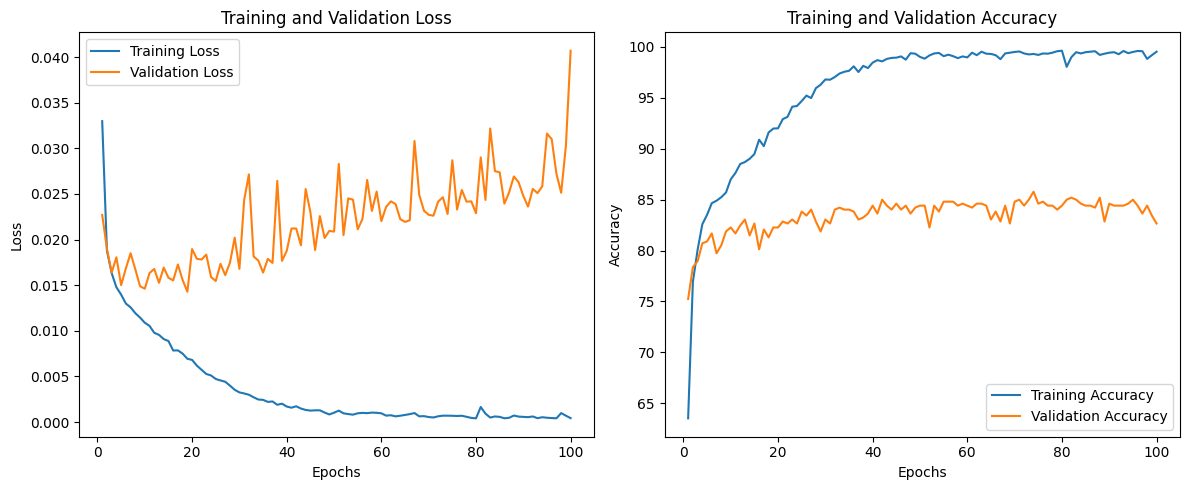

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (resnet only)**

In [ ]:
model_3.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_3(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0308, Test Accuracy: 83.11%


In [ ]:
import seaborn as sns

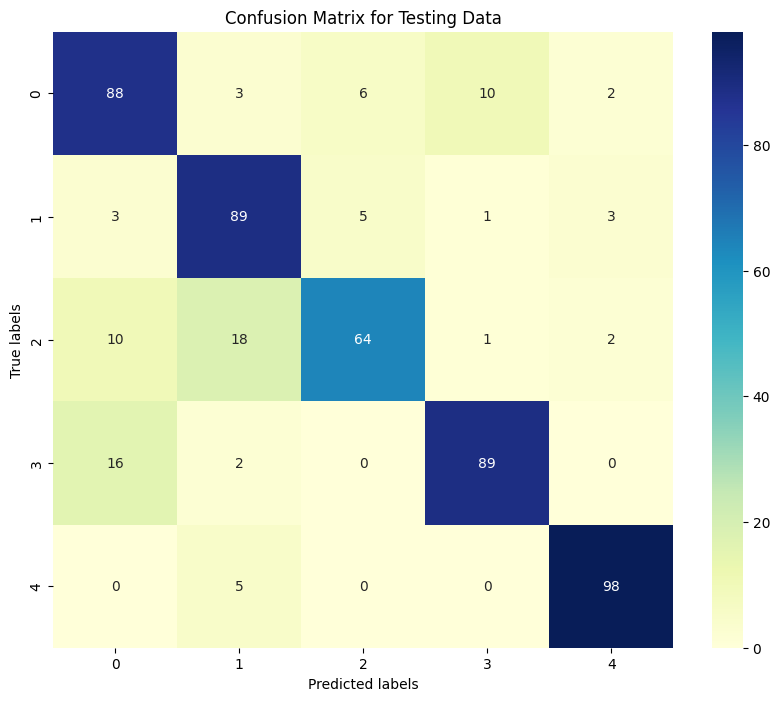

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 0.8355322223783244
Recall: 0.8310679611650486
F1 Score: 0.8301111794663596


# **using Resnet + color histograms**

## **slicing and splitting the dataset**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features.npy', allow_pickle=True)
art_styles_features_hog = np.load('/content/drive/MyDrive/art_styles_features_hog.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels.npy', allow_pickle=True)

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(art_styles_features, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (Resnet + color histograms)**

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 98.91it/s, valid_loss=163] 


Epoch 1/100, Training Loss: 1.1578, Validation Loss: 0.3179, Training Accuracy: 31.07%, Validation Accuracy: 40.16%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 103.02it/s, valid_loss=99.1]


Epoch 2/100, Training Loss: 0.4868, Validation Loss: 0.1931, Training Accuracy: 34.89%, Validation Accuracy: 38.79%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 97.52it/s, valid_loss=50.4]


Epoch 3/100, Training Loss: 0.2950, Validation Loss: 0.0983, Training Accuracy: 35.55%, Validation Accuracy: 36.26%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 71.80it/s, valid_loss=36.1]


Epoch 4/100, Training Loss: 0.1874, Validation Loss: 0.0703, Training Accuracy: 35.60%, Validation Accuracy: 34.11%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 78.20it/s, valid_loss=29.7]


Epoch 5/100, Training Loss: 0.1185, Validation Loss: 0.0579, Training Accuracy: 34.62%, Validation Accuracy: 32.55%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 97.23it/s, valid_loss=27.1]


Epoch 6/100, Training Loss: 0.0908, Validation Loss: 0.0528, Training Accuracy: 34.33%, Validation Accuracy: 30.21%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 100.36it/s, valid_loss=26.1]


Epoch 7/100, Training Loss: 0.0756, Validation Loss: 0.0508, Training Accuracy: 34.82%, Validation Accuracy: 28.46%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 93.33it/s, valid_loss=26.1]


Epoch 8/100, Training Loss: 0.0646, Validation Loss: 0.0509, Training Accuracy: 35.09%, Validation Accuracy: 28.46%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 102.50it/s, valid_loss=25.6]


Epoch 9/100, Training Loss: 0.0605, Validation Loss: 0.0500, Training Accuracy: 34.26%, Validation Accuracy: 28.07%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 111.64it/s, valid_loss=25.6]


Epoch 10/100, Training Loss: 0.0562, Validation Loss: 0.0500, Training Accuracy: 32.68%, Validation Accuracy: 28.27%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 93.70it/s, valid_loss=25.4]


Epoch 11/100, Training Loss: 0.0519, Validation Loss: 0.0496, Training Accuracy: 34.38%, Validation Accuracy: 27.88%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 83.01it/s, valid_loss=25.2]


Epoch 12/100, Training Loss: 0.0513, Validation Loss: 0.0491, Training Accuracy: 34.06%, Validation Accuracy: 27.10%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 69.91it/s, valid_loss=24.8]


Epoch 13/100, Training Loss: 0.0497, Validation Loss: 0.0484, Training Accuracy: 33.28%, Validation Accuracy: 28.65%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 88.51it/s, valid_loss=24.7]


Epoch 14/100, Training Loss: 0.0488, Validation Loss: 0.0481, Training Accuracy: 34.67%, Validation Accuracy: 27.88%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 98.09it/s, valid_loss=24.3]


Epoch 15/100, Training Loss: 0.0477, Validation Loss: 0.0474, Training Accuracy: 35.23%, Validation Accuracy: 29.04%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 96.92it/s, valid_loss=24.5]


Epoch 16/100, Training Loss: 0.0477, Validation Loss: 0.0479, Training Accuracy: 35.33%, Validation Accuracy: 29.63%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 90.59it/s, valid_loss=24.5]


Epoch 17/100, Training Loss: 0.0464, Validation Loss: 0.0478, Training Accuracy: 35.60%, Validation Accuracy: 29.82%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 104.56it/s, valid_loss=24.5]


Epoch 18/100, Training Loss: 0.0460, Validation Loss: 0.0478, Training Accuracy: 36.08%, Validation Accuracy: 31.77%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 93.08it/s, valid_loss=24.3]


Epoch 19/100, Training Loss: 0.0452, Validation Loss: 0.0473, Training Accuracy: 36.59%, Validation Accuracy: 31.97%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 90.99it/s, valid_loss=24]


Epoch 20/100, Training Loss: 0.0450, Validation Loss: 0.0468, Training Accuracy: 37.79%, Validation Accuracy: 33.14%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 92.95it/s, valid_loss=23.9]


Epoch 21/100, Training Loss: 0.0446, Validation Loss: 0.0466, Training Accuracy: 37.49%, Validation Accuracy: 34.70%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 100.20it/s, valid_loss=23.9]


Epoch 22/100, Training Loss: 0.0451, Validation Loss: 0.0466, Training Accuracy: 38.44%, Validation Accuracy: 35.87%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 92.94it/s, valid_loss=23.8]


Epoch 23/100, Training Loss: 0.0443, Validation Loss: 0.0464, Training Accuracy: 38.30%, Validation Accuracy: 34.31%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 93.67it/s, valid_loss=23.6]


Epoch 24/100, Training Loss: 0.0440, Validation Loss: 0.0461, Training Accuracy: 37.91%, Validation Accuracy: 38.99%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 92.25it/s, valid_loss=23.5]


Epoch 25/100, Training Loss: 0.0433, Validation Loss: 0.0458, Training Accuracy: 38.76%, Validation Accuracy: 39.77%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 92.36it/s, valid_loss=23.3]


Epoch 26/100, Training Loss: 0.0438, Validation Loss: 0.0454, Training Accuracy: 38.20%, Validation Accuracy: 41.33%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 92.69it/s, valid_loss=23.6]


Epoch 27/100, Training Loss: 0.0440, Validation Loss: 0.0460, Training Accuracy: 38.20%, Validation Accuracy: 36.45%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 91.13it/s, valid_loss=23.3]


Epoch 28/100, Training Loss: 0.0428, Validation Loss: 0.0455, Training Accuracy: 39.61%, Validation Accuracy: 37.43%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 100.53it/s, valid_loss=23.2]


Epoch 29/100, Training Loss: 0.0430, Validation Loss: 0.0451, Training Accuracy: 39.17%, Validation Accuracy: 38.60%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 83.38it/s, valid_loss=23.2]


Epoch 30/100, Training Loss: 0.0433, Validation Loss: 0.0452, Training Accuracy: 38.98%, Validation Accuracy: 39.77%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 97.88it/s, valid_loss=23.1]


Epoch 31/100, Training Loss: 0.0429, Validation Loss: 0.0450, Training Accuracy: 40.12%, Validation Accuracy: 41.33%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 93.39it/s, valid_loss=23.2]


Epoch 32/100, Training Loss: 0.0426, Validation Loss: 0.0453, Training Accuracy: 40.24%, Validation Accuracy: 38.01%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 92.81it/s, valid_loss=23]


Epoch 33/100, Training Loss: 0.0421, Validation Loss: 0.0447, Training Accuracy: 40.32%, Validation Accuracy: 41.52%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 93.25it/s, valid_loss=23.2]


Epoch 34/100, Training Loss: 0.0425, Validation Loss: 0.0452, Training Accuracy: 41.46%, Validation Accuracy: 39.77%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 88.77it/s, valid_loss=23.1]


Epoch 35/100, Training Loss: 0.0419, Validation Loss: 0.0451, Training Accuracy: 40.90%, Validation Accuracy: 39.77%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 71.85it/s, valid_loss=22.9]


Epoch 36/100, Training Loss: 0.0419, Validation Loss: 0.0446, Training Accuracy: 42.19%, Validation Accuracy: 40.74%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 89.39it/s, valid_loss=23]


Epoch 37/100, Training Loss: 0.0419, Validation Loss: 0.0449, Training Accuracy: 40.97%, Validation Accuracy: 40.16%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 99.59it/s, valid_loss=23.2]


Epoch 38/100, Training Loss: 0.0416, Validation Loss: 0.0452, Training Accuracy: 43.09%, Validation Accuracy: 42.88%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 92.26it/s, valid_loss=23.3]


Epoch 39/100, Training Loss: 0.0414, Validation Loss: 0.0454, Training Accuracy: 42.75%, Validation Accuracy: 40.94%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 92.59it/s, valid_loss=22.4]


Epoch 40/100, Training Loss: 0.0412, Validation Loss: 0.0437, Training Accuracy: 42.77%, Validation Accuracy: 42.30%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 88.17it/s, valid_loss=22.8]


Epoch 41/100, Training Loss: 0.0411, Validation Loss: 0.0444, Training Accuracy: 42.60%, Validation Accuracy: 42.11%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 97.01it/s, valid_loss=22.4] 


Epoch 42/100, Training Loss: 0.0409, Validation Loss: 0.0437, Training Accuracy: 42.92%, Validation Accuracy: 44.05%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 87.28it/s, valid_loss=22.4]


Epoch 43/100, Training Loss: 0.0408, Validation Loss: 0.0436, Training Accuracy: 45.18%, Validation Accuracy: 42.88%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 85.29it/s, valid_loss=22.3]


Epoch 44/100, Training Loss: 0.0410, Validation Loss: 0.0434, Training Accuracy: 43.82%, Validation Accuracy: 44.25%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 98.40it/s, valid_loss=22.1]


Epoch 45/100, Training Loss: 0.0407, Validation Loss: 0.0431, Training Accuracy: 44.87%, Validation Accuracy: 45.03%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 100.48it/s, valid_loss=22.3]


Epoch 46/100, Training Loss: 0.0405, Validation Loss: 0.0435, Training Accuracy: 45.16%, Validation Accuracy: 44.05%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 100.40it/s, valid_loss=22.5]


Epoch 47/100, Training Loss: 0.0405, Validation Loss: 0.0438, Training Accuracy: 45.11%, Validation Accuracy: 45.03%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 96.74it/s, valid_loss=22.3] 


Epoch 48/100, Training Loss: 0.0405, Validation Loss: 0.0435, Training Accuracy: 44.26%, Validation Accuracy: 46.00%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 107.24it/s, valid_loss=22.6]


Epoch 49/100, Training Loss: 0.0393, Validation Loss: 0.0440, Training Accuracy: 46.57%, Validation Accuracy: 45.42%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 105.92it/s, valid_loss=21.9]


Epoch 50/100, Training Loss: 0.0400, Validation Loss: 0.0426, Training Accuracy: 45.72%, Validation Accuracy: 45.61%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 83.77it/s, valid_loss=21.7]


Epoch 51/100, Training Loss: 0.0395, Validation Loss: 0.0423, Training Accuracy: 46.08%, Validation Accuracy: 45.42%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 89.44it/s, valid_loss=22.1]


Epoch 52/100, Training Loss: 0.0390, Validation Loss: 0.0430, Training Accuracy: 47.32%, Validation Accuracy: 43.08%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 100.96it/s, valid_loss=21.9]


Epoch 53/100, Training Loss: 0.0389, Validation Loss: 0.0428, Training Accuracy: 47.15%, Validation Accuracy: 45.42%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 94.22it/s, valid_loss=21.8]


Epoch 54/100, Training Loss: 0.0389, Validation Loss: 0.0426, Training Accuracy: 46.96%, Validation Accuracy: 44.64%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 86.00it/s, valid_loss=21.9]


Epoch 55/100, Training Loss: 0.0394, Validation Loss: 0.0426, Training Accuracy: 46.01%, Validation Accuracy: 45.61%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 94.88it/s, valid_loss=21.5]


Epoch 56/100, Training Loss: 0.0383, Validation Loss: 0.0420, Training Accuracy: 48.03%, Validation Accuracy: 46.59%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 103.05it/s, valid_loss=21.5]


Epoch 57/100, Training Loss: 0.0385, Validation Loss: 0.0420, Training Accuracy: 47.79%, Validation Accuracy: 46.78%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 96.63it/s, valid_loss=21.9]


Epoch 58/100, Training Loss: 0.0381, Validation Loss: 0.0427, Training Accuracy: 49.10%, Validation Accuracy: 48.93%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 103.85it/s, valid_loss=21.9]


Epoch 59/100, Training Loss: 0.0381, Validation Loss: 0.0428, Training Accuracy: 47.62%, Validation Accuracy: 48.34%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 88.89it/s, valid_loss=21.6]


Epoch 60/100, Training Loss: 0.0380, Validation Loss: 0.0421, Training Accuracy: 48.00%, Validation Accuracy: 48.54%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 80.38it/s, valid_loss=21.7]


Epoch 61/100, Training Loss: 0.0377, Validation Loss: 0.0423, Training Accuracy: 49.54%, Validation Accuracy: 46.98%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 95.40it/s, valid_loss=21.5]


Epoch 62/100, Training Loss: 0.0371, Validation Loss: 0.0419, Training Accuracy: 49.27%, Validation Accuracy: 49.32%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 86.26it/s, valid_loss=22]


Epoch 63/100, Training Loss: 0.0369, Validation Loss: 0.0430, Training Accuracy: 49.83%, Validation Accuracy: 48.34%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 99.39it/s, valid_loss=21.5]


Epoch 64/100, Training Loss: 0.0372, Validation Loss: 0.0418, Training Accuracy: 50.15%, Validation Accuracy: 46.98%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 101.57it/s, valid_loss=21.8]


Epoch 65/100, Training Loss: 0.0364, Validation Loss: 0.0425, Training Accuracy: 50.83%, Validation Accuracy: 47.56%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 104.64it/s, valid_loss=21.2]


Epoch 66/100, Training Loss: 0.0360, Validation Loss: 0.0414, Training Accuracy: 51.29%, Validation Accuracy: 50.88%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 109.28it/s, valid_loss=20.5]


Epoch 67/100, Training Loss: 0.0357, Validation Loss: 0.0399, Training Accuracy: 51.75%, Validation Accuracy: 47.76%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 88.43it/s, valid_loss=20.9]


Epoch 68/100, Training Loss: 0.0361, Validation Loss: 0.0408, Training Accuracy: 51.36%, Validation Accuracy: 49.32%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 90.44it/s, valid_loss=20.4]


Epoch 69/100, Training Loss: 0.0362, Validation Loss: 0.0398, Training Accuracy: 51.29%, Validation Accuracy: 49.32%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 83.07it/s, valid_loss=20.2]


Epoch 70/100, Training Loss: 0.0351, Validation Loss: 0.0394, Training Accuracy: 52.51%, Validation Accuracy: 50.29%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 99.67it/s, valid_loss=19.7]


Epoch 71/100, Training Loss: 0.0348, Validation Loss: 0.0385, Training Accuracy: 52.94%, Validation Accuracy: 49.32%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 99.61it/s, valid_loss=20]


Epoch 72/100, Training Loss: 0.0350, Validation Loss: 0.0390, Training Accuracy: 53.45%, Validation Accuracy: 50.29%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 90.40it/s, valid_loss=20.1]


Epoch 73/100, Training Loss: 0.0349, Validation Loss: 0.0393, Training Accuracy: 52.65%, Validation Accuracy: 51.07%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 106.77it/s, valid_loss=19.8]


Epoch 74/100, Training Loss: 0.0345, Validation Loss: 0.0385, Training Accuracy: 53.26%, Validation Accuracy: 50.10%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 98.80it/s, valid_loss=20.1]


Epoch 75/100, Training Loss: 0.0346, Validation Loss: 0.0392, Training Accuracy: 53.28%, Validation Accuracy: 50.68%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 98.88it/s, valid_loss=19.8]


Epoch 76/100, Training Loss: 0.0338, Validation Loss: 0.0387, Training Accuracy: 55.06%, Validation Accuracy: 51.66%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 92.55it/s, valid_loss=20.7]


Epoch 77/100, Training Loss: 0.0340, Validation Loss: 0.0403, Training Accuracy: 54.53%, Validation Accuracy: 51.27%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 85.97it/s, valid_loss=20.8]


Epoch 78/100, Training Loss: 0.0344, Validation Loss: 0.0405, Training Accuracy: 53.58%, Validation Accuracy: 50.49%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 103.91it/s, valid_loss=19.8]


Epoch 79/100, Training Loss: 0.0334, Validation Loss: 0.0385, Training Accuracy: 54.79%, Validation Accuracy: 51.85%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 94.35it/s, valid_loss=20.2]


Epoch 80/100, Training Loss: 0.0335, Validation Loss: 0.0394, Training Accuracy: 54.53%, Validation Accuracy: 52.05%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 81.06it/s, valid_loss=20.4]


Epoch 81/100, Training Loss: 0.0334, Validation Loss: 0.0397, Training Accuracy: 55.18%, Validation Accuracy: 50.29%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 36.66it/s, valid_loss=20.5]


Epoch 82/100, Training Loss: 0.0328, Validation Loss: 0.0399, Training Accuracy: 55.21%, Validation Accuracy: 52.05%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 100.94it/s, valid_loss=20.4]


Epoch 83/100, Training Loss: 0.0329, Validation Loss: 0.0398, Training Accuracy: 56.59%, Validation Accuracy: 52.05%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 109.24it/s, valid_loss=20.5]


Epoch 84/100, Training Loss: 0.0323, Validation Loss: 0.0400, Training Accuracy: 54.72%, Validation Accuracy: 48.73%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 84.57it/s, valid_loss=19.9]


Epoch 85/100, Training Loss: 0.0320, Validation Loss: 0.0388, Training Accuracy: 56.52%, Validation Accuracy: 53.41%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 87.70it/s, valid_loss=20.4]


Epoch 86/100, Training Loss: 0.0321, Validation Loss: 0.0398, Training Accuracy: 56.93%, Validation Accuracy: 51.66%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 93.78it/s, valid_loss=20.7]


Epoch 87/100, Training Loss: 0.0312, Validation Loss: 0.0403, Training Accuracy: 57.79%, Validation Accuracy: 52.83%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 93.73it/s, valid_loss=20.2]


Epoch 88/100, Training Loss: 0.0314, Validation Loss: 0.0393, Training Accuracy: 57.08%, Validation Accuracy: 51.85%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 86.07it/s, valid_loss=20.2]


Epoch 89/100, Training Loss: 0.0310, Validation Loss: 0.0393, Training Accuracy: 58.39%, Validation Accuracy: 51.85%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 91.55it/s, valid_loss=20.7]


Epoch 90/100, Training Loss: 0.0310, Validation Loss: 0.0403, Training Accuracy: 58.59%, Validation Accuracy: 53.80%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 88.78it/s, valid_loss=19.9]


Epoch 91/100, Training Loss: 0.0303, Validation Loss: 0.0388, Training Accuracy: 59.05%, Validation Accuracy: 54.00%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 100.82it/s, valid_loss=20.1]


Epoch 92/100, Training Loss: 0.0306, Validation Loss: 0.0391, Training Accuracy: 58.88%, Validation Accuracy: 54.58%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 99.56it/s, valid_loss=20] 


Epoch 93/100, Training Loss: 0.0303, Validation Loss: 0.0389, Training Accuracy: 58.98%, Validation Accuracy: 54.19%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 85.80it/s, valid_loss=20.2]


Epoch 94/100, Training Loss: 0.0290, Validation Loss: 0.0393, Training Accuracy: 60.83%, Validation Accuracy: 54.78%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 83.48it/s, valid_loss=20.7]


Epoch 95/100, Training Loss: 0.0298, Validation Loss: 0.0404, Training Accuracy: 59.39%, Validation Accuracy: 53.80%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 84.58it/s, valid_loss=20.3]


Epoch 96/100, Training Loss: 0.0292, Validation Loss: 0.0395, Training Accuracy: 60.73%, Validation Accuracy: 53.80%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 104.84it/s, valid_loss=20]


Epoch 97/100, Training Loss: 0.0297, Validation Loss: 0.0390, Training Accuracy: 60.92%, Validation Accuracy: 54.19%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 92.94it/s, valid_loss=20.6]


Epoch 98/100, Training Loss: 0.0292, Validation Loss: 0.0401, Training Accuracy: 59.98%, Validation Accuracy: 54.00%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 105.39it/s, valid_loss=20.6]


Epoch 99/100, Training Loss: 0.0287, Validation Loss: 0.0401, Training Accuracy: 62.36%, Validation Accuracy: 53.80%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 101.04it/s, valid_loss=21]

Epoch 100/100, Training Loss: 0.0282, Validation Loss: 0.0408, Training Accuracy: 62.48%, Validation Accuracy: 52.83%


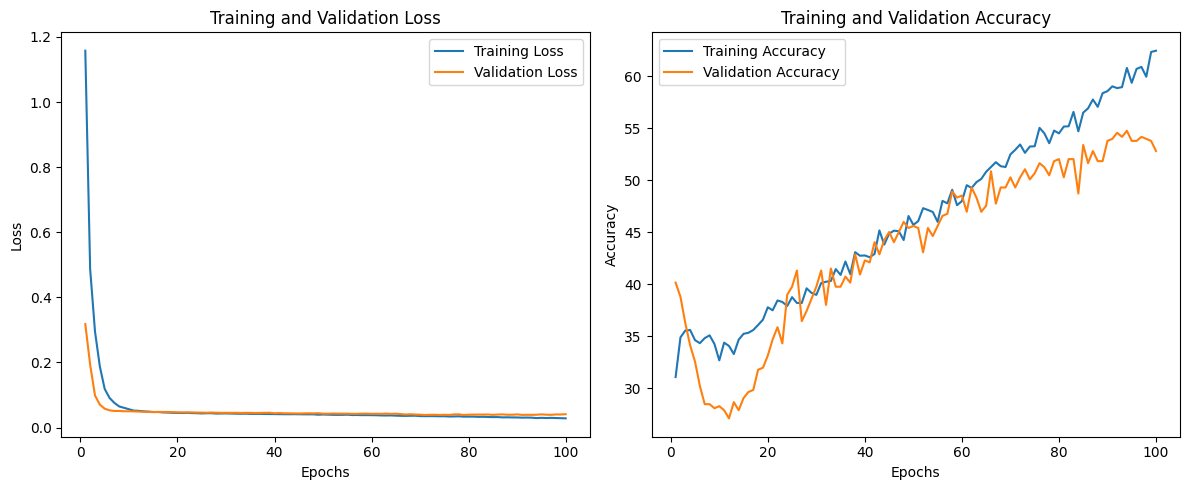

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (Resnet + color histogram)**

In [ ]:
model_3.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_3(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0374, Test Accuracy: 56.89%


In [ ]:
import seaborn as sns

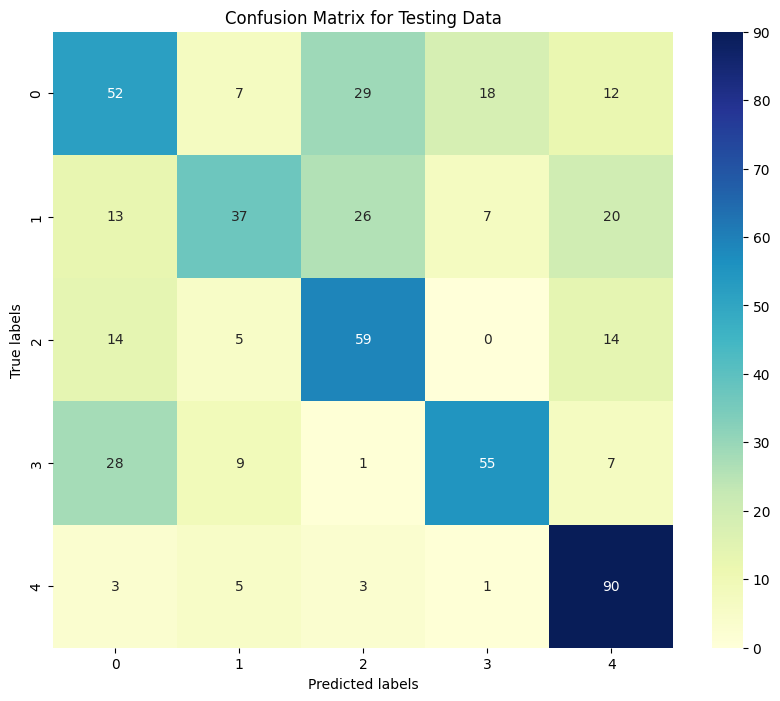

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np


# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 0.5715940202671594
Recall: 0.5689320388349515
F1 Score: 0.5575683850923044


# **using Resnet + HOG (hitsorgram of oriented gradients)**

## **slicing and splitting the dataset**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features.npy', allow_pickle=True)
art_styles_features_hog = np.load('/content/drive/MyDrive/art_styles_features_hog.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels.npy', allow_pickle=True)

In [ ]:
num_bins = 32  # Number of bins used in the color histogram
length_of_color_hist = 3 * num_bins  # Length of color histogram features
# Extracting just the resnet features
resnet_features_only = np.array([features[length_of_color_hist:] for features in art_styles_features])

In [ ]:
combined_features_dataset = np.concatenate((resnet_features_only, art_styles_features_hog), axis=1)

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(combined_features_dataset, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (Resnet + hog)**

We progressed the training expermint, we started with 100 epochs and tried diffrent learning rates, Adam and SGD optimizers.

we begin with 0.3 drop rate, then increased to 0.5 after noticing some overfitting happening, we tried diffrent learning rates, we adjusted according to our graphs observations and what we think will work best from out experience.

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 79.38it/s, valid_loss=12.5]


Epoch 1/100, Training Loss: 0.0343, Validation Loss: 0.0243, Training Accuracy: 58.83%, Validation Accuracy: 74.46%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 71.78it/s, valid_loss=9.41]


Epoch 2/100, Training Loss: 0.0205, Validation Loss: 0.0183, Training Accuracy: 75.40%, Validation Accuracy: 78.56%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 77.96it/s, valid_loss=8.54]


Epoch 3/100, Training Loss: 0.0173, Validation Loss: 0.0166, Training Accuracy: 79.32%, Validation Accuracy: 79.34%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 87.81it/s, valid_loss=7.93]


Epoch 4/100, Training Loss: 0.0156, Validation Loss: 0.0155, Training Accuracy: 81.39%, Validation Accuracy: 81.48%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 77.63it/s, valid_loss=7.53]


Epoch 5/100, Training Loss: 0.0144, Validation Loss: 0.0147, Training Accuracy: 82.34%, Validation Accuracy: 82.65%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 91.41it/s, valid_loss=7.28]


Epoch 6/100, Training Loss: 0.0135, Validation Loss: 0.0142, Training Accuracy: 83.63%, Validation Accuracy: 82.07%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 88.08it/s, valid_loss=7.17]


Epoch 7/100, Training Loss: 0.0130, Validation Loss: 0.0140, Training Accuracy: 84.43%, Validation Accuracy: 81.87%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 77.09it/s, valid_loss=6.89]


Epoch 8/100, Training Loss: 0.0122, Validation Loss: 0.0134, Training Accuracy: 85.30%, Validation Accuracy: 83.63%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 65.84it/s, valid_loss=6.68]


Epoch 9/100, Training Loss: 0.0119, Validation Loss: 0.0130, Training Accuracy: 85.11%, Validation Accuracy: 83.63%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 83.08it/s, valid_loss=6.86]


Epoch 10/100, Training Loss: 0.0110, Validation Loss: 0.0134, Training Accuracy: 86.96%, Validation Accuracy: 83.82%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 64.03it/s, valid_loss=7.8]


Epoch 11/100, Training Loss: 0.0106, Validation Loss: 0.0152, Training Accuracy: 86.98%, Validation Accuracy: 80.90%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 62.32it/s, valid_loss=6.72]


Epoch 12/100, Training Loss: 0.0104, Validation Loss: 0.0131, Training Accuracy: 87.69%, Validation Accuracy: 83.04%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 85.57it/s, valid_loss=6.82]


Epoch 13/100, Training Loss: 0.0100, Validation Loss: 0.0133, Training Accuracy: 87.91%, Validation Accuracy: 84.02%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 86.27it/s, valid_loss=6.56]


Epoch 14/100, Training Loss: 0.0092, Validation Loss: 0.0128, Training Accuracy: 89.17%, Validation Accuracy: 84.21%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 82.59it/s, valid_loss=6.99]


Epoch 15/100, Training Loss: 0.0087, Validation Loss: 0.0136, Training Accuracy: 89.49%, Validation Accuracy: 83.43%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 84.79it/s, valid_loss=6.53]


Epoch 16/100, Training Loss: 0.0084, Validation Loss: 0.0127, Training Accuracy: 90.56%, Validation Accuracy: 84.41%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 82.30it/s, valid_loss=6.21]


Epoch 17/100, Training Loss: 0.0080, Validation Loss: 0.0121, Training Accuracy: 90.68%, Validation Accuracy: 85.77%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 72.08it/s, valid_loss=7.52]


Epoch 18/100, Training Loss: 0.0076, Validation Loss: 0.0147, Training Accuracy: 91.51%, Validation Accuracy: 82.65%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 82.63it/s, valid_loss=6.36]


Epoch 19/100, Training Loss: 0.0075, Validation Loss: 0.0124, Training Accuracy: 91.29%, Validation Accuracy: 84.60%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 80.20it/s, valid_loss=6.63]


Epoch 20/100, Training Loss: 0.0069, Validation Loss: 0.0129, Training Accuracy: 92.21%, Validation Accuracy: 83.82%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 74.97it/s, valid_loss=6.27]


Epoch 21/100, Training Loss: 0.0064, Validation Loss: 0.0122, Training Accuracy: 92.51%, Validation Accuracy: 85.38%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 68.12it/s, valid_loss=7.1]


Epoch 22/100, Training Loss: 0.0063, Validation Loss: 0.0138, Training Accuracy: 93.04%, Validation Accuracy: 83.82%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 88.28it/s, valid_loss=6.37]


Epoch 23/100, Training Loss: 0.0058, Validation Loss: 0.0124, Training Accuracy: 93.41%, Validation Accuracy: 85.38%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 66.94it/s, valid_loss=6.91]


Epoch 24/100, Training Loss: 0.0057, Validation Loss: 0.0135, Training Accuracy: 93.36%, Validation Accuracy: 84.41%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 71.01it/s, valid_loss=6.6]


Epoch 25/100, Training Loss: 0.0051, Validation Loss: 0.0129, Training Accuracy: 94.09%, Validation Accuracy: 84.41%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 80.61it/s, valid_loss=6.89]


Epoch 26/100, Training Loss: 0.0048, Validation Loss: 0.0134, Training Accuracy: 95.04%, Validation Accuracy: 83.24%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 79.31it/s, valid_loss=7.07]


Epoch 27/100, Training Loss: 0.0050, Validation Loss: 0.0138, Training Accuracy: 94.26%, Validation Accuracy: 83.04%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 66.62it/s, valid_loss=6.84]


Epoch 28/100, Training Loss: 0.0041, Validation Loss: 0.0133, Training Accuracy: 95.40%, Validation Accuracy: 84.99%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 85.92it/s, valid_loss=6.95]


Epoch 29/100, Training Loss: 0.0042, Validation Loss: 0.0136, Training Accuracy: 95.38%, Validation Accuracy: 84.21%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 82.05it/s, valid_loss=7.53]


Epoch 30/100, Training Loss: 0.0038, Validation Loss: 0.0147, Training Accuracy: 96.11%, Validation Accuracy: 83.82%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 66.22it/s, valid_loss=6.83]


Epoch 31/100, Training Loss: 0.0036, Validation Loss: 0.0133, Training Accuracy: 96.42%, Validation Accuracy: 83.82%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 85.44it/s, valid_loss=7.66]


Epoch 32/100, Training Loss: 0.0032, Validation Loss: 0.0149, Training Accuracy: 96.57%, Validation Accuracy: 81.87%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 83.01it/s, valid_loss=7.24]


Epoch 33/100, Training Loss: 0.0031, Validation Loss: 0.0141, Training Accuracy: 96.76%, Validation Accuracy: 84.02%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 63.90it/s, valid_loss=7.34]


Epoch 34/100, Training Loss: 0.0028, Validation Loss: 0.0143, Training Accuracy: 97.59%, Validation Accuracy: 83.24%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 85.34it/s, valid_loss=7.56]


Epoch 35/100, Training Loss: 0.0027, Validation Loss: 0.0147, Training Accuracy: 97.27%, Validation Accuracy: 83.43%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 86.75it/s, valid_loss=8]


Epoch 36/100, Training Loss: 0.0024, Validation Loss: 0.0156, Training Accuracy: 97.83%, Validation Accuracy: 83.82%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 80.10it/s, valid_loss=7.38]


Epoch 37/100, Training Loss: 0.0024, Validation Loss: 0.0144, Training Accuracy: 97.57%, Validation Accuracy: 83.24%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 69.98it/s, valid_loss=8.58]


Epoch 38/100, Training Loss: 0.0023, Validation Loss: 0.0167, Training Accuracy: 97.81%, Validation Accuracy: 83.63%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 85.99it/s, valid_loss=7.74]


Epoch 39/100, Training Loss: 0.0025, Validation Loss: 0.0151, Training Accuracy: 97.15%, Validation Accuracy: 83.24%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 46.42it/s, valid_loss=7.79]


Epoch 40/100, Training Loss: 0.0020, Validation Loss: 0.0152, Training Accuracy: 98.08%, Validation Accuracy: 84.21%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 60.90it/s, valid_loss=8.23]


Epoch 41/100, Training Loss: 0.0022, Validation Loss: 0.0160, Training Accuracy: 97.81%, Validation Accuracy: 84.80%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 78.22it/s, valid_loss=7.88]


Epoch 42/100, Training Loss: 0.0019, Validation Loss: 0.0154, Training Accuracy: 98.18%, Validation Accuracy: 83.63%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 74.43it/s, valid_loss=8.13]


Epoch 43/100, Training Loss: 0.0017, Validation Loss: 0.0159, Training Accuracy: 98.30%, Validation Accuracy: 83.82%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 66.34it/s, valid_loss=7.52]


Epoch 44/100, Training Loss: 0.0014, Validation Loss: 0.0147, Training Accuracy: 98.95%, Validation Accuracy: 85.19%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 80.72it/s, valid_loss=8.76]


Epoch 45/100, Training Loss: 0.0015, Validation Loss: 0.0171, Training Accuracy: 98.76%, Validation Accuracy: 84.02%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 82.43it/s, valid_loss=8.49]


Epoch 46/100, Training Loss: 0.0016, Validation Loss: 0.0165, Training Accuracy: 98.49%, Validation Accuracy: 82.26%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 69.63it/s, valid_loss=8.28]


Epoch 47/100, Training Loss: 0.0014, Validation Loss: 0.0161, Training Accuracy: 98.71%, Validation Accuracy: 84.99%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 82.35it/s, valid_loss=8.14]


Epoch 48/100, Training Loss: 0.0014, Validation Loss: 0.0159, Training Accuracy: 98.56%, Validation Accuracy: 85.19%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 89.92it/s, valid_loss=8.3]


Epoch 49/100, Training Loss: 0.0013, Validation Loss: 0.0162, Training Accuracy: 98.59%, Validation Accuracy: 85.19%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 79.01it/s, valid_loss=8.53]


Epoch 50/100, Training Loss: 0.0011, Validation Loss: 0.0166, Training Accuracy: 99.10%, Validation Accuracy: 84.99%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 66.51it/s, valid_loss=8.5]


Epoch 51/100, Training Loss: 0.0014, Validation Loss: 0.0166, Training Accuracy: 98.59%, Validation Accuracy: 84.21%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 84.67it/s, valid_loss=9.56]


Epoch 52/100, Training Loss: 0.0014, Validation Loss: 0.0186, Training Accuracy: 98.66%, Validation Accuracy: 84.41%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 70.49it/s, valid_loss=9.38]


Epoch 53/100, Training Loss: 0.0013, Validation Loss: 0.0183, Training Accuracy: 98.64%, Validation Accuracy: 84.02%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 63.30it/s, valid_loss=8.46]


Epoch 54/100, Training Loss: 0.0011, Validation Loss: 0.0165, Training Accuracy: 98.88%, Validation Accuracy: 84.02%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 78.83it/s, valid_loss=9.23]


Epoch 55/100, Training Loss: 0.0012, Validation Loss: 0.0180, Training Accuracy: 98.95%, Validation Accuracy: 85.77%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 74.78it/s, valid_loss=9.11]


Epoch 56/100, Training Loss: 0.0011, Validation Loss: 0.0178, Training Accuracy: 99.00%, Validation Accuracy: 83.43%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 64.98it/s, valid_loss=9.93]


Epoch 57/100, Training Loss: 0.0009, Validation Loss: 0.0194, Training Accuracy: 99.25%, Validation Accuracy: 85.19%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 86.13it/s, valid_loss=10.7]


Epoch 58/100, Training Loss: 0.0010, Validation Loss: 0.0209, Training Accuracy: 98.93%, Validation Accuracy: 81.68%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 88.22it/s, valid_loss=8.63]


Epoch 59/100, Training Loss: 0.0012, Validation Loss: 0.0168, Training Accuracy: 98.76%, Validation Accuracy: 83.82%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 72.90it/s, valid_loss=8.5]


Epoch 60/100, Training Loss: 0.0012, Validation Loss: 0.0166, Training Accuracy: 98.83%, Validation Accuracy: 84.41%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 80.45it/s, valid_loss=9.29]


Epoch 61/100, Training Loss: 0.0011, Validation Loss: 0.0181, Training Accuracy: 98.88%, Validation Accuracy: 84.60%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 84.58it/s, valid_loss=9.22]


Epoch 62/100, Training Loss: 0.0011, Validation Loss: 0.0180, Training Accuracy: 98.81%, Validation Accuracy: 85.58%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 79.80it/s, valid_loss=10.2]


Epoch 63/100, Training Loss: 0.0011, Validation Loss: 0.0198, Training Accuracy: 98.93%, Validation Accuracy: 83.04%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 64.26it/s, valid_loss=9.19]


Epoch 64/100, Training Loss: 0.0010, Validation Loss: 0.0179, Training Accuracy: 99.08%, Validation Accuracy: 84.99%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 79.35it/s, valid_loss=10.1]


Epoch 65/100, Training Loss: 0.0008, Validation Loss: 0.0197, Training Accuracy: 99.29%, Validation Accuracy: 84.80%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 73.73it/s, valid_loss=9.27]


Epoch 66/100, Training Loss: 0.0012, Validation Loss: 0.0181, Training Accuracy: 98.61%, Validation Accuracy: 85.38%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 59.25it/s, valid_loss=9.28]


Epoch 67/100, Training Loss: 0.0009, Validation Loss: 0.0181, Training Accuracy: 98.91%, Validation Accuracy: 83.04%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 77.73it/s, valid_loss=9.9]


Epoch 68/100, Training Loss: 0.0008, Validation Loss: 0.0193, Training Accuracy: 99.08%, Validation Accuracy: 84.02%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 76.42it/s, valid_loss=9.8]


Epoch 69/100, Training Loss: 0.0009, Validation Loss: 0.0191, Training Accuracy: 99.05%, Validation Accuracy: 84.41%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 84.00it/s, valid_loss=10.6]


Epoch 70/100, Training Loss: 0.0010, Validation Loss: 0.0208, Training Accuracy: 98.95%, Validation Accuracy: 82.85%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 81.34it/s, valid_loss=10.8]


Epoch 71/100, Training Loss: 0.0009, Validation Loss: 0.0210, Training Accuracy: 99.03%, Validation Accuracy: 83.63%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 83.89it/s, valid_loss=10.4]


Epoch 72/100, Training Loss: 0.0009, Validation Loss: 0.0202, Training Accuracy: 98.86%, Validation Accuracy: 84.02%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 75.07it/s, valid_loss=9.43]


Epoch 73/100, Training Loss: 0.0014, Validation Loss: 0.0184, Training Accuracy: 98.54%, Validation Accuracy: 84.21%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 83.62it/s, valid_loss=9.78]


Epoch 74/100, Training Loss: 0.0010, Validation Loss: 0.0191, Training Accuracy: 98.86%, Validation Accuracy: 84.21%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 81.70it/s, valid_loss=10.2]


Epoch 75/100, Training Loss: 0.0010, Validation Loss: 0.0199, Training Accuracy: 98.78%, Validation Accuracy: 84.99%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 71.05it/s, valid_loss=10.2]


Epoch 76/100, Training Loss: 0.0012, Validation Loss: 0.0198, Training Accuracy: 98.56%, Validation Accuracy: 83.04%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 67.34it/s, valid_loss=10.1]


Epoch 77/100, Training Loss: 0.0010, Validation Loss: 0.0197, Training Accuracy: 98.93%, Validation Accuracy: 85.77%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 85.31it/s, valid_loss=10.5]


Epoch 78/100, Training Loss: 0.0006, Validation Loss: 0.0205, Training Accuracy: 99.51%, Validation Accuracy: 85.19%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 78.50it/s, valid_loss=11.2]


Epoch 79/100, Training Loss: 0.0005, Validation Loss: 0.0218, Training Accuracy: 99.44%, Validation Accuracy: 83.82%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 76.79it/s, valid_loss=10.6]


Epoch 80/100, Training Loss: 0.0009, Validation Loss: 0.0207, Training Accuracy: 99.05%, Validation Accuracy: 83.63%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 77.13it/s, valid_loss=10.2]


Epoch 81/100, Training Loss: 0.0013, Validation Loss: 0.0199, Training Accuracy: 98.37%, Validation Accuracy: 84.21%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 81.34it/s, valid_loss=10.2]


Epoch 82/100, Training Loss: 0.0015, Validation Loss: 0.0200, Training Accuracy: 98.18%, Validation Accuracy: 84.41%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 74.41it/s, valid_loss=9.83]


Epoch 83/100, Training Loss: 0.0006, Validation Loss: 0.0192, Training Accuracy: 99.39%, Validation Accuracy: 84.99%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 82.12it/s, valid_loss=10.4]


Epoch 84/100, Training Loss: 0.0005, Validation Loss: 0.0203, Training Accuracy: 99.42%, Validation Accuracy: 84.60%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 73.43it/s, valid_loss=10.3]


Epoch 85/100, Training Loss: 0.0005, Validation Loss: 0.0201, Training Accuracy: 99.37%, Validation Accuracy: 84.60%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 70.84it/s, valid_loss=10.6]


Epoch 86/100, Training Loss: 0.0005, Validation Loss: 0.0207, Training Accuracy: 99.46%, Validation Accuracy: 86.74%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 63.59it/s, valid_loss=10.4]


Epoch 87/100, Training Loss: 0.0007, Validation Loss: 0.0202, Training Accuracy: 99.12%, Validation Accuracy: 83.43%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 83.75it/s, valid_loss=11.3]


Epoch 88/100, Training Loss: 0.0008, Validation Loss: 0.0221, Training Accuracy: 99.17%, Validation Accuracy: 83.04%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 77.87it/s, valid_loss=10.7]


Epoch 89/100, Training Loss: 0.0006, Validation Loss: 0.0208, Training Accuracy: 99.49%, Validation Accuracy: 85.38%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 71.04it/s, valid_loss=11.1]


Epoch 90/100, Training Loss: 0.0014, Validation Loss: 0.0217, Training Accuracy: 98.22%, Validation Accuracy: 83.63%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 86.64it/s, valid_loss=10.2]


Epoch 91/100, Training Loss: 0.0010, Validation Loss: 0.0199, Training Accuracy: 98.88%, Validation Accuracy: 84.41%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 76.91it/s, valid_loss=9.63]


Epoch 92/100, Training Loss: 0.0010, Validation Loss: 0.0188, Training Accuracy: 98.86%, Validation Accuracy: 84.60%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 69.38it/s, valid_loss=10.1]


Epoch 93/100, Training Loss: 0.0007, Validation Loss: 0.0196, Training Accuracy: 99.20%, Validation Accuracy: 83.82%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 66.12it/s, valid_loss=10.4]


Epoch 94/100, Training Loss: 0.0004, Validation Loss: 0.0202, Training Accuracy: 99.54%, Validation Accuracy: 84.41%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 77.71it/s, valid_loss=10.4]


Epoch 95/100, Training Loss: 0.0005, Validation Loss: 0.0203, Training Accuracy: 99.44%, Validation Accuracy: 84.99%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 73.85it/s, valid_loss=12.2]


Epoch 96/100, Training Loss: 0.0003, Validation Loss: 0.0238, Training Accuracy: 99.56%, Validation Accuracy: 83.63%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 69.03it/s, valid_loss=11.4]


Epoch 97/100, Training Loss: 0.0006, Validation Loss: 0.0221, Training Accuracy: 99.17%, Validation Accuracy: 84.60%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 71.38it/s, valid_loss=11.9]


Epoch 98/100, Training Loss: 0.0005, Validation Loss: 0.0231, Training Accuracy: 99.54%, Validation Accuracy: 83.04%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 83.00it/s, valid_loss=10.7]


Epoch 99/100, Training Loss: 0.0008, Validation Loss: 0.0208, Training Accuracy: 99.27%, Validation Accuracy: 86.35%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 67.71it/s, valid_loss=11.4]


Epoch 100/100, Training Loss: 0.0025, Validation Loss: 0.0223, Training Accuracy: 97.49%, Validation Accuracy: 81.87%


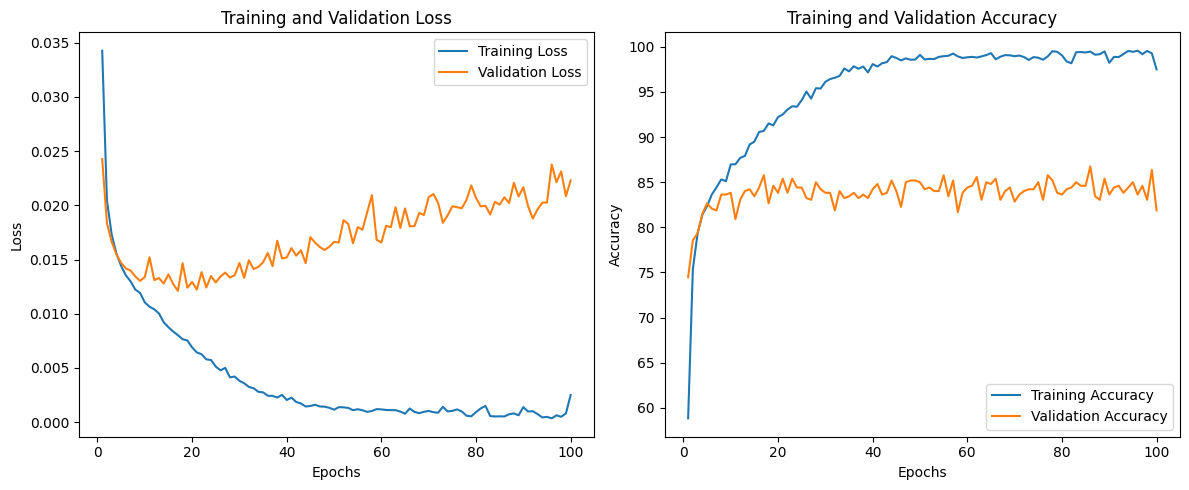

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.5  # Dropout rate

# Initialize the model
model_4 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_4.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_4(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_4.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_4(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_4 = model_4.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_4, 'best_model_4.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 82.29it/s, valid_loss=9.52]


Epoch 1/100, Training Loss: 0.0308, Validation Loss: 0.0186, Training Accuracy: 59.10%, Validation Accuracy: 78.75%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 86.63it/s, valid_loss=8.63]


Epoch 2/100, Training Loss: 0.0205, Validation Loss: 0.0168, Training Accuracy: 73.58%, Validation Accuracy: 81.09%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 78.39it/s, valid_loss=8.91]


Epoch 3/100, Training Loss: 0.0188, Validation Loss: 0.0174, Training Accuracy: 76.84%, Validation Accuracy: 77.78%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 74.22it/s, valid_loss=7.2]


Epoch 4/100, Training Loss: 0.0175, Validation Loss: 0.0140, Training Accuracy: 78.30%, Validation Accuracy: 84.60%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 66.93it/s, valid_loss=7.75]


Epoch 5/100, Training Loss: 0.0173, Validation Loss: 0.0151, Training Accuracy: 78.98%, Validation Accuracy: 82.46%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 92.83it/s, valid_loss=7.98]


Epoch 6/100, Training Loss: 0.0173, Validation Loss: 0.0156, Training Accuracy: 78.44%, Validation Accuracy: 79.92%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 71.73it/s, valid_loss=8.25]


Epoch 7/100, Training Loss: 0.0161, Validation Loss: 0.0161, Training Accuracy: 80.29%, Validation Accuracy: 80.90%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 90.61it/s, valid_loss=7.24]


Epoch 8/100, Training Loss: 0.0161, Validation Loss: 0.0141, Training Accuracy: 80.54%, Validation Accuracy: 81.87%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 72.76it/s, valid_loss=7.2]


Epoch 9/100, Training Loss: 0.0155, Validation Loss: 0.0140, Training Accuracy: 81.27%, Validation Accuracy: 83.63%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 61.35it/s, valid_loss=9.54]


Epoch 10/100, Training Loss: 0.0143, Validation Loss: 0.0186, Training Accuracy: 82.90%, Validation Accuracy: 79.34%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 91.91it/s, valid_loss=6.77]


Epoch 11/100, Training Loss: 0.0146, Validation Loss: 0.0132, Training Accuracy: 81.82%, Validation Accuracy: 83.04%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 80.09it/s, valid_loss=6.99]


Epoch 12/100, Training Loss: 0.0139, Validation Loss: 0.0136, Training Accuracy: 83.28%, Validation Accuracy: 84.02%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 92.89it/s, valid_loss=7.31]


Epoch 13/100, Training Loss: 0.0142, Validation Loss: 0.0143, Training Accuracy: 82.60%, Validation Accuracy: 83.82%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 92.61it/s, valid_loss=6.6]


Epoch 14/100, Training Loss: 0.0132, Validation Loss: 0.0129, Training Accuracy: 84.26%, Validation Accuracy: 82.46%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 64.59it/s, valid_loss=6.85]


Epoch 15/100, Training Loss: 0.0128, Validation Loss: 0.0134, Training Accuracy: 84.82%, Validation Accuracy: 83.43%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 85.67it/s, valid_loss=7.08]


Epoch 16/100, Training Loss: 0.0134, Validation Loss: 0.0138, Training Accuracy: 83.82%, Validation Accuracy: 82.85%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 67.21it/s, valid_loss=7.39]


Epoch 17/100, Training Loss: 0.0128, Validation Loss: 0.0144, Training Accuracy: 84.67%, Validation Accuracy: 82.65%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 88.39it/s, valid_loss=6.4]


Epoch 18/100, Training Loss: 0.0132, Validation Loss: 0.0125, Training Accuracy: 83.33%, Validation Accuracy: 85.19%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 89.17it/s, valid_loss=6.84]


Epoch 19/100, Training Loss: 0.0129, Validation Loss: 0.0133, Training Accuracy: 84.21%, Validation Accuracy: 84.21%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 80.14it/s, valid_loss=6.78]


Epoch 20/100, Training Loss: 0.0132, Validation Loss: 0.0132, Training Accuracy: 84.01%, Validation Accuracy: 82.26%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 82.87it/s, valid_loss=6.96]


Epoch 21/100, Training Loss: 0.0134, Validation Loss: 0.0136, Training Accuracy: 83.80%, Validation Accuracy: 83.04%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 68.93it/s, valid_loss=6.49]


Epoch 22/100, Training Loss: 0.0123, Validation Loss: 0.0126, Training Accuracy: 85.04%, Validation Accuracy: 85.38%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 66.13it/s, valid_loss=6.48]


Epoch 23/100, Training Loss: 0.0134, Validation Loss: 0.0126, Training Accuracy: 83.45%, Validation Accuracy: 84.99%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 85.36it/s, valid_loss=7.34]


Epoch 24/100, Training Loss: 0.0118, Validation Loss: 0.0143, Training Accuracy: 85.94%, Validation Accuracy: 82.65%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 68.12it/s, valid_loss=7.08]


Epoch 25/100, Training Loss: 0.0117, Validation Loss: 0.0138, Training Accuracy: 85.62%, Validation Accuracy: 84.02%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 79.56it/s, valid_loss=6.38]


Epoch 26/100, Training Loss: 0.0129, Validation Loss: 0.0124, Training Accuracy: 83.92%, Validation Accuracy: 83.43%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 70.79it/s, valid_loss=6.48]


Epoch 27/100, Training Loss: 0.0122, Validation Loss: 0.0126, Training Accuracy: 85.89%, Validation Accuracy: 84.99%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 61.51it/s, valid_loss=6.62]


Epoch 28/100, Training Loss: 0.0121, Validation Loss: 0.0129, Training Accuracy: 84.89%, Validation Accuracy: 84.80%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 84.55it/s, valid_loss=6.81]


Epoch 29/100, Training Loss: 0.0113, Validation Loss: 0.0133, Training Accuracy: 85.91%, Validation Accuracy: 83.82%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 70.14it/s, valid_loss=6.65]


Epoch 30/100, Training Loss: 0.0113, Validation Loss: 0.0130, Training Accuracy: 85.72%, Validation Accuracy: 84.41%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 77.75it/s, valid_loss=6.51]


Epoch 31/100, Training Loss: 0.0107, Validation Loss: 0.0127, Training Accuracy: 86.23%, Validation Accuracy: 83.63%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 69.32it/s, valid_loss=7.25]


Epoch 32/100, Training Loss: 0.0100, Validation Loss: 0.0141, Training Accuracy: 87.76%, Validation Accuracy: 84.21%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 75.22it/s, valid_loss=6.49]


Epoch 33/100, Training Loss: 0.0111, Validation Loss: 0.0126, Training Accuracy: 85.99%, Validation Accuracy: 85.77%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 83.94it/s, valid_loss=6.28]


Epoch 34/100, Training Loss: 0.0107, Validation Loss: 0.0122, Training Accuracy: 87.20%, Validation Accuracy: 84.99%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 68.59it/s, valid_loss=6.99]


Epoch 35/100, Training Loss: 0.0105, Validation Loss: 0.0136, Training Accuracy: 86.98%, Validation Accuracy: 84.99%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 83.44it/s, valid_loss=6.9]


Epoch 36/100, Training Loss: 0.0108, Validation Loss: 0.0135, Training Accuracy: 86.37%, Validation Accuracy: 85.38%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 70.45it/s, valid_loss=6.99]


Epoch 37/100, Training Loss: 0.0110, Validation Loss: 0.0136, Training Accuracy: 86.52%, Validation Accuracy: 80.90%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 82.73it/s, valid_loss=6.79]


Epoch 38/100, Training Loss: 0.0105, Validation Loss: 0.0132, Training Accuracy: 86.89%, Validation Accuracy: 82.85%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 85.06it/s, valid_loss=6.5]


Epoch 39/100, Training Loss: 0.0113, Validation Loss: 0.0127, Training Accuracy: 86.16%, Validation Accuracy: 84.60%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 65.33it/s, valid_loss=6.54]


Epoch 40/100, Training Loss: 0.0105, Validation Loss: 0.0128, Training Accuracy: 86.81%, Validation Accuracy: 84.60%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 78.00it/s, valid_loss=6.74]


Epoch 41/100, Training Loss: 0.0102, Validation Loss: 0.0131, Training Accuracy: 87.54%, Validation Accuracy: 84.80%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 72.97it/s, valid_loss=7.04]


Epoch 42/100, Training Loss: 0.0103, Validation Loss: 0.0137, Training Accuracy: 86.98%, Validation Accuracy: 84.21%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 82.00it/s, valid_loss=7.13]


Epoch 43/100, Training Loss: 0.0100, Validation Loss: 0.0139, Training Accuracy: 88.18%, Validation Accuracy: 85.19%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 74.51it/s, valid_loss=6.77]


Epoch 44/100, Training Loss: 0.0089, Validation Loss: 0.0132, Training Accuracy: 89.32%, Validation Accuracy: 83.82%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 68.57it/s, valid_loss=7.24]


Epoch 45/100, Training Loss: 0.0091, Validation Loss: 0.0141, Training Accuracy: 88.76%, Validation Accuracy: 83.63%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 83.46it/s, valid_loss=7.51]


Epoch 46/100, Training Loss: 0.0096, Validation Loss: 0.0146, Training Accuracy: 88.05%, Validation Accuracy: 84.41%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 81.26it/s, valid_loss=7.03]


Epoch 47/100, Training Loss: 0.0095, Validation Loss: 0.0137, Training Accuracy: 88.22%, Validation Accuracy: 84.80%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 82.82it/s, valid_loss=7.46]


Epoch 48/100, Training Loss: 0.0091, Validation Loss: 0.0145, Training Accuracy: 89.27%, Validation Accuracy: 81.68%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 83.27it/s, valid_loss=6.98]


Epoch 49/100, Training Loss: 0.0096, Validation Loss: 0.0136, Training Accuracy: 88.44%, Validation Accuracy: 84.02%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 66.35it/s, valid_loss=6.58]


Epoch 50/100, Training Loss: 0.0098, Validation Loss: 0.0128, Training Accuracy: 88.13%, Validation Accuracy: 83.82%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 74.10it/s, valid_loss=6.78]


Epoch 51/100, Training Loss: 0.0099, Validation Loss: 0.0132, Training Accuracy: 87.71%, Validation Accuracy: 84.80%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 69.83it/s, valid_loss=7.72]


Epoch 52/100, Training Loss: 0.0099, Validation Loss: 0.0150, Training Accuracy: 87.62%, Validation Accuracy: 83.63%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 73.52it/s, valid_loss=7.09]


Epoch 53/100, Training Loss: 0.0096, Validation Loss: 0.0138, Training Accuracy: 88.22%, Validation Accuracy: 84.41%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 82.23it/s, valid_loss=7.09]


Epoch 54/100, Training Loss: 0.0092, Validation Loss: 0.0138, Training Accuracy: 89.00%, Validation Accuracy: 82.85%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 62.50it/s, valid_loss=7.2]


Epoch 55/100, Training Loss: 0.0091, Validation Loss: 0.0140, Training Accuracy: 89.12%, Validation Accuracy: 82.65%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 79.29it/s, valid_loss=6.79]


Epoch 56/100, Training Loss: 0.0090, Validation Loss: 0.0132, Training Accuracy: 89.20%, Validation Accuracy: 83.24%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 75.09it/s, valid_loss=7.73]


Epoch 57/100, Training Loss: 0.0079, Validation Loss: 0.0151, Training Accuracy: 90.85%, Validation Accuracy: 83.24%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 83.17it/s, valid_loss=7.71]


Epoch 58/100, Training Loss: 0.0083, Validation Loss: 0.0150, Training Accuracy: 90.12%, Validation Accuracy: 84.80%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 70.39it/s, valid_loss=7.32]


Epoch 59/100, Training Loss: 0.0096, Validation Loss: 0.0143, Training Accuracy: 88.39%, Validation Accuracy: 84.21%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 69.39it/s, valid_loss=7.46]


Epoch 60/100, Training Loss: 0.0087, Validation Loss: 0.0145, Training Accuracy: 89.49%, Validation Accuracy: 83.43%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 84.43it/s, valid_loss=7.49]


Epoch 61/100, Training Loss: 0.0093, Validation Loss: 0.0146, Training Accuracy: 89.00%, Validation Accuracy: 84.41%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 77.16it/s, valid_loss=8.45]


Epoch 62/100, Training Loss: 0.0083, Validation Loss: 0.0165, Training Accuracy: 89.90%, Validation Accuracy: 81.87%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 85.45it/s, valid_loss=6.95]


Epoch 63/100, Training Loss: 0.0089, Validation Loss: 0.0135, Training Accuracy: 89.39%, Validation Accuracy: 81.68%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 73.63it/s, valid_loss=7.32]


Epoch 64/100, Training Loss: 0.0081, Validation Loss: 0.0143, Training Accuracy: 90.68%, Validation Accuracy: 83.24%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 64.43it/s, valid_loss=7.97]


Epoch 65/100, Training Loss: 0.0083, Validation Loss: 0.0155, Training Accuracy: 90.07%, Validation Accuracy: 84.60%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 78.13it/s, valid_loss=7.76]


Epoch 66/100, Training Loss: 0.0084, Validation Loss: 0.0151, Training Accuracy: 89.42%, Validation Accuracy: 83.82%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 69.00it/s, valid_loss=7.87]


Epoch 67/100, Training Loss: 0.0094, Validation Loss: 0.0153, Training Accuracy: 88.35%, Validation Accuracy: 82.85%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 84.04it/s, valid_loss=7.51]


Epoch 68/100, Training Loss: 0.0097, Validation Loss: 0.0146, Training Accuracy: 87.57%, Validation Accuracy: 82.26%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 76.29it/s, valid_loss=8.16]


Epoch 69/100, Training Loss: 0.0090, Validation Loss: 0.0159, Training Accuracy: 89.10%, Validation Accuracy: 84.60%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 67.16it/s, valid_loss=7.19]


Epoch 70/100, Training Loss: 0.0095, Validation Loss: 0.0140, Training Accuracy: 88.03%, Validation Accuracy: 83.82%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 85.32it/s, valid_loss=7.8]


Epoch 71/100, Training Loss: 0.0088, Validation Loss: 0.0152, Training Accuracy: 88.54%, Validation Accuracy: 85.58%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 70.45it/s, valid_loss=7.46]


Epoch 72/100, Training Loss: 0.0086, Validation Loss: 0.0145, Training Accuracy: 89.27%, Validation Accuracy: 84.60%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 76.20it/s, valid_loss=7.36]


Epoch 73/100, Training Loss: 0.0078, Validation Loss: 0.0143, Training Accuracy: 90.36%, Validation Accuracy: 82.85%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 44.26it/s, valid_loss=7.59]


Epoch 74/100, Training Loss: 0.0079, Validation Loss: 0.0148, Training Accuracy: 90.41%, Validation Accuracy: 83.82%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 53.55it/s, valid_loss=7.04]


Epoch 75/100, Training Loss: 0.0086, Validation Loss: 0.0137, Training Accuracy: 89.29%, Validation Accuracy: 84.41%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 79.10it/s, valid_loss=8.26]


Epoch 76/100, Training Loss: 0.0073, Validation Loss: 0.0161, Training Accuracy: 90.71%, Validation Accuracy: 82.26%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 82.03it/s, valid_loss=8.07]


Epoch 77/100, Training Loss: 0.0077, Validation Loss: 0.0157, Training Accuracy: 90.54%, Validation Accuracy: 84.41%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 77.24it/s, valid_loss=7.62]


Epoch 78/100, Training Loss: 0.0076, Validation Loss: 0.0149, Training Accuracy: 90.88%, Validation Accuracy: 84.02%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 74.91it/s, valid_loss=7.44]


Epoch 79/100, Training Loss: 0.0078, Validation Loss: 0.0145, Training Accuracy: 91.05%, Validation Accuracy: 84.99%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 65.75it/s, valid_loss=7.28]


Epoch 80/100, Training Loss: 0.0089, Validation Loss: 0.0142, Training Accuracy: 89.17%, Validation Accuracy: 84.02%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 74.65it/s, valid_loss=6.79]


Epoch 81/100, Training Loss: 0.0095, Validation Loss: 0.0132, Training Accuracy: 88.18%, Validation Accuracy: 83.24%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 62.14it/s, valid_loss=7.24]


Epoch 82/100, Training Loss: 0.0078, Validation Loss: 0.0141, Training Accuracy: 90.51%, Validation Accuracy: 84.41%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 83.09it/s, valid_loss=8.32]


Epoch 83/100, Training Loss: 0.0073, Validation Loss: 0.0162, Training Accuracy: 91.39%, Validation Accuracy: 84.60%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 81.21it/s, valid_loss=7.74]


Epoch 84/100, Training Loss: 0.0082, Validation Loss: 0.0151, Training Accuracy: 90.75%, Validation Accuracy: 83.24%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 66.75it/s, valid_loss=9.09]


Epoch 85/100, Training Loss: 0.0073, Validation Loss: 0.0177, Training Accuracy: 91.07%, Validation Accuracy: 82.65%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 78.37it/s, valid_loss=7.48]


Epoch 86/100, Training Loss: 0.0071, Validation Loss: 0.0146, Training Accuracy: 91.24%, Validation Accuracy: 84.41%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 68.21it/s, valid_loss=7.82]


Epoch 87/100, Training Loss: 0.0073, Validation Loss: 0.0152, Training Accuracy: 91.58%, Validation Accuracy: 84.21%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 87.73it/s, valid_loss=8.25]


Epoch 88/100, Training Loss: 0.0075, Validation Loss: 0.0161, Training Accuracy: 90.85%, Validation Accuracy: 83.63%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 76.83it/s, valid_loss=7.37]


Epoch 89/100, Training Loss: 0.0078, Validation Loss: 0.0144, Training Accuracy: 90.05%, Validation Accuracy: 84.21%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 45.17it/s, valid_loss=8.71]


Epoch 90/100, Training Loss: 0.0068, Validation Loss: 0.0170, Training Accuracy: 91.44%, Validation Accuracy: 84.21%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 74.02it/s, valid_loss=8.62]


Epoch 91/100, Training Loss: 0.0071, Validation Loss: 0.0168, Training Accuracy: 91.92%, Validation Accuracy: 84.99%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 66.28it/s, valid_loss=7.4]


Epoch 92/100, Training Loss: 0.0077, Validation Loss: 0.0144, Training Accuracy: 91.19%, Validation Accuracy: 85.19%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 80.19it/s, valid_loss=8.04]


Epoch 93/100, Training Loss: 0.0073, Validation Loss: 0.0157, Training Accuracy: 90.88%, Validation Accuracy: 84.21%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 79.78it/s, valid_loss=9.12]


Epoch 94/100, Training Loss: 0.0074, Validation Loss: 0.0178, Training Accuracy: 90.95%, Validation Accuracy: 82.07%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 85.69it/s, valid_loss=8.25]


Epoch 95/100, Training Loss: 0.0061, Validation Loss: 0.0161, Training Accuracy: 92.21%, Validation Accuracy: 82.46%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 74.06it/s, valid_loss=7.81]


Epoch 96/100, Training Loss: 0.0070, Validation Loss: 0.0152, Training Accuracy: 91.68%, Validation Accuracy: 84.99%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 74.88it/s, valid_loss=8.57]


Epoch 97/100, Training Loss: 0.0069, Validation Loss: 0.0167, Training Accuracy: 91.78%, Validation Accuracy: 84.80%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 85.55it/s, valid_loss=7.99]


Epoch 98/100, Training Loss: 0.0072, Validation Loss: 0.0156, Training Accuracy: 91.29%, Validation Accuracy: 84.21%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 63.67it/s, valid_loss=8.69]


Epoch 99/100, Training Loss: 0.0067, Validation Loss: 0.0169, Training Accuracy: 92.14%, Validation Accuracy: 84.41%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 83.18it/s, valid_loss=8.5]


Epoch 100/100, Training Loss: 0.0080, Validation Loss: 0.0166, Training Accuracy: 90.29%, Validation Accuracy: 84.99%


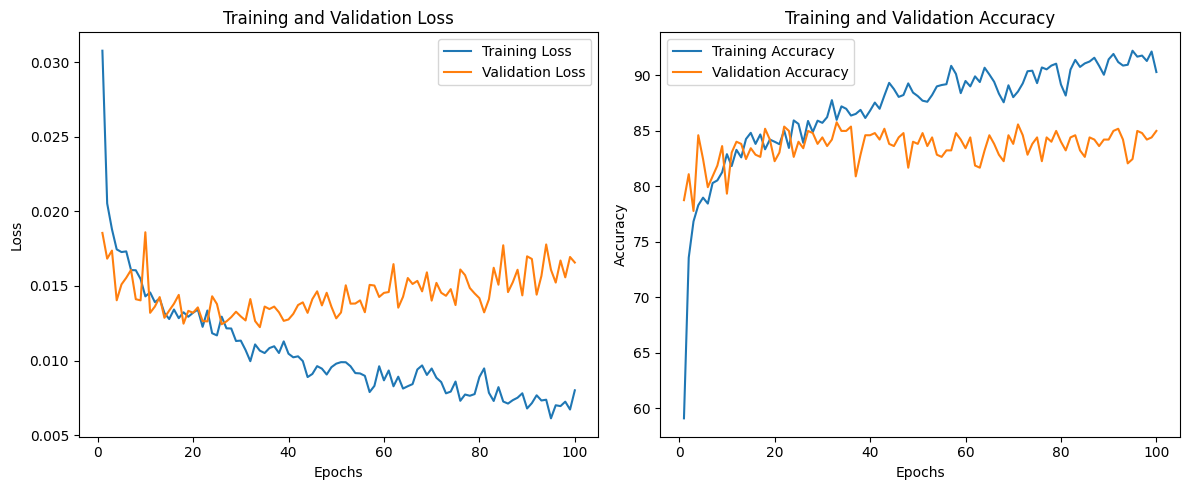

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [256, 128, 64]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.5  # Dropout rate

# Initialize the model
model = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state, 'best_model_rishis5.pth')

Validating Epoch 1/100: 100%|██████████| 17/17 [00:00<00:00, 101.55it/s, valid_loss=24.9]


Epoch 1/100, Training Loss: 0.0493, Validation Loss: 0.0485, Training Accuracy: 26.42%, Validation Accuracy: 53.61%


Validating Epoch 2/100: 100%|██████████| 17/17 [00:00<00:00, 97.68it/s, valid_loss=19.2]


Epoch 2/100, Training Loss: 0.0431, Validation Loss: 0.0374, Training Accuracy: 44.21%, Validation Accuracy: 61.01%


Validating Epoch 3/100: 100%|██████████| 17/17 [00:00<00:00, 114.74it/s, valid_loss=15.3]


Epoch 3/100, Training Loss: 0.0345, Validation Loss: 0.0297, Training Accuracy: 54.74%, Validation Accuracy: 67.25%


Validating Epoch 4/100: 100%|██████████| 17/17 [00:00<00:00, 84.59it/s, valid_loss=12.9]


Epoch 4/100, Training Loss: 0.0300, Validation Loss: 0.0252, Training Accuracy: 61.14%, Validation Accuracy: 73.68%


Validating Epoch 5/100: 100%|██████████| 17/17 [00:00<00:00, 94.21it/s, valid_loss=11.7]


Epoch 5/100, Training Loss: 0.0268, Validation Loss: 0.0229, Training Accuracy: 65.82%, Validation Accuracy: 74.85%


Validating Epoch 6/100: 100%|██████████| 17/17 [00:00<00:00, 112.43it/s, valid_loss=10.7]


Epoch 6/100, Training Loss: 0.0250, Validation Loss: 0.0208, Training Accuracy: 68.61%, Validation Accuracy: 77.58%


Validating Epoch 7/100: 100%|██████████| 17/17 [00:00<00:00, 98.15it/s, valid_loss=10.1]


Epoch 7/100, Training Loss: 0.0237, Validation Loss: 0.0196, Training Accuracy: 70.68%, Validation Accuracy: 79.73%


Validating Epoch 8/100: 100%|██████████| 17/17 [00:00<00:00, 108.90it/s, valid_loss=9.04]


Epoch 8/100, Training Loss: 0.0221, Validation Loss: 0.0176, Training Accuracy: 72.53%, Validation Accuracy: 80.51%


Validating Epoch 9/100: 100%|██████████| 17/17 [00:00<00:00, 101.90it/s, valid_loss=8.74]


Epoch 9/100, Training Loss: 0.0215, Validation Loss: 0.0170, Training Accuracy: 74.60%, Validation Accuracy: 81.29%


Validating Epoch 10/100: 100%|██████████| 17/17 [00:00<00:00, 104.26it/s, valid_loss=8.4]


Epoch 10/100, Training Loss: 0.0204, Validation Loss: 0.0164, Training Accuracy: 75.86%, Validation Accuracy: 80.51%


Validating Epoch 11/100: 100%|██████████| 17/17 [00:00<00:00, 79.72it/s, valid_loss=8.38]


Epoch 11/100, Training Loss: 0.0193, Validation Loss: 0.0163, Training Accuracy: 78.15%, Validation Accuracy: 81.87%


Validating Epoch 12/100: 100%|██████████| 17/17 [00:00<00:00, 102.73it/s, valid_loss=7.88]


Epoch 12/100, Training Loss: 0.0186, Validation Loss: 0.0154, Training Accuracy: 78.78%, Validation Accuracy: 81.29%


Validating Epoch 13/100: 100%|██████████| 17/17 [00:00<00:00, 112.48it/s, valid_loss=7.83]


Epoch 13/100, Training Loss: 0.0177, Validation Loss: 0.0153, Training Accuracy: 79.85%, Validation Accuracy: 81.87%


Validating Epoch 14/100: 100%|██████████| 17/17 [00:00<00:00, 101.97it/s, valid_loss=7.71]


Epoch 14/100, Training Loss: 0.0174, Validation Loss: 0.0150, Training Accuracy: 80.17%, Validation Accuracy: 81.48%


Validating Epoch 15/100: 100%|██████████| 17/17 [00:00<00:00, 91.61it/s, valid_loss=7.69]


Epoch 15/100, Training Loss: 0.0176, Validation Loss: 0.0150, Training Accuracy: 79.83%, Validation Accuracy: 80.51%


Validating Epoch 16/100: 100%|██████████| 17/17 [00:00<00:00, 96.56it/s, valid_loss=7.31]


Epoch 16/100, Training Loss: 0.0168, Validation Loss: 0.0142, Training Accuracy: 80.66%, Validation Accuracy: 82.85%


Validating Epoch 17/100: 100%|██████████| 17/17 [00:00<00:00, 84.35it/s, valid_loss=7.17]


Epoch 17/100, Training Loss: 0.0160, Validation Loss: 0.0140, Training Accuracy: 81.46%, Validation Accuracy: 83.04%


Validating Epoch 18/100: 100%|██████████| 17/17 [00:00<00:00, 103.99it/s, valid_loss=7.3]


Epoch 18/100, Training Loss: 0.0161, Validation Loss: 0.0142, Training Accuracy: 81.82%, Validation Accuracy: 81.09%


Validating Epoch 19/100: 100%|██████████| 17/17 [00:00<00:00, 111.06it/s, valid_loss=7.07]


Epoch 19/100, Training Loss: 0.0153, Validation Loss: 0.0138, Training Accuracy: 82.73%, Validation Accuracy: 83.24%


Validating Epoch 20/100: 100%|██████████| 17/17 [00:00<00:00, 86.43it/s, valid_loss=7.1]


Epoch 20/100, Training Loss: 0.0149, Validation Loss: 0.0138, Training Accuracy: 83.21%, Validation Accuracy: 83.24%


Validating Epoch 21/100: 100%|██████████| 17/17 [00:00<00:00, 87.17it/s, valid_loss=6.93]


Epoch 21/100, Training Loss: 0.0144, Validation Loss: 0.0135, Training Accuracy: 83.63%, Validation Accuracy: 82.65%


Validating Epoch 22/100: 100%|██████████| 17/17 [00:00<00:00, 88.15it/s, valid_loss=7.01]


Epoch 22/100, Training Loss: 0.0142, Validation Loss: 0.0137, Training Accuracy: 83.55%, Validation Accuracy: 83.04%


Validating Epoch 23/100: 100%|██████████| 17/17 [00:00<00:00, 72.71it/s, valid_loss=7.23]


Epoch 23/100, Training Loss: 0.0138, Validation Loss: 0.0141, Training Accuracy: 84.33%, Validation Accuracy: 83.24%


Validating Epoch 24/100: 100%|██████████| 17/17 [00:00<00:00, 100.29it/s, valid_loss=6.8]


Epoch 24/100, Training Loss: 0.0135, Validation Loss: 0.0133, Training Accuracy: 84.48%, Validation Accuracy: 84.60%


Validating Epoch 25/100: 100%|██████████| 17/17 [00:00<00:00, 110.01it/s, valid_loss=6.75]


Epoch 25/100, Training Loss: 0.0135, Validation Loss: 0.0132, Training Accuracy: 84.79%, Validation Accuracy: 84.80%


Validating Epoch 26/100: 100%|██████████| 17/17 [00:00<00:00, 96.50it/s, valid_loss=6.82] 


Epoch 26/100, Training Loss: 0.0132, Validation Loss: 0.0133, Training Accuracy: 85.09%, Validation Accuracy: 84.60%


Validating Epoch 27/100: 100%|██████████| 17/17 [00:00<00:00, 91.13it/s, valid_loss=6.85]


Epoch 27/100, Training Loss: 0.0127, Validation Loss: 0.0134, Training Accuracy: 86.01%, Validation Accuracy: 83.63%


Validating Epoch 28/100: 100%|██████████| 17/17 [00:00<00:00, 87.93it/s, valid_loss=6.7]


Epoch 28/100, Training Loss: 0.0126, Validation Loss: 0.0131, Training Accuracy: 86.20%, Validation Accuracy: 84.60%


Validating Epoch 29/100: 100%|██████████| 17/17 [00:00<00:00, 92.16it/s, valid_loss=6.64]


Epoch 29/100, Training Loss: 0.0124, Validation Loss: 0.0129, Training Accuracy: 86.03%, Validation Accuracy: 85.38%


Validating Epoch 30/100: 100%|██████████| 17/17 [00:00<00:00, 101.85it/s, valid_loss=6.92]


Epoch 30/100, Training Loss: 0.0117, Validation Loss: 0.0135, Training Accuracy: 86.81%, Validation Accuracy: 83.63%


Validating Epoch 31/100: 100%|██████████| 17/17 [00:00<00:00, 104.57it/s, valid_loss=6.7]


Epoch 31/100, Training Loss: 0.0116, Validation Loss: 0.0131, Training Accuracy: 86.86%, Validation Accuracy: 84.99%


Validating Epoch 32/100: 100%|██████████| 17/17 [00:00<00:00, 108.19it/s, valid_loss=6.82]


Epoch 32/100, Training Loss: 0.0113, Validation Loss: 0.0133, Training Accuracy: 87.18%, Validation Accuracy: 84.41%


Validating Epoch 33/100: 100%|██████████| 17/17 [00:00<00:00, 91.55it/s, valid_loss=6.52]


Epoch 33/100, Training Loss: 0.0117, Validation Loss: 0.0127, Training Accuracy: 87.45%, Validation Accuracy: 85.38%


Validating Epoch 34/100: 100%|██████████| 17/17 [00:00<00:00, 103.39it/s, valid_loss=6.66]


Epoch 34/100, Training Loss: 0.0110, Validation Loss: 0.0130, Training Accuracy: 88.44%, Validation Accuracy: 84.60%


Validating Epoch 35/100: 100%|██████████| 17/17 [00:00<00:00, 82.44it/s, valid_loss=6.67]


Epoch 35/100, Training Loss: 0.0108, Validation Loss: 0.0130, Training Accuracy: 88.27%, Validation Accuracy: 84.99%


Validating Epoch 36/100: 100%|██████████| 17/17 [00:00<00:00, 99.85it/s, valid_loss=6.75]


Epoch 36/100, Training Loss: 0.0104, Validation Loss: 0.0132, Training Accuracy: 88.52%, Validation Accuracy: 83.04%


Validating Epoch 37/100: 100%|██████████| 17/17 [00:00<00:00, 100.33it/s, valid_loss=6.67]


Epoch 37/100, Training Loss: 0.0107, Validation Loss: 0.0130, Training Accuracy: 88.20%, Validation Accuracy: 83.82%


Validating Epoch 38/100: 100%|██████████| 17/17 [00:00<00:00, 93.82it/s, valid_loss=6.53]


Epoch 38/100, Training Loss: 0.0098, Validation Loss: 0.0127, Training Accuracy: 89.29%, Validation Accuracy: 84.60%


Validating Epoch 39/100: 100%|██████████| 17/17 [00:00<00:00, 84.67it/s, valid_loss=6.48]


Epoch 39/100, Training Loss: 0.0100, Validation Loss: 0.0126, Training Accuracy: 89.03%, Validation Accuracy: 84.02%


Validating Epoch 40/100: 100%|██████████| 17/17 [00:00<00:00, 93.44it/s, valid_loss=6.47]


Epoch 40/100, Training Loss: 0.0097, Validation Loss: 0.0126, Training Accuracy: 89.42%, Validation Accuracy: 85.19%


Validating Epoch 41/100: 100%|██████████| 17/17 [00:00<00:00, 95.36it/s, valid_loss=6.94] 


Epoch 41/100, Training Loss: 0.0089, Validation Loss: 0.0135, Training Accuracy: 90.07%, Validation Accuracy: 83.24%


Validating Epoch 42/100: 100%|██████████| 17/17 [00:00<00:00, 108.19it/s, valid_loss=7.13]


Epoch 42/100, Training Loss: 0.0091, Validation Loss: 0.0139, Training Accuracy: 89.90%, Validation Accuracy: 84.02%


Validating Epoch 43/100: 100%|██████████| 17/17 [00:00<00:00, 103.62it/s, valid_loss=6.78]


Epoch 43/100, Training Loss: 0.0088, Validation Loss: 0.0132, Training Accuracy: 90.00%, Validation Accuracy: 84.60%


Validating Epoch 44/100: 100%|██████████| 17/17 [00:00<00:00, 75.52it/s, valid_loss=6.77]


Epoch 44/100, Training Loss: 0.0087, Validation Loss: 0.0132, Training Accuracy: 91.02%, Validation Accuracy: 84.60%


Validating Epoch 45/100: 100%|██████████| 17/17 [00:00<00:00, 109.98it/s, valid_loss=6.67]


Epoch 45/100, Training Loss: 0.0085, Validation Loss: 0.0130, Training Accuracy: 90.66%, Validation Accuracy: 85.19%


Validating Epoch 46/100: 100%|██████████| 17/17 [00:00<00:00, 115.00it/s, valid_loss=6.67]


Epoch 46/100, Training Loss: 0.0084, Validation Loss: 0.0130, Training Accuracy: 90.78%, Validation Accuracy: 85.96%


Validating Epoch 47/100: 100%|██████████| 17/17 [00:00<00:00, 95.14it/s, valid_loss=6.92]


Epoch 47/100, Training Loss: 0.0079, Validation Loss: 0.0135, Training Accuracy: 91.44%, Validation Accuracy: 83.63%


Validating Epoch 48/100: 100%|██████████| 17/17 [00:00<00:00, 101.79it/s, valid_loss=6.72]


Epoch 48/100, Training Loss: 0.0079, Validation Loss: 0.0131, Training Accuracy: 91.70%, Validation Accuracy: 84.21%


Validating Epoch 49/100: 100%|██████████| 17/17 [00:00<00:00, 113.57it/s, valid_loss=6.77]


Epoch 49/100, Training Loss: 0.0075, Validation Loss: 0.0132, Training Accuracy: 92.53%, Validation Accuracy: 84.41%


Validating Epoch 50/100: 100%|██████████| 17/17 [00:00<00:00, 109.86it/s, valid_loss=6.74]


Epoch 50/100, Training Loss: 0.0079, Validation Loss: 0.0131, Training Accuracy: 92.02%, Validation Accuracy: 84.41%


Validating Epoch 51/100: 100%|██████████| 17/17 [00:00<00:00, 100.42it/s, valid_loss=6.73]


Epoch 51/100, Training Loss: 0.0074, Validation Loss: 0.0131, Training Accuracy: 92.14%, Validation Accuracy: 85.96%


Validating Epoch 52/100: 100%|██████████| 17/17 [00:00<00:00, 98.83it/s, valid_loss=7.18]


Epoch 52/100, Training Loss: 0.0073, Validation Loss: 0.0140, Training Accuracy: 92.43%, Validation Accuracy: 84.21%


Validating Epoch 53/100: 100%|██████████| 17/17 [00:00<00:00, 96.81it/s, valid_loss=6.93]


Epoch 53/100, Training Loss: 0.0072, Validation Loss: 0.0135, Training Accuracy: 92.14%, Validation Accuracy: 84.99%


Validating Epoch 54/100: 100%|██████████| 17/17 [00:00<00:00, 95.26it/s, valid_loss=6.76]


Epoch 54/100, Training Loss: 0.0073, Validation Loss: 0.0132, Training Accuracy: 91.85%, Validation Accuracy: 84.99%


Validating Epoch 55/100: 100%|██████████| 17/17 [00:00<00:00, 109.94it/s, valid_loss=7.8]


Epoch 55/100, Training Loss: 0.0067, Validation Loss: 0.0152, Training Accuracy: 92.87%, Validation Accuracy: 83.63%


Validating Epoch 56/100: 100%|██████████| 17/17 [00:00<00:00, 103.56it/s, valid_loss=7.71]


Epoch 56/100, Training Loss: 0.0065, Validation Loss: 0.0150, Training Accuracy: 93.53%, Validation Accuracy: 83.63%


Validating Epoch 57/100: 100%|██████████| 17/17 [00:00<00:00, 105.28it/s, valid_loss=7.23]


Epoch 57/100, Training Loss: 0.0067, Validation Loss: 0.0141, Training Accuracy: 93.28%, Validation Accuracy: 84.60%


Validating Epoch 58/100: 100%|██████████| 17/17 [00:00<00:00, 93.79it/s, valid_loss=7.12]


Epoch 58/100, Training Loss: 0.0065, Validation Loss: 0.0139, Training Accuracy: 93.38%, Validation Accuracy: 85.38%


Validating Epoch 59/100: 100%|██████████| 17/17 [00:00<00:00, 75.45it/s, valid_loss=7.2]


Epoch 59/100, Training Loss: 0.0061, Validation Loss: 0.0140, Training Accuracy: 93.41%, Validation Accuracy: 84.41%


Validating Epoch 60/100: 100%|██████████| 17/17 [00:00<00:00, 98.93it/s, valid_loss=6.74]


Epoch 60/100, Training Loss: 0.0059, Validation Loss: 0.0131, Training Accuracy: 93.58%, Validation Accuracy: 84.21%


Validating Epoch 61/100: 100%|██████████| 17/17 [00:00<00:00, 98.70it/s, valid_loss=7.1]


Epoch 61/100, Training Loss: 0.0061, Validation Loss: 0.0138, Training Accuracy: 93.84%, Validation Accuracy: 84.99%


Validating Epoch 62/100: 100%|██████████| 17/17 [00:00<00:00, 97.70it/s, valid_loss=7.26]


Epoch 62/100, Training Loss: 0.0055, Validation Loss: 0.0141, Training Accuracy: 94.28%, Validation Accuracy: 84.41%


Validating Epoch 63/100: 100%|██████████| 17/17 [00:00<00:00, 116.11it/s, valid_loss=7.63]


Epoch 63/100, Training Loss: 0.0058, Validation Loss: 0.0149, Training Accuracy: 93.82%, Validation Accuracy: 85.58%


Validating Epoch 64/100: 100%|██████████| 17/17 [00:00<00:00, 107.81it/s, valid_loss=7.1]


Epoch 64/100, Training Loss: 0.0056, Validation Loss: 0.0138, Training Accuracy: 93.82%, Validation Accuracy: 85.96%


Validating Epoch 65/100: 100%|██████████| 17/17 [00:00<00:00, 86.25it/s, valid_loss=7.45]


Epoch 65/100, Training Loss: 0.0056, Validation Loss: 0.0145, Training Accuracy: 94.21%, Validation Accuracy: 85.19%


Validating Epoch 66/100: 100%|██████████| 17/17 [00:00<00:00, 104.40it/s, valid_loss=7.35]


Epoch 66/100, Training Loss: 0.0055, Validation Loss: 0.0143, Training Accuracy: 94.26%, Validation Accuracy: 85.19%


Validating Epoch 67/100: 100%|██████████| 17/17 [00:00<00:00, 108.19it/s, valid_loss=7.76]


Epoch 67/100, Training Loss: 0.0058, Validation Loss: 0.0151, Training Accuracy: 94.28%, Validation Accuracy: 83.82%


Validating Epoch 68/100: 100%|██████████| 17/17 [00:00<00:00, 96.45it/s, valid_loss=7.79]


Epoch 68/100, Training Loss: 0.0052, Validation Loss: 0.0152, Training Accuracy: 94.57%, Validation Accuracy: 84.60%


Validating Epoch 69/100: 100%|██████████| 17/17 [00:00<00:00, 109.89it/s, valid_loss=8.17]


Epoch 69/100, Training Loss: 0.0054, Validation Loss: 0.0159, Training Accuracy: 94.62%, Validation Accuracy: 83.24%


Validating Epoch 70/100: 100%|██████████| 17/17 [00:00<00:00, 97.81it/s, valid_loss=7.76]


Epoch 70/100, Training Loss: 0.0049, Validation Loss: 0.0151, Training Accuracy: 94.82%, Validation Accuracy: 84.99%


Validating Epoch 71/100: 100%|██████████| 17/17 [00:00<00:00, 83.41it/s, valid_loss=7.68]


Epoch 71/100, Training Loss: 0.0049, Validation Loss: 0.0150, Training Accuracy: 95.01%, Validation Accuracy: 84.02%


Validating Epoch 72/100: 100%|██████████| 17/17 [00:00<00:00, 105.99it/s, valid_loss=7.7]


Epoch 72/100, Training Loss: 0.0047, Validation Loss: 0.0150, Training Accuracy: 95.33%, Validation Accuracy: 84.21%


Validating Epoch 73/100: 100%|██████████| 17/17 [00:00<00:00, 109.41it/s, valid_loss=7.7]


Epoch 73/100, Training Loss: 0.0046, Validation Loss: 0.0150, Training Accuracy: 95.26%, Validation Accuracy: 84.80%


Validating Epoch 74/100: 100%|██████████| 17/17 [00:00<00:00, 99.91it/s, valid_loss=8.15]


Epoch 74/100, Training Loss: 0.0047, Validation Loss: 0.0159, Training Accuracy: 95.35%, Validation Accuracy: 83.43%


Validating Epoch 75/100: 100%|██████████| 17/17 [00:00<00:00, 110.00it/s, valid_loss=7.32]


Epoch 75/100, Training Loss: 0.0045, Validation Loss: 0.0143, Training Accuracy: 95.21%, Validation Accuracy: 84.60%


Validating Epoch 76/100: 100%|██████████| 17/17 [00:00<00:00, 104.62it/s, valid_loss=9.01]


Epoch 76/100, Training Loss: 0.0042, Validation Loss: 0.0176, Training Accuracy: 96.06%, Validation Accuracy: 83.04%


Validating Epoch 77/100: 100%|██████████| 17/17 [00:00<00:00, 90.65it/s, valid_loss=8.78]


Epoch 77/100, Training Loss: 0.0040, Validation Loss: 0.0171, Training Accuracy: 95.79%, Validation Accuracy: 84.99%


Validating Epoch 78/100: 100%|██████████| 17/17 [00:00<00:00, 100.07it/s, valid_loss=9.26]


Epoch 78/100, Training Loss: 0.0046, Validation Loss: 0.0180, Training Accuracy: 94.89%, Validation Accuracy: 83.04%


Validating Epoch 79/100: 100%|██████████| 17/17 [00:00<00:00, 110.95it/s, valid_loss=9.2]


Epoch 79/100, Training Loss: 0.0044, Validation Loss: 0.0179, Training Accuracy: 95.30%, Validation Accuracy: 83.82%


Validating Epoch 80/100: 100%|██████████| 17/17 [00:00<00:00, 105.32it/s, valid_loss=8.32]


Epoch 80/100, Training Loss: 0.0046, Validation Loss: 0.0162, Training Accuracy: 94.87%, Validation Accuracy: 83.63%


Validating Epoch 81/100: 100%|██████████| 17/17 [00:00<00:00, 95.46it/s, valid_loss=8.54]


Epoch 81/100, Training Loss: 0.0041, Validation Loss: 0.0166, Training Accuracy: 95.67%, Validation Accuracy: 84.21%


Validating Epoch 82/100: 100%|██████████| 17/17 [00:00<00:00, 107.20it/s, valid_loss=8.46]


Epoch 82/100, Training Loss: 0.0046, Validation Loss: 0.0165, Training Accuracy: 95.23%, Validation Accuracy: 83.63%


Validating Epoch 83/100: 100%|██████████| 17/17 [00:00<00:00, 108.72it/s, valid_loss=8.69]


Epoch 83/100, Training Loss: 0.0038, Validation Loss: 0.0169, Training Accuracy: 96.18%, Validation Accuracy: 83.82%


Validating Epoch 84/100: 100%|██████████| 17/17 [00:00<00:00, 83.47it/s, valid_loss=9.42]


Epoch 84/100, Training Loss: 0.0034, Validation Loss: 0.0184, Training Accuracy: 96.37%, Validation Accuracy: 84.21%


Validating Epoch 85/100: 100%|██████████| 17/17 [00:00<00:00, 99.33it/s, valid_loss=8.09]


Epoch 85/100, Training Loss: 0.0035, Validation Loss: 0.0158, Training Accuracy: 96.08%, Validation Accuracy: 84.99%


Validating Epoch 86/100: 100%|██████████| 17/17 [00:00<00:00, 106.02it/s, valid_loss=9.08]


Epoch 86/100, Training Loss: 0.0042, Validation Loss: 0.0177, Training Accuracy: 95.99%, Validation Accuracy: 83.82%


Validating Epoch 87/100: 100%|██████████| 17/17 [00:00<00:00, 102.52it/s, valid_loss=8.52]


Epoch 87/100, Training Loss: 0.0036, Validation Loss: 0.0166, Training Accuracy: 96.28%, Validation Accuracy: 85.19%


Validating Epoch 88/100: 100%|██████████| 17/17 [00:00<00:00, 108.22it/s, valid_loss=8.71]


Epoch 88/100, Training Loss: 0.0037, Validation Loss: 0.0170, Training Accuracy: 96.03%, Validation Accuracy: 85.38%


Validating Epoch 89/100: 100%|██████████| 17/17 [00:00<00:00, 99.07it/s, valid_loss=8.69]


Epoch 89/100, Training Loss: 0.0035, Validation Loss: 0.0169, Training Accuracy: 96.28%, Validation Accuracy: 84.99%


Validating Epoch 90/100: 100%|██████████| 17/17 [00:00<00:00, 95.62it/s, valid_loss=8.52]


Epoch 90/100, Training Loss: 0.0039, Validation Loss: 0.0166, Training Accuracy: 95.91%, Validation Accuracy: 83.63%


Validating Epoch 91/100: 100%|██████████| 17/17 [00:00<00:00, 88.79it/s, valid_loss=8.62]


Epoch 91/100, Training Loss: 0.0035, Validation Loss: 0.0168, Training Accuracy: 96.62%, Validation Accuracy: 84.80%


Validating Epoch 92/100: 100%|██████████| 17/17 [00:00<00:00, 109.23it/s, valid_loss=8.63]


Epoch 92/100, Training Loss: 0.0036, Validation Loss: 0.0168, Training Accuracy: 96.23%, Validation Accuracy: 84.21%


Validating Epoch 93/100: 100%|██████████| 17/17 [00:00<00:00, 90.90it/s, valid_loss=9.02]


Epoch 93/100, Training Loss: 0.0034, Validation Loss: 0.0176, Training Accuracy: 96.40%, Validation Accuracy: 84.21%


Validating Epoch 94/100: 100%|██████████| 17/17 [00:00<00:00, 105.91it/s, valid_loss=9.74]


Epoch 94/100, Training Loss: 0.0035, Validation Loss: 0.0190, Training Accuracy: 96.45%, Validation Accuracy: 83.82%


Validating Epoch 95/100: 100%|██████████| 17/17 [00:00<00:00, 97.20it/s, valid_loss=9.48]


Epoch 95/100, Training Loss: 0.0034, Validation Loss: 0.0185, Training Accuracy: 96.47%, Validation Accuracy: 83.63%


Validating Epoch 96/100: 100%|██████████| 17/17 [00:00<00:00, 91.37it/s, valid_loss=9.69]


Epoch 96/100, Training Loss: 0.0032, Validation Loss: 0.0189, Training Accuracy: 96.59%, Validation Accuracy: 84.21%


Validating Epoch 97/100: 100%|██████████| 17/17 [00:00<00:00, 97.09it/s, valid_loss=9.29]


Epoch 97/100, Training Loss: 0.0039, Validation Loss: 0.0181, Training Accuracy: 95.55%, Validation Accuracy: 84.41%


Validating Epoch 98/100: 100%|██████████| 17/17 [00:00<00:00, 110.93it/s, valid_loss=9.06]


Epoch 98/100, Training Loss: 0.0036, Validation Loss: 0.0177, Training Accuracy: 96.33%, Validation Accuracy: 84.60%


Validating Epoch 99/100: 100%|██████████| 17/17 [00:00<00:00, 113.44it/s, valid_loss=9.78]


Epoch 99/100, Training Loss: 0.0033, Validation Loss: 0.0191, Training Accuracy: 96.55%, Validation Accuracy: 82.07%


Validating Epoch 100/100: 100%|██████████| 17/17 [00:00<00:00, 97.83it/s, valid_loss=10.2]

Epoch 100/100, Training Loss: 0.0031, Validation Loss: 0.0200, Training Accuracy: 96.59%, Validation Accuracy: 83.63%


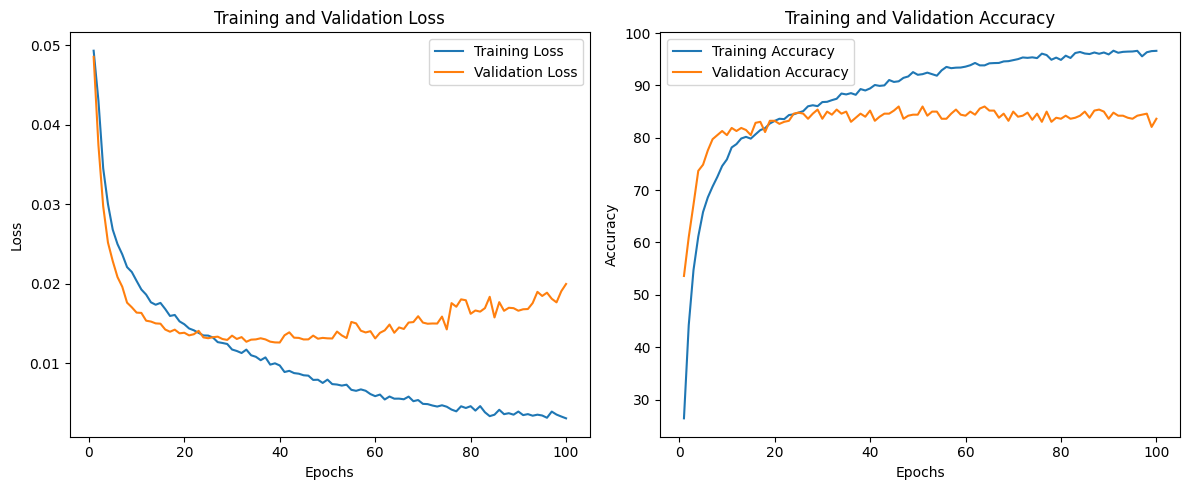

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (Resnet + hog)**

In [ ]:
model.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0221, Test Accuracy: 86.02%


In [ ]:
import seaborn as sns

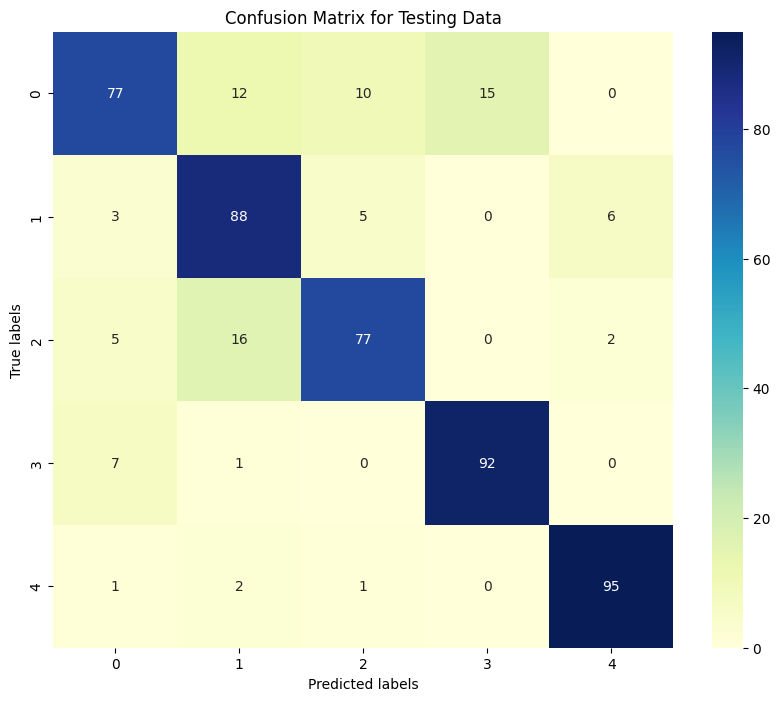

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 0.8347637964084692
Recall: 0.8330097087378641
F1 Score: 0.8307627384810377


# After experimenting, we notice that color histograms cause a much worst performance when added to the features, while histograms of oriented gradients help the performance by a slight increase of nearly 4%

#**We also tried on a diffrent dataset***
## surreal art dataset from kaggle, we extracted (Nouveau art, Rocco, Post Impressionism, Fauvism, Minimalisim) labels from the dataset and ended up with a dataset of 1300 samples.

##this dataset is much smaller, all the 4 models we tried gave about 100% accuracy on it.

#**Surreal dataset Artsy full model (Resnet + HOG + color histograms features)**

## **getting and spletting the dataset**

In [ ]:
import numpy as np
combined_features_dataset = np.load('/content/drive/MyDrive/art_styles_features_surreal.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels_surreal.npy', allow_pickle=True)

# Convert to PyTorch tensors
features_tensor = torch.tensor(combined_features_dataset, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

full_dataset = TensorDataset(features_tensor, labels_tensor)

# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (full Artsy model with surreal dataset)**



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)

    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

Validating Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00, 20.42it/s, valid_loss=16.9]


Epoch 1/30, Training Loss: 2.1756, Validation Loss: 0.1299, Training Accuracy: 45.29%, Validation Accuracy: 66.15%


Validating Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 20.15it/s, valid_loss=6.44]


Epoch 2/30, Training Loss: 0.0626, Validation Loss: 0.0495, Training Accuracy: 75.10%, Validation Accuracy: 77.69%


Validating Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s, valid_loss=3.03]


Epoch 3/30, Training Loss: 0.0203, Validation Loss: 0.0233, Training Accuracy: 85.19%, Validation Accuracy: 83.85%


Validating Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s, valid_loss=1.48]


Epoch 4/30, Training Loss: 0.0147, Validation Loss: 0.0114, Training Accuracy: 87.12%, Validation Accuracy: 88.46%


Validating Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00,  8.79it/s, valid_loss=0.601]


Epoch 5/30, Training Loss: 0.0065, Validation Loss: 0.0046, Training Accuracy: 92.69%, Validation Accuracy: 90.77%


Validating Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s, valid_loss=0.777]


Epoch 6/30, Training Loss: 0.0050, Validation Loss: 0.0060, Training Accuracy: 95.00%, Validation Accuracy: 92.31%


Validating Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s, valid_loss=0.406]


Epoch 7/30, Training Loss: 0.0022, Validation Loss: 0.0031, Training Accuracy: 97.79%, Validation Accuracy: 95.38%


Validating Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 18.81it/s, valid_loss=0.0561]


Epoch 8/30, Training Loss: 0.0007, Validation Loss: 0.0004, Training Accuracy: 99.13%, Validation Accuracy: 100.00%


Validating Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 11.10it/s, valid_loss=0.0271]


Epoch 9/30, Training Loss: 0.0003, Validation Loss: 0.0002, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s, valid_loss=0.016]


Epoch 10/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00, 13.18it/s, valid_loss=0.014]


Epoch 11/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00, 11.65it/s, valid_loss=0.0148]


Epoch 12/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 12.96it/s, valid_loss=0.0134]


Epoch 13/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s, valid_loss=0.0104]


Epoch 14/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s, valid_loss=0.00896]


Epoch 15/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 16.24it/s, valid_loss=0.00823]


Epoch 16/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s, valid_loss=0.00844]


Epoch 17/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s, valid_loss=0.00806]


Epoch 18/30, Training Loss: 0.0000, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s, valid_loss=0.00838]


Epoch 19/30, Training Loss: 0.0000, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 16.59it/s, valid_loss=0.00842]


Epoch 20/30, Training Loss: 0.0000, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00, 12.97it/s, valid_loss=0.00705]


Epoch 21/30, Training Loss: 0.0000, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s, valid_loss=0.00568]


Epoch 22/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s, valid_loss=0.00565]


Epoch 23/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s, valid_loss=0.00493]


Epoch 24/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00, 13.16it/s, valid_loss=0.00508]


Epoch 25/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 20.32it/s, valid_loss=0.00485]


Epoch 26/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 19.77it/s, valid_loss=0.00432]


Epoch 27/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 12.13it/s, valid_loss=0.00457]


Epoch 28/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 16.76it/s, valid_loss=0.00404]


Epoch 29/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 20.24it/s, valid_loss=0.00364]

Epoch 30/30, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


## **Testing (full Artsy model with surreal dataset)**


In [ ]:
model.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0000, Test Accuracy: 100.00%


In [ ]:
import seaborn as sns

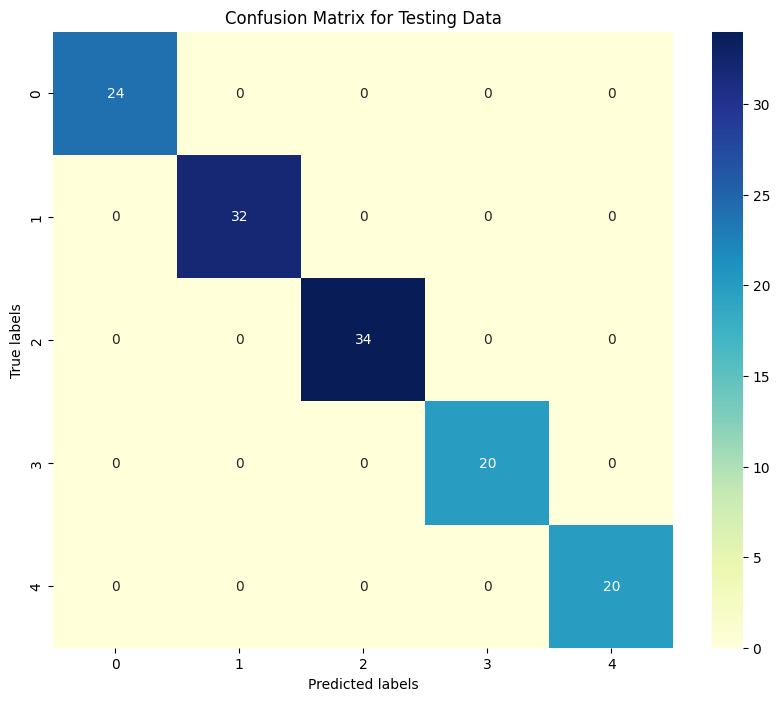

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# **Surreal art dataset Using Resnet only**

## **slicing up resnet features**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features_surreal.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels_surreal.npy', allow_pickle=True)

In [ ]:
art_styles_features.shape

(1300, 56900)

In [ ]:
length_of_color_hist = 3 * 32  # since bins=32
length_of_hog = hog_feature_length  # The length of HOG features

# Starting index for ResNet features
start_index = length_of_hog + length_of_color_hist

# Extracting just the ResNet features from the combined features
resnet_features_only = np.array([features[start_index:] for features in art_styles_features])

In [ ]:
resnet_features_only.shape

(1300, 2048)

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(resnet_features_only, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

## **Split the resnet features dataset**

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (resnet only)**

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00, 137.99it/s, valid_loss=5.86]


Epoch 1/30, Training Loss: 0.0466, Validation Loss: 0.0450, Training Accuracy: 54.71%, Validation Accuracy: 77.69%


Validating Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 119.54it/s, valid_loss=3.24]


Epoch 2/30, Training Loss: 0.0330, Validation Loss: 0.0249, Training Accuracy: 75.67%, Validation Accuracy: 82.31%


Validating Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00, 129.09it/s, valid_loss=1.8]


Epoch 3/30, Training Loss: 0.0201, Validation Loss: 0.0139, Training Accuracy: 86.83%, Validation Accuracy: 91.54%


Validating Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 110.99it/s, valid_loss=1.18]


Epoch 4/30, Training Loss: 0.0124, Validation Loss: 0.0090, Training Accuracy: 91.35%, Validation Accuracy: 94.62%


Validating Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00, 97.31it/s, valid_loss=0.761]


Epoch 5/30, Training Loss: 0.0081, Validation Loss: 0.0059, Training Accuracy: 95.10%, Validation Accuracy: 96.15%


Validating Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 119.34it/s, valid_loss=0.531]


Epoch 6/30, Training Loss: 0.0056, Validation Loss: 0.0041, Training Accuracy: 97.31%, Validation Accuracy: 97.69%


Validating Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 136.85it/s, valid_loss=0.404]


Epoch 7/30, Training Loss: 0.0039, Validation Loss: 0.0031, Training Accuracy: 98.27%, Validation Accuracy: 98.46%


Validating Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 106.07it/s, valid_loss=0.29]


Epoch 8/30, Training Loss: 0.0028, Validation Loss: 0.0022, Training Accuracy: 99.04%, Validation Accuracy: 100.00%


Validating Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 123.45it/s, valid_loss=0.207]


Epoch 9/30, Training Loss: 0.0021, Validation Loss: 0.0016, Training Accuracy: 99.42%, Validation Accuracy: 100.00%


Validating Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 117.44it/s, valid_loss=0.16]


Epoch 10/30, Training Loss: 0.0015, Validation Loss: 0.0012, Training Accuracy: 99.62%, Validation Accuracy: 100.00%


Validating Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00, 124.77it/s, valid_loss=0.116]


Epoch 11/30, Training Loss: 0.0011, Validation Loss: 0.0009, Training Accuracy: 99.81%, Validation Accuracy: 100.00%


Validating Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00, 128.17it/s, valid_loss=0.0967]


Epoch 12/30, Training Loss: 0.0009, Validation Loss: 0.0007, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 125.57it/s, valid_loss=0.0746]


Epoch 13/30, Training Loss: 0.0008, Validation Loss: 0.0006, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00, 122.05it/s, valid_loss=0.0613]


Epoch 14/30, Training Loss: 0.0006, Validation Loss: 0.0005, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00, 143.15it/s, valid_loss=0.051]


Epoch 15/30, Training Loss: 0.0006, Validation Loss: 0.0004, Training Accuracy: 99.90%, Validation Accuracy: 100.00%


Validating Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 124.25it/s, valid_loss=0.0392]


Epoch 16/30, Training Loss: 0.0005, Validation Loss: 0.0003, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00, 127.97it/s, valid_loss=0.0344]


Epoch 17/30, Training Loss: 0.0004, Validation Loss: 0.0003, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00, 60.01it/s, valid_loss=0.0296]


Epoch 18/30, Training Loss: 0.0004, Validation Loss: 0.0002, Training Accuracy: 99.90%, Validation Accuracy: 100.00%


Validating Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 44.57it/s, valid_loss=0.0246]


Epoch 19/30, Training Loss: 0.0003, Validation Loss: 0.0002, Training Accuracy: 99.90%, Validation Accuracy: 100.00%


Validating Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 110.63it/s, valid_loss=0.0216]


Epoch 20/30, Training Loss: 0.0002, Validation Loss: 0.0002, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00, 107.36it/s, valid_loss=0.0181]


Epoch 21/30, Training Loss: 0.0002, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 121.09it/s, valid_loss=0.0155]


Epoch 22/30, Training Loss: 0.0002, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 122.49it/s, valid_loss=0.0144]


Epoch 23/30, Training Loss: 0.0002, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00, 121.53it/s, valid_loss=0.0124]


Epoch 24/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00, 107.78it/s, valid_loss=0.012]


Epoch 25/30, Training Loss: 0.0002, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 118.99it/s, valid_loss=0.0104]


Epoch 26/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 115.68it/s, valid_loss=0.00963]


Epoch 27/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 110.87it/s, valid_loss=0.00809]


Epoch 28/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 134.01it/s, valid_loss=0.00736]


Epoch 29/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


Validating Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 118.29it/s, valid_loss=0.00682]


Epoch 30/30, Training Loss: 0.0001, Validation Loss: 0.0001, Training Accuracy: 100.00%, Validation Accuracy: 100.00%


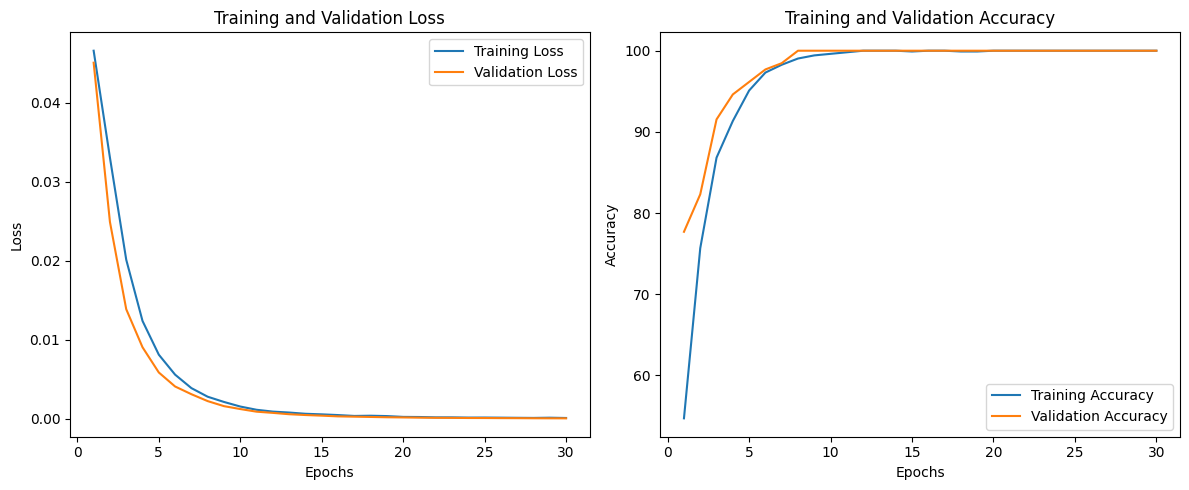

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (resnet only)**

In [ ]:
model_3.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_3(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0000, Test Accuracy: 100.00%


In [ ]:
import seaborn as sns

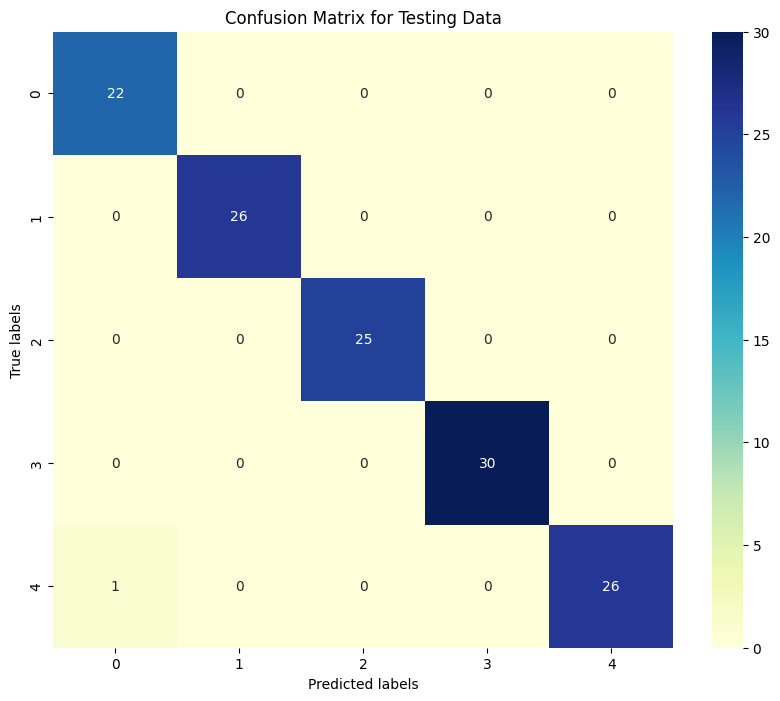

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# **Surreal art dataset using Resnet + color histograms**

## **slicing and splitting the dataset**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features_surreal.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels_surreal.npy', allow_pickle=True)

In [ ]:
length_of_hog = hog_feature_length

# Extracting color histogram and ResNet features from the combined features
color_hist_resnet_features_only = [features[length_of_hog:] for features in art_styles_features]

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(color_hist_resnet_features_only, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

<ipython-input-40-6aad2c35e38e>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  features_tensor = torch.tensor(color_hist_resnet_features_only, dtype=torch.float32)


In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (Resnet + color histograms)**

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00, 134.72it/s, valid_loss=38.5]


Epoch 1/30, Training Loss: 1.4877, Validation Loss: 0.2965, Training Accuracy: 31.54%, Validation Accuracy: 66.15%


Validating Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 127.22it/s, valid_loss=10.6]


Epoch 2/30, Training Loss: 0.5100, Validation Loss: 0.0817, Training Accuracy: 55.10%, Validation Accuracy: 75.38%


Validating Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00, 121.46it/s, valid_loss=4.21]


Epoch 3/30, Training Loss: 0.3386, Validation Loss: 0.0324, Training Accuracy: 60.58%, Validation Accuracy: 90.00%


Validating Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 101.72it/s, valid_loss=1.48]


Epoch 4/30, Training Loss: 0.2228, Validation Loss: 0.0114, Training Accuracy: 67.31%, Validation Accuracy: 91.54%


Validating Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00, 123.83it/s, valid_loss=0.82]


Epoch 5/30, Training Loss: 0.1750, Validation Loss: 0.0063, Training Accuracy: 69.52%, Validation Accuracy: 96.92%


Validating Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 89.29it/s, valid_loss=0.464]


Epoch 6/30, Training Loss: 0.1172, Validation Loss: 0.0036, Training Accuracy: 73.27%, Validation Accuracy: 96.92%


Validating Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 111.59it/s, valid_loss=0.306]


Epoch 7/30, Training Loss: 0.0992, Validation Loss: 0.0024, Training Accuracy: 80.58%, Validation Accuracy: 96.92%


Validating Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 114.35it/s, valid_loss=1.27]


Epoch 8/30, Training Loss: 0.0813, Validation Loss: 0.0098, Training Accuracy: 80.38%, Validation Accuracy: 96.92%


Validating Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 90.00it/s, valid_loss=0.378]


Epoch 9/30, Training Loss: 0.0848, Validation Loss: 0.0029, Training Accuracy: 80.58%, Validation Accuracy: 97.69%


Validating Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 105.99it/s, valid_loss=1.05]


Epoch 10/30, Training Loss: 0.0589, Validation Loss: 0.0080, Training Accuracy: 82.12%, Validation Accuracy: 97.69%


Validating Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00, 94.67it/s, valid_loss=0.29]


Epoch 11/30, Training Loss: 0.0419, Validation Loss: 0.0022, Training Accuracy: 87.69%, Validation Accuracy: 96.92%


Validating Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00, 112.71it/s, valid_loss=0.477]


Epoch 12/30, Training Loss: 0.0398, Validation Loss: 0.0037, Training Accuracy: 87.88%, Validation Accuracy: 98.46%


Validating Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 103.65it/s, valid_loss=1.01]


Epoch 13/30, Training Loss: 0.0344, Validation Loss: 0.0078, Training Accuracy: 87.98%, Validation Accuracy: 98.46%


Validating Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00, 108.63it/s, valid_loss=0.944]


Epoch 14/30, Training Loss: 0.0349, Validation Loss: 0.0073, Training Accuracy: 89.42%, Validation Accuracy: 98.46%


Validating Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00, 108.52it/s, valid_loss=0.405]


Epoch 15/30, Training Loss: 0.0321, Validation Loss: 0.0031, Training Accuracy: 90.58%, Validation Accuracy: 98.46%


Validating Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 117.69it/s, valid_loss=0.717]


Epoch 16/30, Training Loss: 0.0242, Validation Loss: 0.0055, Training Accuracy: 91.06%, Validation Accuracy: 98.46%


Validating Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00, 123.93it/s, valid_loss=0.518]


Epoch 17/30, Training Loss: 0.0266, Validation Loss: 0.0040, Training Accuracy: 90.38%, Validation Accuracy: 98.46%


Validating Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00, 108.56it/s, valid_loss=0.924]


Epoch 18/30, Training Loss: 0.0164, Validation Loss: 0.0071, Training Accuracy: 92.69%, Validation Accuracy: 98.46%


Validating Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 102.32it/s, valid_loss=0.682]


Epoch 19/30, Training Loss: 0.0204, Validation Loss: 0.0052, Training Accuracy: 92.12%, Validation Accuracy: 98.46%


Validating Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 112.39it/s, valid_loss=0.835]


Epoch 20/30, Training Loss: 0.0159, Validation Loss: 0.0064, Training Accuracy: 92.02%, Validation Accuracy: 98.46%


Validating Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00, 109.89it/s, valid_loss=1.1]


Epoch 21/30, Training Loss: 0.0125, Validation Loss: 0.0084, Training Accuracy: 93.17%, Validation Accuracy: 98.46%


Validating Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 115.79it/s, valid_loss=1.06]


Epoch 22/30, Training Loss: 0.0147, Validation Loss: 0.0082, Training Accuracy: 93.65%, Validation Accuracy: 98.46%


Validating Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 93.40it/s, valid_loss=1.72]


Epoch 23/30, Training Loss: 0.0139, Validation Loss: 0.0132, Training Accuracy: 94.62%, Validation Accuracy: 98.46%


Validating Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00, 110.64it/s, valid_loss=0.894]


Epoch 24/30, Training Loss: 0.0106, Validation Loss: 0.0069, Training Accuracy: 95.48%, Validation Accuracy: 98.46%


Validating Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00, 114.89it/s, valid_loss=0.184]


Epoch 25/30, Training Loss: 0.0107, Validation Loss: 0.0014, Training Accuracy: 95.19%, Validation Accuracy: 99.23%


Validating Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 113.62it/s, valid_loss=0.216]


Epoch 26/30, Training Loss: 0.0115, Validation Loss: 0.0017, Training Accuracy: 94.33%, Validation Accuracy: 98.46%


Validating Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 108.82it/s, valid_loss=0.0739]


Epoch 27/30, Training Loss: 0.0085, Validation Loss: 0.0006, Training Accuracy: 95.29%, Validation Accuracy: 99.23%


Validating Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 119.50it/s, valid_loss=0.252]


Epoch 28/30, Training Loss: 0.0121, Validation Loss: 0.0019, Training Accuracy: 95.29%, Validation Accuracy: 98.46%


Validating Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 103.17it/s, valid_loss=0.348]


Epoch 29/30, Training Loss: 0.0104, Validation Loss: 0.0027, Training Accuracy: 95.58%, Validation Accuracy: 98.46%


Validating Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 122.38it/s, valid_loss=0.137]


Epoch 30/30, Training Loss: 0.0104, Validation Loss: 0.0011, Training Accuracy: 95.58%, Validation Accuracy: 99.23%


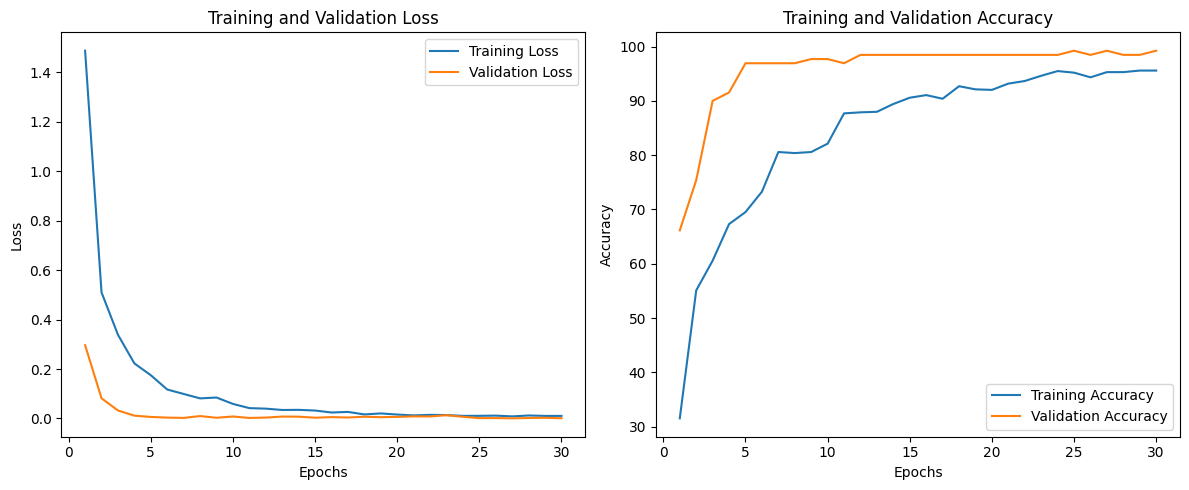

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (Resnet + color histogram)**

In [ ]:
model_3.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_3(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0000, Test Accuracy: 100.00%


In [ ]:
import seaborn as sns

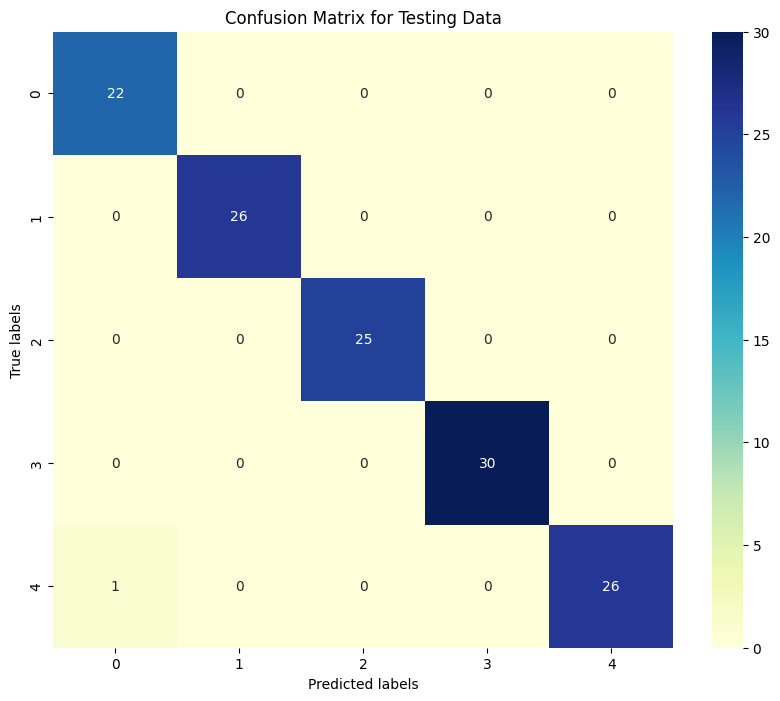

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# **Surreal art dataset using Resnet + HOG (hitsorgram of oriented gradients)**

## **slicing and splitting the dataset**

In [ ]:
import numpy as np
art_styles_features = np.load('/content/drive/MyDrive/art_styles_features_surreal.npy', allow_pickle=True)
labels_dataset = np.load('/content/drive/MyDrive/art_styles_labels_surreal.npy', allow_pickle=True)

In [ ]:
# Length of color histogram features
length_of_color_hist = 3 * 32  # 3 channels * 32 bins

# Extracting HOG and ResNet features from the combined features
hog_resnet_features_only = np.array([features[length_of_color_hist:] for features in art_styles_features])

In [ ]:
# Convert to PyTorch tensors
features_tensor = torch.tensor(hog_resnet_features_only, dtype=torch.float32)
labels_tensor = torch.tensor(labels_dataset, dtype=torch.long)  # assuming labels are integer classes

In [ ]:
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [ ]:
# Total number of samples
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

# Split the data
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## **Training (Resnet + hog)**

We progressed the training expermint, we started with 100 epochs and tried diffrent learning rates, Adam and SGD optimizers.

we begin with 0.3 drop rate, then increased to 0.5 after noticing some overfitting happening, we tried diffrent learning rates, we adjusted according to our graphs observations and what we think will work best from out experience.

In [ ]:
all_train_labels = torch.tensor([label for _, label in full_dataset])
num_classes = len(torch.unique(all_train_labels))

# Example usage
input_dim = train_dataset[0][0].shape[0]  # Get input dimension
hidden_dims = [512, 256]  # Specify the dimensions of hidden layers
output_dim = num_classes  # Output dimension, number of classes
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model_3 = DeepNN(input_dim, hidden_dims, output_dim, dropout_rate)

In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30

# Lists to store metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    model_3.train()

    train_loss_epoch = 0.0
    train_correct = 0

    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (data, target) in train_loop:
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()

        train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        train_loop.set_postfix(loss=loss.item())

    train_loss_epoch /= len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    train_accuracies.append(train_accuracy)

    # Validation
    model_3.eval()
    valid_loss = 0.0
    correct = 0
    valid_loop = tqdm(valid_loader, leave=True)
    with torch.no_grad():
        for data, target in valid_loop:
            output = model_3(data)
            valid_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()

            valid_loop.set_description(f"Validating Epoch {epoch+1}/{num_epochs}")
            valid_loop.set_postfix(valid_loss=valid_loss)

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)


    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        best_model_state_3 = model_3.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {valid_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

torch.save(best_model_state_3, 'best_model_3.pth')

Validating Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s, valid_loss=4.36]


Epoch 1/30, Training Loss: 0.2043, Validation Loss: 0.0335, Training Accuracy: 45.38%, Validation Accuracy: 73.08%


Validating Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s, valid_loss=3.3]


Epoch 2/30, Training Loss: 0.0664, Validation Loss: 0.0253, Training Accuracy: 60.48%, Validation Accuracy: 80.00%


Validating Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00, 19.80it/s, valid_loss=1.7]


Epoch 3/30, Training Loss: 0.0456, Validation Loss: 0.0131, Training Accuracy: 69.71%, Validation Accuracy: 86.15%


Validating Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 18.45it/s, valid_loss=1.74]


Epoch 4/30, Training Loss: 0.0280, Validation Loss: 0.0134, Training Accuracy: 75.29%, Validation Accuracy: 90.77%


Validating Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00, 15.26it/s, valid_loss=7.36]


Epoch 5/30, Training Loss: 0.0211, Validation Loss: 0.0566, Training Accuracy: 83.56%, Validation Accuracy: 90.77%


Validating Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 12.84it/s, valid_loss=0.621]


Epoch 6/30, Training Loss: 0.0139, Validation Loss: 0.0048, Training Accuracy: 84.62%, Validation Accuracy: 95.38%


Validating Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 13.24it/s, valid_loss=0.562]


Epoch 7/30, Training Loss: 0.0118, Validation Loss: 0.0043, Training Accuracy: 87.50%, Validation Accuracy: 95.38%


Validating Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s, valid_loss=0.546]


Epoch 8/30, Training Loss: 0.0127, Validation Loss: 0.0042, Training Accuracy: 88.46%, Validation Accuracy: 96.15%


Validating Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s, valid_loss=0.618]


Epoch 9/30, Training Loss: 0.0103, Validation Loss: 0.0048, Training Accuracy: 91.54%, Validation Accuracy: 97.69%


Validating Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s, valid_loss=0.307]


Epoch 10/30, Training Loss: 0.0091, Validation Loss: 0.0024, Training Accuracy: 90.19%, Validation Accuracy: 98.46%


Validating Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00, 13.20it/s, valid_loss=0.359]


Epoch 11/30, Training Loss: 0.0108, Validation Loss: 0.0028, Training Accuracy: 89.62%, Validation Accuracy: 99.23%


Validating Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00, 12.83it/s, valid_loss=0.419]


Epoch 12/30, Training Loss: 0.0073, Validation Loss: 0.0032, Training Accuracy: 91.54%, Validation Accuracy: 97.69%


Validating Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 12.45it/s, valid_loss=0.433]


Epoch 13/30, Training Loss: 0.0077, Validation Loss: 0.0033, Training Accuracy: 92.40%, Validation Accuracy: 95.38%


Validating Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s, valid_loss=0.228]


Epoch 14/30, Training Loss: 0.0062, Validation Loss: 0.0018, Training Accuracy: 93.37%, Validation Accuracy: 100.00%


Validating Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s, valid_loss=0.153]


Epoch 15/30, Training Loss: 0.0048, Validation Loss: 0.0012, Training Accuracy: 94.42%, Validation Accuracy: 100.00%


Validating Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s, valid_loss=0.148]


Epoch 16/30, Training Loss: 0.0038, Validation Loss: 0.0011, Training Accuracy: 96.15%, Validation Accuracy: 100.00%


Validating Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s, valid_loss=0.0935]


Epoch 17/30, Training Loss: 0.0053, Validation Loss: 0.0007, Training Accuracy: 97.02%, Validation Accuracy: 100.00%


Validating Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00, 13.86it/s, valid_loss=0.0691]


Epoch 18/30, Training Loss: 0.0030, Validation Loss: 0.0005, Training Accuracy: 97.60%, Validation Accuracy: 100.00%


Validating Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s, valid_loss=0.0503]


Epoch 19/30, Training Loss: 0.0025, Validation Loss: 0.0004, Training Accuracy: 97.40%, Validation Accuracy: 100.00%


Validating Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 13.01it/s, valid_loss=0.0413]


Epoch 20/30, Training Loss: 0.0029, Validation Loss: 0.0003, Training Accuracy: 97.12%, Validation Accuracy: 100.00%


Validating Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s, valid_loss=0.0699]


Epoch 21/30, Training Loss: 0.0037, Validation Loss: 0.0005, Training Accuracy: 96.15%, Validation Accuracy: 100.00%


Validating Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s, valid_loss=0.0957]


Epoch 22/30, Training Loss: 0.0032, Validation Loss: 0.0007, Training Accuracy: 96.35%, Validation Accuracy: 100.00%


Validating Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s, valid_loss=0.0993]


Epoch 23/30, Training Loss: 0.0038, Validation Loss: 0.0008, Training Accuracy: 97.21%, Validation Accuracy: 98.46%


Validating Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s, valid_loss=0.113]


Epoch 24/30, Training Loss: 0.0040, Validation Loss: 0.0009, Training Accuracy: 96.06%, Validation Accuracy: 99.23%


Validating Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s, valid_loss=0.0501]


Epoch 25/30, Training Loss: 0.0044, Validation Loss: 0.0004, Training Accuracy: 95.10%, Validation Accuracy: 100.00%


Validating Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 20.15it/s, valid_loss=0.0699]


Epoch 26/30, Training Loss: 0.0034, Validation Loss: 0.0005, Training Accuracy: 96.44%, Validation Accuracy: 100.00%


Validating Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 19.86it/s, valid_loss=0.0887]


Epoch 27/30, Training Loss: 0.0036, Validation Loss: 0.0007, Training Accuracy: 96.54%, Validation Accuracy: 100.00%


Validating Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s, valid_loss=0.0458]


Epoch 28/30, Training Loss: 0.0030, Validation Loss: 0.0004, Training Accuracy: 96.83%, Validation Accuracy: 100.00%


Validating Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 19.77it/s, valid_loss=0.0278]


Epoch 29/30, Training Loss: 0.0026, Validation Loss: 0.0002, Training Accuracy: 97.50%, Validation Accuracy: 100.00%


Validating Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 13.12it/s, valid_loss=0.0219]


Epoch 30/30, Training Loss: 0.0027, Validation Loss: 0.0002, Training Accuracy: 98.37%, Validation Accuracy: 100.00%


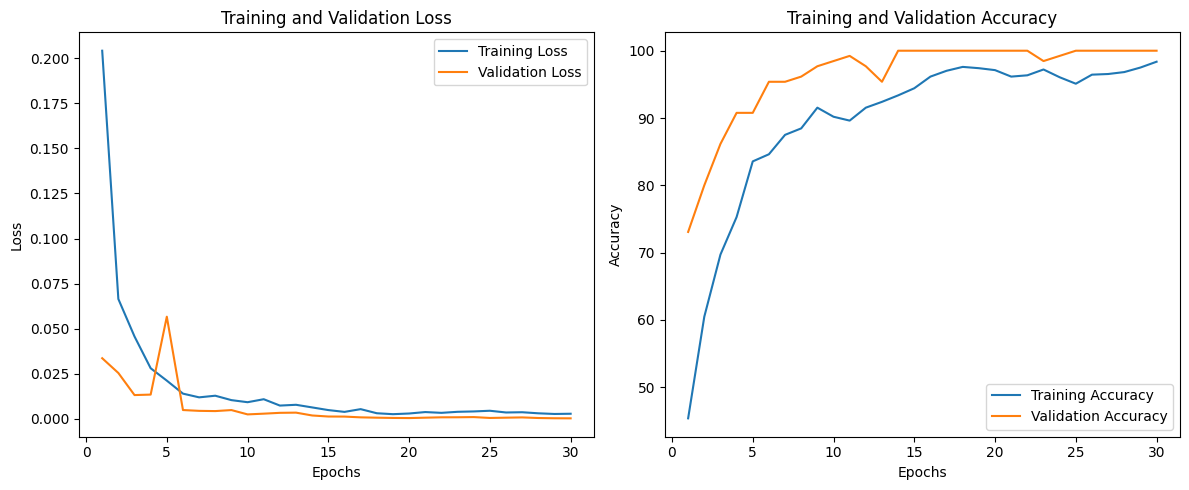

In [ ]:
import matplotlib.pyplot as plt

# Plotting both the training and validation loss
plt.figure(figsize=(12, 5))

# Plot for training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Testing (Resnet + hog)**

In [ ]:
model_3.eval()
test_loss = 0.0
correct = 0

# 1. Find the maximum class index in the test dataset
max_class_index = -1
for _, target in test_loader:
    max_class_index = max(max_class_index, target.max().item())

num_classes = max_class_index + 1

# 2. Initialize the confusion matrix with the correct size
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for data, target in test_loader:
        output = model_3(data)
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

        # 3. Update confusion matrix
        for t, p in zip(target.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0005, Test Accuracy: 100.00%


In [ ]:
import seaborn as sns

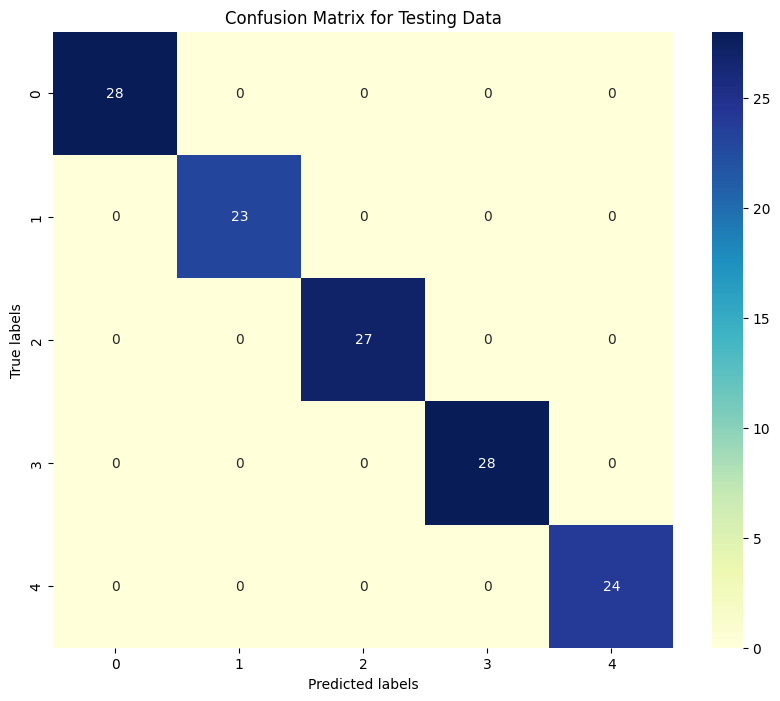

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Testing Data')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Flatten the confusion matrix and calculate precision, recall, and F1 score
y_true = []
y_pred = []
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix)):
        y_true.extend([i] * confusion_matrix[i][j])
        y_pred.extend([j] * confusion_matrix[i][j])

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 1.0
Recall: 1.0
F1 Score: 1.0
